In [2]:
import numpy as np
from tqdm.notebook import tqdm, trange
from alive_progress import alive_bar
import time # to be used in loop iterations
import caffeine
from multiprocess import Pool
import matplotlib.pyplot as plt
from queue import Queue
from threading import Thread
np.random.seed(1234)

## SGD dynamics

In [3]:
#Ground truth data distribution
def random_sample_anisotropic(d, Delta, N, s_0):
    y = np.ones(N)
    x = np.zeros((N,d))
    successes = np.random.binomial(N, 0.5)
    y[successes:] *= -1
    x[:successes, :] = np.random.multivariate_normal([0]*d, np.diag([(1+Delta)**2]*s_0 + [1]*(d-s_0)), successes)
    x[successes:, :] = np.random.multivariate_normal([0]*d, np.diag([(1-Delta)**2]*s_0 + [1]*(d-s_0)), N-successes)
    
    return x.reshape(N,d),y

In [4]:
#Relu activation function
def neural_net_relu(a,b,w,x):
    #shape of w: (N,d)
    #shape of x: (n,d)
    #shape of b: (1,N)
    #shape of a: (1,N)
    n = x.shape[0]
    return np.mean(a.T*np.maximum(w@x.T+b.T, 0), axis = 0).reshape(1,n)

def relu(a,b,w,x):
    #shape of w: (N,d)
    #shape of x: (n,d)
    #shape of b: (1,N)
    #shape of a: (1,N)
    N = w.shape[0]
    n = x.shape[0]
    return (a.T*np.maximum(w@x.T+b.T, 0)).reshape(N,n)

def drelu(t):
    if t>0:
        return 1
    else:
        return 0
drelu = np.vectorize(drelu)

def grad_sigma_relu(a,b,w,x):
    #shape of w: (N,d)
    #shape of x: (n,d)
    #shape of b: (1,N)
    #shape of a; (1,N)
    N = w.shape[0]
    d = w.shape[1]
    
    da = relu(a,b,w,x).reshape(1,N)
    db = a*drelu(w@x.T+b.T).reshape(1,N)
    dw = ((a.T*drelu(w@x.T+b.T))*x).reshape(N,d)
    
    return da, db, dw

In [131]:
def stochastic_gradient_descent(d, s_0, Delta, N, epsilon = 1e-5, num_epochs = 1000):
    
    weights = np.random.multivariate_normal([0]*d, np.diag([(0.8)**2/d]*d), N).reshape(N, d)
    a = np.ones(N).reshape(1,N)
    b = np.ones(N).reshape(1,N)
    indices = [1,2,5,7,10]+[int(a) for a in 10**(np.linspace(1.1, np.log10(num_epochs), 20))]
    risk = []
    mean_b = []
    
    for epoch in trange(1, num_epochs+1): 
        # Update the weights
        x,y = random_sample_anisotropic(d,Delta,1,s_0)
        x = x.reshape(1,d)
        
        da, db, dw = grad_sigma_relu(a,b,weights,x)
        
        weights += 2*epsilon*(epoch*epsilon)**(-0.25)*(y-neural_net_relu(a, b, weights, x))*dw
        a += 2*epsilon*(epoch*epsilon)**(-0.25)*(y-neural_net_relu(a, b, weights, x))*da
        b += 2*epsilon*(epoch*epsilon)**(-0.25)*(y-neural_net_relu(a, b, weights, x))*db
        
        if epoch in indices:
        #population risk
            M = int(1e4)
            x_sample, y_sample = random_sample_anisotropic(d, Delta, M, s_0)
            mse = np.mean((y_sample-neural_net_relu(a, b,weights, x_sample))**2)
            risk.append(mse)
            #dist = np.mean(np.linalg.norm(weights, axis = 1))
            mean = np.mean(b)
            mean_b.append(mean)
            print('Epoch: {}, a: {}'.format(epoch, mean))
                
    return weights, np.array(risk), mean_b

In [183]:
weights, risk_SGD, a_SGD = stochastic_gradient_descent(320, 60, 0.2, 800, epsilon = (2e-4)**(4/3), num_epochs = int(1e3))

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 1, a: 0.9993483314277297
Epoch: 2, a: 0.9993286757424801
Epoch: 5, a: 0.9983248451675203
Epoch: 7, a: 0.9978852364164831
Epoch: 10, a: 0.9970896939783128
Epoch: 12, a: 0.9963388432717838
Epoch: 15, a: 0.995990406555159
Epoch: 19, a: 0.9949668225251226
Epoch: 25, a: 0.9939893715816716
Epoch: 31, a: 0.993088655785572
Epoch: 39, a: 0.9916850159115259
Epoch: 50, a: 0.9890688123961117
Epoch: 63, a: 0.987781173766183
Epoch: 79, a: 0.9852114107188885
Epoch: 100, a: 0.982746057556721
Epoch: 125, a: 0.9799434288574704
Epoch: 158, a: 0.9764317363722295
Epoch: 199, a: 0.973312157179061
Epoch: 251, a: 0.9692823439761598
Epoch: 316, a: 0.9657564364186021
Epoch: 398, a: 0.9602277137400997
Epoch: 501, a: 0.9531684185924374
Epoch: 630, a: 0.9451983255772081
Epoch: 794, a: 0.9353799782964006
Epoch: 1000, a: 0.9252053620032916


## PDE simulation

In [7]:
from scipy.stats import norm

def q_plus(r1, r2, b, Delta):
    root_plus = np.sqrt((1+Delta)**2*r1**2+r2**2)
    return b*norm.cdf(b/(root_plus))+root_plus*norm.pdf(b/root_plus)

def q_minus(r1, r2, b, Delta):
    root_minus = np.sqrt((1-Delta)**2*r1**2+r2**2)
    return b*norm.cdf(b/(root_minus))+root_minus*norm.pdf(b/root_minus)

def dq_plus(r1, r2, b, Delta):
    from scipy.stats import norm
    d_normal = lambda x: -x*norm.pdf(x)
    
    root_plus = np.sqrt((1+Delta)**2*r1**2+r2**2)
    
    droot_plus_1 = (1+Delta)**2*r1/root_plus
    droot_plus_2 = r2/root_plus
    
    db = norm.cdf(b/(root_plus)) + b/(root_plus)*norm.pdf(b/root_plus) + d_normal(b/root_plus)
    dr1 = -droot_plus_1/(root_plus**2)*b**2*norm.pdf(b/(root_plus))\
                    +droot_plus_1*norm.pdf(b/root_plus)-b*droot_plus_1/(root_plus**2)*d_normal(b/root_plus)
    dr2 = -droot_plus_2/(root_plus**2)*b**2*norm.pdf(b/(root_plus))\
                    +droot_plus_2*norm.pdf(b/root_plus) -b*droot_plus_2/(root_plus**2)*d_normal(b/root_plus)
    return db, dr1, dr2

def dq_minus(r1, r2, b, Delta):
    from scipy.stats import norm
    d_normal = lambda x: -x*norm.pdf(x)
    
    root_minus = np.sqrt((1-Delta)**2*r1**2+r2**2)
    
    droot_minus_1 = (1-Delta)**2*r1/root_minus
    droot_minus_2 = r2/root_minus
    
    db = norm.cdf(b/(root_minus)) + b/(root_minus)*norm.pdf(b/root_minus) + d_normal(b/root_minus)
    dr1 = -droot_minus_1/(root_minus**2)*b**2*norm.pdf(b/(root_minus))\
                    +droot_minus_1*norm.pdf(b/root_minus) - b*droot_minus_1/(root_minus**2)*d_normal(b/root_minus)
    dr2 = -droot_minus_2/(root_minus**2)*b**2*norm.pdf(b/(root_minus))\
                    +droot_minus_2*norm.pdf(b/root_minus) -b*droot_minus_2/(root_minus**2)*d_normal(b/root_minus)
    return db, dr1, dr2

def R_inf(r, Delta):
    #shape of r is (J, 4)
    a = r[:,0]
    b = r[:,1]
    r1 = r[:,2]
    r2 = r[:,3]
    
    plus = a*q_plus(r1, r2, b, Delta)
    minus = a*q_minus(r1, r2, b, Delta)

    mean_q_plus = np.mean(plus)
    mean_q_minus = np.mean(minus)
    return 0.5 * (1 - mean_q_plus) ** 2 + 0.5 * (1 + mean_q_minus) ** 2

def grad_R_inf(r, Delta):
    
    #shape of r: (J, 4)
    #shape of grad: (J, 4)
    
    J = len(r)
    a = r[:,0]
    b = r[:,1]
    r1 = r[:,2]
    r2 = r[:,3]
    
    plus = a*q_plus(r1, r2, b, Delta)
    minus = a*q_minus(r1, r2, b, Delta)

    mean_q_plus = np.mean(plus)
    mean_q_minus = np.mean(minus)
    
    db_plus, dr1_plus, dr2_plus = dq_plus(r1, r2, b, Delta)
    db_minus, dr1_minus, dr2_minus = dq_minus(r1, r2, b, Delta)
    
    grad = np.zeros((J,4))
    #da
    grad[:,0] = -1/J*plus*(1-mean_q_plus) + 1/J*minus*(1+mean_q_minus)
    #db
    grad[:,1] = -1/J*db_plus*(1-mean_q_plus) + 1/J*db_minus*(1+mean_q_minus)
    #dr1
    grad[:,2] = -1/J*dr1_plus*(1-mean_q_plus) + 1/J*dr1_minus*(1+mean_q_minus)
    #dr2
    grad[:,3] = -1/J*dr2_plus*(1-mean_q_plus) + 1/J*dr2_minus*(1+mean_q_minus)
    
    return grad

In [8]:
#simulate pde
def pde_sim(d = 320, J = 1, epsilon = 2e-4, Delta = 0.2, s_0 = 60):
    Interval = 10**np.linspace(-5,np.log10(epsilon*1e7), int(1e5))
    risk = []
    mean_b = []
    separations = [Interval[k+1]-Interval[k] for k in range(len(Interval)-1)]
    #initialise params
    Z = np.random.multivariate_normal([0]*d, np.diag([(0.8)**2/d]*d), J).reshape(J, d)
    a = np.ones(J).reshape(J,1)
    b = np.ones(J).reshape(J,1)
    r1 = np.linalg.norm(Z[:,:s_0], axis = 1).reshape(J,1)
    r2 = np.linalg.norm(Z[:,s_0:], axis = 1).reshape(J,1)
    r = np.hstack((a,b,r1,r2)).reshape(J,4)

    for k in trange(len(separations)):
        dt = separations[k]
        grad = grad_R_inf(r, Delta)
        r = r - (Interval[k])**(-0.25)* J * grad * dt
        error = R_inf(r, Delta)
        b = r[:,1]
        mean_b.append(np.mean(b))
        risk.append(error)
        print(np.mean(b))
    return risk, mean_b

In [182]:
pde_risk, mean_a_pde = pde_sim(d = 320, J = 400, epsilon = 2e-4, Delta = 0.2, s_0 = 60)

  0%|          | 0/99999 [00:00<?, ?it/s]

0.9999999361209575
0.9999998722327659
0.9999998083354239
0.9999997444289304
0.9999996805132835
0.9999996165884827
0.9999995526545259
0.9999994887114123
0.9999994247591405
0.999999360797709
0.9999992968271169
0.9999992328473624
0.9999991688584444
0.9999991048603616
0.9999990408531128
0.9999989768366963
0.9999989128111113
0.9999988487763563
0.9999987847324298
0.9999987206793307
0.9999986566170574
0.9999985925456091
0.9999985284649838
0.9999984643751807
0.9999984002761986
0.9999983361680358
0.9999982720506911
0.9999982079241633
0.9999981437884509
0.9999980796435528
0.9999980154894675
0.9999979513261937
0.9999978871537303
0.9999978229720756
0.9999977587812288
0.999997694581188
0.9999976303719526
0.9999975661535205
0.9999975019258909
0.9999974376890622
0.9999973734430334
0.9999973091878028
0.9999972449233695
0.999997180649732
0.9999971163668887
0.9999970520748386
0.9999969877735805
0.999996923463113
0.9999968591434342
0.9999967948145436
0.9999967304764396
0.9999966661291206
0.99999660177258

0.9999681934635015
0.9999681250291215
0.9999680565849408
0.9999679881309577
0.999967919667171
0.9999678511935791
0.9999677827101808
0.9999677142169747
0.9999676457139595
0.9999675772011335
0.9999675086784954
0.9999674401460439
0.9999673716037775
0.9999673030516948
0.9999672344897944
0.999967165918075
0.999967097336535
0.9999670287451731
0.9999669601439879
0.9999668915329781
0.9999668229121422
0.9999667542814789
0.9999666856409862
0.9999666169906638
0.9999665483305092
0.9999664796605217
0.9999664109806994
0.9999663422910414
0.9999662735915459
0.9999662048822118
0.9999661361630373
0.9999660674340214
0.9999659986951625
0.999965929946459
0.9999658611879099
0.9999657924195136
0.9999657236412685
0.9999656548531733
0.9999655860552269
0.9999655172474274
0.9999654484297739
0.9999653796022645
0.9999653107648981
0.9999652419176732
0.9999651730605886
0.9999651041936424
0.9999650353168336
0.9999649664301608
0.9999648975336223
0.9999648286272168
0.999964759710943
0.9999646907847993
0.999964621848784

0.999934924590028
0.9999348513912145
0.9999347781819188
0.9999347049621392
0.9999346317318742
0.9999345584911222
0.9999344852398818
0.9999344119781515
0.9999343387059298
0.9999342654232153
0.9999341921300061
0.9999341188263012
0.999934045512099
0.9999339721873975
0.9999338988521959
0.9999338255064923
0.9999337521502852
0.9999336787835732
0.9999336054063549
0.9999335320186284
0.9999334586203926
0.999933385211646
0.9999333117923868
0.9999332383626137
0.9999331649223251
0.9999330914715197
0.9999330180101957
0.9999329445383518
0.9999328710559863
0.9999327975630979
0.9999327240596849
0.9999326505457462
0.9999325770212798
0.9999325034862845
0.9999324299407587
0.9999323563847008
0.9999322828181095
0.9999322092409831
0.9999321356533202
0.9999320620551191
0.9999319884463788
0.9999319148270972
0.9999318411972731
0.9999317675569048
0.9999316939059912
0.9999316202445303
0.9999315465725209
0.9999314728899614
0.9999313991968503
0.999931325493186
0.9999312517789671
0.9999311780541922
0.99993110431885

0.9998991046951368
0.9998990263669476
0.9998989480275423
0.9998988696769194
0.9998987913150772
0.999898712942014
0.9998986345577283
0.9998985561622188
0.9998984777554832
0.9998983993375206
0.9998983209083289
0.9998982424679065
0.9998981640162522
0.9998980855533642
0.9998980070792407
0.9998979285938805
0.9998978500972814
0.9998977715894424
0.9998976930703616
0.9998976145400372
0.999897535998468
0.9998974574456522
0.999897378881588
0.9998973003062741
0.9998972217197086
0.9998971431218905
0.9998970645128173
0.9998969858924882
0.9998969072609011
0.9998968286180545
0.9998967499639468
0.9998966712985765
0.9998965926219419
0.999896513934041
0.999896435234873
0.9998963565244359
0.9998962778027277
0.9998961990697472
0.999896120325493
0.999896041569963
0.999895962803156
0.99989588402507
0.9998958052357036
0.9998957264350551
0.999895647623123
0.9998955687999057
0.9998954899654016
0.9998954111196088
0.9998953322625259
0.9998952533941514
0.9998951745144834
0.9998950956235205
0.9998950167212612
0.99

0.9998594323359049
0.9998593483271414
0.9998592643063493
0.999859180273527
0.999859096228673
0.9998590121717852
0.9998589281028623
0.9998588440219021
0.9998587599289033
0.9998586758238637
0.9998585917067822
0.9998585075776566
0.9998584234364852
0.9998583392832668
0.999858255117999
0.9998581709406804
0.9998580867513093
0.9998580025498839
0.9998579183364026
0.9998578341108635
0.9998577498732647
0.9998576656236051
0.9998575813618824
0.9998574970880951
0.9998574128022413
0.9998573285043196
0.9998572441943281
0.9998571598722651
0.9998570755381287
0.9998569911919174
0.9998569068336294
0.9998568224632629
0.9998567380808163
0.9998566536862878
0.9998565692796757
0.9998564848609783
0.9998564004301937
0.9998563159873203
0.9998562315323564
0.9998561470653005
0.9998560625861502
0.9998559780949043
0.9998558935915611
0.9998558090761186
0.9998557245485753
0.9998556400089291
0.9998555554571789
0.9998554708933224
0.9998553863173579
0.9998553017292842
0.999855217129099
0.9998551325168008
0.99985504789238

0.9998207451178308
0.9998206555700291
0.9998205660094068
0.9998204764359622
0.9998203868496935
0.9998202972505987
0.9998202076386764
0.9998201180139241
0.9998200283763407
0.9998199387259238
0.9998198490626719
0.999819759386583
0.9998196696976552
0.999819579995887
0.9998194902812761
0.9998194005538211
0.99981931081352
0.9998192210603708
0.9998191312943717
0.999819041515521
0.999818951723817
0.9998188619192575
0.9998187721018408
0.9998186822715652
0.9998185924284289
0.9998185025724297
0.999818412703566
0.999818322821836
0.9998182329272377
0.9998181430197696
0.9998180530994296
0.9998179631662157
0.9998178732201264
0.9998177832611594
0.9998176932893137
0.9998176033045865
0.9998175133069764
0.9998174232964817
0.9998173332731003
0.9998172432368304
0.9998171531876704
0.9998170631256181
0.999816973050672
0.99981688296283
0.9998167928620902
0.999816702748451
0.9998166126219106
0.9998165224824669
0.9998164323301181
0.9998163421648624
0.999816251986698
0.999816161795623
0.9998160715916359
0.99981

0.9997805562752538
0.9997804609739169
0.9997803656589371
0.9997802703303122
0.9997801749880406
0.9997800796321202
0.999779984262549
0.999779888879325
0.9997797934824463
0.999779698071911
0.9997796026477173
0.9997795072098625
0.9997794117583457
0.9997793162931643
0.9997792208143167
0.9997791253218006
0.9997790298156142
0.9997789342957555
0.9997788387622228
0.9997787432150136
0.9997786476541265
0.9997785520795592
0.99977845649131
0.9997783608893767
0.9997782652737576
0.9997781696444505
0.9997780740014535
0.9997779783447648
0.9997778826743823
0.999777786990304
0.999777691292528
0.9997775955810525
0.9997774998558754
0.9997774041169946
0.9997773083644083
0.9997772125981146
0.9997771168181114
0.9997770210243968
0.9997769252169689
0.9997768293958257
0.9997767335609652
0.9997766377123853
0.9997765418500844
0.9997764459740602
0.9997763500843111
0.9997762541808348
0.9997761582636293
0.9997760623326929
0.9997759663880237
0.9997758704296191
0.9997757744574781
0.9997756784715981
0.9997755824719772


0.9997320832229926
0.9997319809828078
0.9997318787279883
0.9997317764585322
0.9997316741744371
0.9997315718757008
0.9997314695623214
0.9997313672342969
0.9997312648916251
0.9997311625343039
0.9997310601623312
0.9997309577757048
0.9997308553744227
0.999730752958483
0.9997306505278831
0.9997305480826216
0.999730445622696
0.999730343148104
0.999730240658844
0.9997301381549133
0.9997300356363106
0.999729933103033
0.9997298305550789
0.9997297279924462
0.9997296254151326
0.9997295228231358
0.9997294202164543
0.9997293175950852
0.9997292149590273
0.9997291123082781
0.9997290096428353
0.9997289069626969
0.999728804267861
0.9997287015583253
0.9997285988340877
0.9997284960951462
0.9997283933414988
0.9997282905731433
0.9997281877900772
0.9997280849922991
0.9997279821798065
0.9997278793525973
0.9997277765106694
0.9997276736540209
0.9997275707826493
0.9997274678965531
0.9997273649957296
0.9997272620801769
0.999727159149893
0.9997270562048758
0.9997269532451228
0.9997268502706324
0.9997267472814024


0.9996845646011044
0.9996844555594143
0.9996843465021173
0.9996842374292114
0.9996841283406944
0.9996840192365639
0.9996839101168179
0.9996838009814539
0.9996836918304698
0.9996835826638635
0.9996834734816327
0.9996833642837748
0.9996832550702882
0.9996831458411704
0.9996830365964189
0.9996829273360318
0.9996828180600068
0.9996827087683414
0.9996825994610339
0.9996824901380815
0.9996823807994824
0.9996822714452338
0.9996821620753341
0.9996820526897808
0.9996819432885719
0.9996818338717045
0.9996817244391769
0.999681614990987
0.9996815055271323
0.9996813960476103
0.9996812865524192
0.9996811770415565
0.9996810675150202
0.9996809579728079
0.9996808484149173
0.9996807388413465
0.9996806292520926
0.9996805196471539
0.999680410026528
0.9996803003902127
0.9996801907382058
0.9996800810705051
0.9996799713871082
0.9996798616880127
0.9996797519732167
0.9996796422427178
0.9996795324965138
0.9996794227346024
0.9996793129569815
0.9996792031636488
0.9996790933546018
0.9996789835298385
0.999678873689

0.99963469858708
0.9996345824086567
0.9996344662136071
0.9996343500019287
0.9996342337736192
0.9996341175286765
0.9996340012670976
0.9996338849888806
0.9996337686940231
0.9996336523825227
0.9996335360543768
0.9996334197095831
0.9996333033481396
0.9996331869700436
0.9996330705752925
0.9996329541638843
0.9996328377358163
0.9996327212910867
0.9996326048296925
0.9996324883516314
0.9996323718569013
0.9996322553454996
0.9996321388174241
0.9996320222726724
0.9996319057112418
0.9996317891331304
0.9996316725383355
0.9996315559268548
0.9996314392986859
0.9996313226538263
0.9996312059922738
0.999631089314026
0.9996309726190805
0.9996308559074347
0.9996307391790866
0.9996306224340334
0.9996305056722732
0.9996303888938032
0.9996302720986211
0.9996301552867246
0.9996300384581113
0.9996299216127786
0.9996298047507244
0.9996296878719464
0.9996295709764418
0.9996294540642086
0.9996293371352439
0.999629220189546
0.9996291032271121
0.9996289862479398
0.999628869252027
0.9996287522393706
0.999628635209969

0.9995825586667779
0.9995824350270199
0.9995823113695695
0.9995821876944249
0.9995820640015829
0.9995819402910412
0.9995818165627972
0.9995816928168487
0.9995815690531928
0.9995814452718271
0.9995813214727491
0.9995811976559562
0.9995810738214462
0.9995809499692159
0.9995808260992632
0.9995807022115858
0.9995805783061806
0.9995804543830455
0.9995803304421779
0.9995802064835752
0.9995800825072346
0.9995799585131541
0.9995798345013307
0.9995797104717622
0.9995795864244458
0.9995794623593792
0.9995793382765598
0.9995792141759848
0.999579090057652
0.9995789659215589
0.9995788417677026
0.999578717596081
0.999578593406691
0.9995784691995309
0.9995783449745972
0.999578220731888
0.9995780964714007
0.9995779721931325
0.9995778478970808
0.9995777235832435
0.9995775992516179
0.9995774749022013
0.9995773505349913
0.9995772261499853
0.9995771017471807
0.999576977326575
0.9995768528881658
0.9995767284319504
0.9995766039579261
0.9995764794660909
0.9995763549564416
0.9995762304289761
0.999576105883691

0.9995186112228516
0.9995184784332426
0.9995183456246352
0.9995182127970261
0.9995180799504132
0.9995179470847932
0.9995178142001637
0.9995176812965219
0.999517548373865
0.9995174154321904
0.9995172824714956
0.9995171494917773
0.9995170164930335
0.9995168834752609
0.9995167504384568
0.9995166173826191
0.9995164843077444
0.9995163512138303
0.9995162181008743
0.999516084968873
0.9995159518178244
0.9995158186477252
0.9995156854585733
0.9995155522503655
0.999515419023099
0.9995152857767714
0.9995151525113799
0.9995150192269218
0.9995148859233942
0.9995147526007946
0.9995146192591201
0.9995144858983681
0.9995143525185358
0.9995142191196206
0.9995140857016196
0.9995139522645302
0.9995138188083496
0.9995136853330752
0.9995135518387039
0.9995134183252335
0.9995132847926611
0.9995131512409836
0.9995130176701988
0.9995128840803037
0.9995127504712957
0.9995126168431718
0.9995124831959297
0.9995123495295661
0.9995122158440788
0.9995120821394649
0.9995119484157214
0.9995118146728461
0.9995116809108

0.9994529219706842
0.9994527797833377
0.9994526375756506
0.9994524953476202
0.9994523530992439
0.9994522108305182
0.9994520685414406
0.9994519262320081
0.999451783902218
0.9994516415520671
0.9994514991815526
0.9994513567906717
0.9994512143794212
0.9994510719477984
0.9994509294958004
0.9994507870234246
0.9994506445306673
0.9994505020175262
0.9994503594839983
0.9994502169300806
0.9994500743557703
0.9994499317610643
0.9994497891459598
0.9994496465104539
0.9994495038545437
0.9994493611782262
0.9994492184814987
0.9994490757643578
0.9994489330268013
0.9994487902688257
0.9994486474904284
0.9994485046916063
0.9994483618723566
0.9994482190326762
0.9994480761725626
0.9994479332920123
0.9994477903910228
0.9994476474695912
0.9994475045277145
0.9994473615653896
0.9994472185826138
0.9994470755793841
0.9994469325556975
0.9994467895115511
0.9994466464469421
0.9994465033618677
0.9994463602563246
0.9994462171303101
0.9994460739838215
0.9994459308168554
0.999445787629409
0.9994456444214798
0.999445501193

0.9993783129377178
0.9993781600781813
0.9993780071967815
0.9993778542935152
0.999377701368379
0.99937754842137
0.9993773954524852
0.9993772424617212
0.9993770894490751
0.9993769364145436
0.9993767833581236
0.9993766302798125
0.9993764771796062
0.9993763240575022
0.9993761709134972
0.9993760177475883
0.9993758645597722
0.9993757113500458
0.999375558118406
0.9993754048648494
0.9993752515893735
0.9993750982919746
0.9993749449726494
0.9993747916313955
0.9993746382682095
0.999374484883088
0.9993743314760279
0.9993741780470264
0.99937402459608
0.9993738711231859
0.9993737176283409
0.9993735641115415
0.9993734105727852
0.9993732570120681
0.9993731034293879
0.9993729498247407
0.9993727961981239
0.9993726425495342
0.9993724888789682
0.9993723351864233
0.9993721814718959
0.9993720277353831
0.9993718739768817
0.9993717201963885
0.9993715663939006
0.9993714125694143
0.9993712587229272
0.9993711048544357
0.9993709509639368
0.9993707970514272
0.9993706431169039
0.9993704891603639
0.9993703351818038


0.9993010583872644
0.9993008944789616
0.999300730547219
0.9993005665920335
0.9993004026134014
0.9993002386113194
0.9993000745857843
0.9992999105367926
0.9992997464643412
0.9992995823684265
0.9992994182490453
0.9992992541061944
0.9992990899398698
0.9992989257500687
0.9992987615367879
0.9992985973000237
0.999298433039773
0.999298268756032
0.9992981044487976
0.9992979401180668
0.9992977757638358
0.9992976113861016
0.9992974469848604
0.9992972825601092
0.9992971181118445
0.9992969536400631
0.9992967891447614
0.9992966246259359
0.9992964600835841
0.9992962955177017
0.9992961309282858
0.999295966315333
0.9992958016788398
0.999295637018803
0.9992954723352192
0.9992953076280849
0.999295142897397
0.9992949781431519
0.9992948133653463
0.999294648563977
0.9992944837390405
0.9992943188905334
0.9992941540184523
0.9992939891227942
0.9992938242035553
0.9992936592607324
0.9992934942943222
0.9992933293043212
0.9992931642907262
0.9992929992535337
0.9992928341927403
0.9992926691083429
0.9992925040003376


0.9992248803932523
0.9992247055919847
0.9992245307657239
0.9992243559144661
0.9992241810382078
0.9992240061369455
0.9992238312106756
0.9992236562593944
0.9992234812830985
0.9992233062817842
0.999223131255448
0.9992229562040865
0.9992227811276959
0.9992226060262728
0.9992224308998133
0.9992222557483142
0.9992220805717719
0.9992219053701824
0.9992217301435429
0.9992215548918488
0.9992213796150975
0.9992212043132851
0.9992210289864077
0.9992208536344621
0.9992206782574446
0.9992205028553517
0.9992203274281798
0.999220151975925
0.9992199764985843
0.9992198009961537
0.9992196254686297
0.9992194499160089
0.9992192743382876
0.9992190987354621
0.9992189231075289
0.9992187474544848
0.9992185717763254
0.9992183960730481
0.9992182203446484
0.9992180445911231
0.9992178688124688
0.9992176930086819
0.9992175171797584
0.9992173413256951
0.9992171654464884
0.9992169895421347
0.9992168136126302
0.9992166376579715
0.9992164616781548
0.9992162856731768
0.9992161096430336
0.9992159335877223
0.999215757507

0.9991460612229782
0.9991458751529925
0.9991456890564063
0.9991455029332167
0.9991453167834193
0.9991451306070107
0.9991449444039869
0.9991447581743442
0.9991445719180787
0.9991443856351867
0.9991441993256643
0.999144012989508
0.9991438266267133
0.9991436402372773
0.9991434538211956
0.9991432673784647
0.9991430809090807
0.9991428944130396
0.9991427078903379
0.9991425213409718
0.9991423347649372
0.9991421481622305
0.9991419615328481
0.9991417748767857
0.99914158819404
0.9991414014846067
0.9991412147484824
0.9991410279856633
0.9991408411961453
0.9991406543799249
0.999140467536998
0.9991402806673609
0.99914009377101
0.9991399068479412
0.9991397198981509
0.9991395329216352
0.9991393459183903
0.9991391588884122
0.9991389718316975
0.999138784748242
0.9991385976380421
0.999138410501094
0.9991382233373939
0.9991380361469377
0.999137848929722
0.9991376616857426
0.9991374744149961
0.9991372871174784
0.9991370997931855
0.9991369124421141
0.99913672506426
0.9991365376596195
0.9991363502281887
0.99

0.999057797441572
0.999057598754893
0.9990574000398158
0.9990572012963364
0.9990570025244506
0.9990568037241547
0.9990566048954446
0.999056406038316
0.9990562071527651
0.9990560082387876
0.9990558092963798
0.9990556103255372
0.9990554113262562
0.9990552122985323
0.9990550132423618
0.9990548141577407
0.9990546150446646
0.9990544159031297
0.9990542167331319
0.9990540175346669
0.9990538183077311
0.99905361905232
0.9990534197684298
0.9990532204560566
0.9990530211151959
0.9990528217458439
0.9990526223479965
0.9990524229216495
0.9990522234667992
0.9990520239834413
0.9990518244715716
0.9990516249311864
0.9990514253622814
0.9990512257648524
0.9990510261388958
0.999050826484407
0.9990506268013823
0.9990504270898174
0.9990502273497083
0.9990500275810512
0.9990498277838418
0.999049627958076
0.9990494281037496
0.9990492282208586
0.9990490283093993
0.9990488283693674
0.9990486284007588
0.9990484284035692
0.9990482283777947
0.9990480283234316
0.9990478282404751
0.9990476281289219
0.9990474279887674


0.9989546127412416
0.9989543993081276
0.9989541858445145
0.9989539723503981
0.9989537588257743
0.9989535452706384
0.9989533316849863
0.9989531180688135
0.9989529044221157
0.9989526907448887
0.9989524770371281
0.9989522632988294
0.9989520495299881
0.9989518357306004
0.9989516219006614
0.998951408040167
0.9989511941491129
0.9989509802274946
0.998950766275308
0.9989505522925484
0.9989503382792116
0.9989501242352935
0.9989499101607892
0.9989496960556948
0.9989494819200059
0.9989492677537177
0.9989490535568264
0.9989488393293273
0.9989486250712163
0.9989484107824887
0.9989481964631406
0.9989479821131673
0.9989477677325642
0.9989475533213275
0.9989473388794525
0.9989471244069351
0.9989469099037706
0.9989466953699548
0.9989464808054835
0.998946266210352
0.9989460515845562
0.9989458369280914
0.9989456222409535
0.9989454075231383
0.9989451927746411
0.9989449779954578
0.9989447631855838
0.9989445483450146
0.9989443334737463
0.998944118571774
0.9989439036390938
0.998943688675701
0.998943473681591

0.998852230661957
0.9988520026004144
0.9988517745062899
0.998851546379579
0.9988513182202766
0.9988510900283782
0.9988508618038796
0.9988506335467758
0.9988504052570621
0.9988501769347343
0.9988499485797872
0.9988497201922164
0.9988494917720172
0.9988492633191851
0.9988490348337155
0.9988488063156035
0.9988485777648444
0.9988483491814338
0.9988481205653672
0.9988478919166394
0.9988476632352462
0.9988474345211829
0.9988472057744445
0.9988469769950271
0.9988467481829253
0.9988465193381347
0.9988462904606505
0.9988460615504684
0.9988458326075836
0.9988456036319914
0.9988453746236872
0.998845145582666
0.9988449165089236
0.9988446874024551
0.9988444582632559
0.9988442290913214
0.9988439998866468
0.9988437706492277
0.9988435413790592
0.9988433120761369
0.9988430827404556
0.9988428533720111
0.9988426239707987
0.9988423945368134
0.9988421650700511
0.9988419355705068
0.9988417060381757
0.9988414764730532
0.9988412468751348
0.9988410172444159
0.9988407875808913
0.998840557884557
0.99884032815540

0.9987377075073929
0.9987374630865916
0.9987372186308803
0.9987369741402534
0.9987367296147065
0.9987364850542343
0.9987362404588319
0.9987359958284944
0.9987357511632168
0.9987355064629939
0.9987352617278211
0.9987350169576934
0.9987347721526053
0.9987345273125524
0.9987342824375296
0.9987340375275318
0.998733792582554
0.9987335476025914
0.9987333025876388
0.9987330575376915
0.9987328124527444
0.9987325673327923
0.9987323221778306
0.9987320769878539
0.9987318317628575
0.9987315865028364
0.9987313412077856
0.9987310958777001
0.9987308505125747
0.9987306051124049
0.9987303596771853
0.998730114206911
0.9987298687015772
0.9987296231611786
0.9987293775857106
0.998729131975168
0.9987288863295454
0.9987286406488386
0.998728394933042
0.9987281491821507
0.9987279033961601
0.998727657575065
0.99872741171886
0.9987271658275406
0.9987269199011019
0.9987266739395383
0.9987264279428453
0.9987261819110178
0.9987259358440507
0.9987256897419391
0.9987254436046779
0.9987251974322621
0.9987249512246867


0.9986241151939157
0.9986238545508869
0.9986235938706397
0.9986233331531693
0.9986230723984704
0.9986228116065373
0.9986225507773652
0.9986222899109487
0.9986220290072824
0.9986217680663607
0.9986215070881788
0.9986212460727312
0.9986209850200126
0.9986207239300177
0.9986204628027412
0.9986202016381778
0.9986199404363222
0.998619679197169
0.9986194179207131
0.998619156606949
0.9986188952558718
0.9986186338674756
0.9986183724417552
0.9986181109787057
0.9986178494783214
0.9986175879405973
0.9986173263655277
0.9986170647531076
0.9986168031033319
0.9986165414161947
0.9986162796916909
0.9986160179298155
0.9986157561305629
0.9986154942939277
0.9986152324199048
0.9986149705084887
0.9986147085596744
0.9986144465734563
0.998614184549829
0.9986139224887873
0.9986136603903262
0.99861339825444
0.9986131360811231
0.9986128738703709
0.9986126116221776
0.9986123493365379
0.9986120870134468
0.9986118246528985
0.998611562254888
0.9986112998194099
0.998611037346459
0.9986107748360296
0.9986105122881165


0.9984949084377771
0.9984946293475244
0.9984943502174306
0.9984940710474903
0.9984937918376979
0.9984935125880477
0.9984932332985338
0.9984929539691509
0.9984926745998931
0.9984923951907547
0.9984921157417301
0.9984918362528137
0.9984915567239997
0.9984912771552825
0.9984909975466566
0.998490717898116
0.9984904382096553
0.9984901584812687
0.9984898787129504
0.998489598904695
0.9984893190564966
0.9984890391683495
0.9984887592402484
0.9984884792721873
0.9984881992641604
0.9984879192161622
0.9984876391281869
0.9984873590002291
0.9984870788322832
0.9984867986243429
0.9984865183764029
0.9984862380884576
0.9984859577605012
0.9984856773925279
0.9984853969845321
0.9984851165365083
0.9984848360484506
0.9984845555203533
0.9984842749522107
0.9984839943440175
0.9984837136957674
0.998483433007455
0.9984831522790746
0.9984828715106207
0.9984825907020871
0.9984823098534684
0.9984820289647592
0.9984817480359536
0.9984814670670454
0.9984811860580297
0.9984809050089001
0.9984806239196513
0.9984803427902

0.9983553627491619
0.9983550637414431
0.9983547646910534
0.9983544655979864
0.9983541664622362
0.9983538672837969
0.9983535680626622
0.9983532687988261
0.9983529694922825
0.9983526701430256
0.998352370751049
0.9983520713163467
0.9983517718389128
0.9983514723187412
0.9983511727558255
0.9983508731501601
0.9983505735017385
0.9983502738105551
0.9983499740766032
0.9983496742998774
0.9983493744803712
0.9983490746180788
0.9983487747129937
0.9983484747651101
0.9983481747744222
0.9983478747409232
0.9983475746646076
0.9983472745454691
0.9983469743835016
0.9983466741786994
0.998346373931056
0.998346073640565
0.9983457733072213
0.9983454729310179
0.9983451725119491
0.9983448720500087
0.998344571545191
0.9983442709974892
0.9983439704068978
0.9983436697734104
0.998343369097021
0.9983430683777237
0.9983427676155121
0.9983424668103802
0.9983421659623218
0.9983418650713312
0.9983415641374019
0.9983412631605278
0.9983409621407031
0.9983406610779215
0.9983403599721768
0.9983400588234632
0.998339757631774

0.9982039371950168
0.9982036165811123
0.9982032959214686
0.9982029752160793
0.9982026544649375
0.9982023336680372
0.9982020128253715
0.9982016919369343
0.9982013710027187
0.9982010500227184
0.9982007289969269
0.9982004079253377
0.9982000868079445
0.9981997656447404
0.9981994444357192
0.998199123180874
0.9981988018801988
0.998198480533687
0.9981981591413317
0.9981978377031266
0.9981975162190655
0.9981971946891417
0.9981968731133484
0.9981965514916793
0.9981962298241279
0.9981959081106879
0.9981955863513524
0.9981952645461152
0.9981949426949694
0.998194620797909
0.998194298854927
0.9981939768660172
0.9981936548311731
0.9981933327503879
0.9981930106236551
0.9981926884509685
0.9981923662323214
0.9981920439677071
0.9981917216571194
0.9981913993005516
0.9981910768979972
0.9981907544494494
0.9981904319549022
0.9981901094143487
0.9981897868277827
0.998189464195197
0.9981891415165859
0.9981888187919421
0.9981884960212597
0.9981881732045318
0.998187850341752
0.9981875274329135
0.9981872044780105

0.9980508350001798
0.9980504925481598
0.9980501500473017
0.9980498074975983
0.9980494648990428
0.9980491222516283
0.9980487795553478
0.9980484368101944
0.998048094016161
0.9980477511732408
0.998047408281427
0.9980470653407124
0.9980467223510903
0.9980463793125536
0.9980460362250955
0.9980456930887089
0.9980453499033871
0.9980450066691229
0.9980446633859095
0.9980443200537397
0.998043976672607
0.998043633242504
0.9980432897634242
0.9980429462353604
0.9980426026583055
0.998042259032253
0.9980419153571956
0.9980415716331262
0.9980412278600383
0.9980408840379247
0.9980405401667783
0.9980401962465925
0.99803985227736
0.9980395082590742
0.9980391641917279
0.998038820075314
0.9980384759098259
0.9980381316952562
0.9980377874315985
0.9980374431188455
0.9980370987569901
0.9980367543460256
0.998036409885945
0.9980360653767412
0.9980357208184071
0.9980353762109361
0.9980350315543212
0.998034686848555
0.9980343420936311
0.998033997289542
0.9980336524362811
0.9980333075338413
0.9980329625822156
0.99

0.997884744876262
0.997884378741861
0.9978840125552634
0.9978836463164618
0.9978832800254485
0.9978829136822165
0.9978825472867583
0.9978821808390663
0.9978818143391333
0.9978814477869516
0.9978810811825143
0.9978807145258136
0.9978803478168423
0.9978799810555928
0.9978796142420577
0.9978792473762297
0.9978788804581015
0.9978785134876657
0.9978781464649142
0.9978777793898405
0.9978774122624366
0.9978770450826954
0.9978766778506093
0.997876310566171
0.9978759432293729
0.9978755758402079
0.9978752083986683
0.9978748409047465
0.9978744733584355
0.9978741057597277
0.9978737381086157
0.9978733704050918
0.997873002649149
0.9978726348407798
0.9978722669799766
0.9978718990667318
0.9978715311010384
0.9978711630828886
0.997870795012275
0.9978704268891907
0.9978700587136277
0.9978696904855785
0.9978693222050359
0.9978689538719925
0.9978685854864408
0.9978682170483733
0.9978678485577825
0.997867480014661
0.9978671114190015
0.9978667427707966
0.9978663740700385
0.9978660053167201
0.9978656365108336

0.9977149881608065
0.9977145978301372
0.9977142074438423
0.9977138170019143
0.997713426504345
0.9977130359511267
0.9977126453422517
0.9977122546777117
0.9977118639574991
0.9977114731816059
0.9977110823500243
0.9977106914627464
0.9977103005197643
0.9977099095210701
0.9977095184666558
0.9977091273565135
0.9977087361906356
0.9977083449690138
0.9977079536916409
0.9977075623585081
0.997707170969608
0.9977067795249326
0.9977063880244742
0.9977059964682244
0.997705604856176
0.9977052131883205
0.9977048214646501
0.9977044296851574
0.9977040378498337
0.9977036459586717
0.9977032540116633
0.9977028620088003
0.9977024699500754
0.9977020778354802
0.9977016856650068
0.9977012934386476
0.9977009011563944
0.9977005088182395
0.9977001164241748
0.9976997239741925
0.9976993314682845
0.9976989389064431
0.9976985462886603
0.9976981536149282
0.9976977608852385
0.9976973680995839
0.9976969752579561
0.9976965823603474
0.9976961894067498
0.9976957963971549
0.9976954033315555
0.9976950102099431
0.9976946170323

0.9975177426543972
0.9975173242206705
0.9975169057273392
0.9975164871743951
0.9975160685618297
0.9975156498896343
0.9975152311578008
0.9975148123663208
0.9975143935151854
0.9975139746043865
0.9975135556339157
0.9975131366037645
0.9975127175139243
0.9975122983643868
0.9975118791551436
0.9975114598861861
0.9975110405575057
0.9975106211690945
0.9975102017209437
0.9975097822130448
0.9975093626453893
0.9975089430179688
0.9975085233307749
0.997508103583799
0.9975076837770331
0.9975072639104684
0.9975068439840962
0.9975064239979085
0.9975060039518964
0.9975055838460517
0.9975051636803659
0.9975047434548305
0.997504323169437
0.9975039028241771
0.9975034824190421
0.9975030619540237
0.9975026414291134
0.9975022208443023
0.9975018001995827
0.9975013794949456
0.9975009587303825
0.9975005379058851
0.9975001170214449
0.9974996960770536
0.9974992750727023
0.9974988540083828
0.9974984328840865
0.9974980116998047
0.9974975904555294
0.9974971691512519
0.9974967477869637
0.9974963263626562
0.997495904878

0.9973121244326904
0.9973116767159366
0.9973112289354356
0.9973107810911788
0.997310333183157
0.9973098852113611
0.9973094371757821
0.9973089890764112
0.9973085409132394
0.9973080926862573
0.997307644395456
0.9973071960408268
0.9973067476223605
0.997306299140048
0.9973058505938801
0.9973054019838482
0.9973049533099427
0.9973045045721551
0.9973040557704761
0.9973036069048969
0.9973031579754082
0.997302708982001
0.9973022599246666
0.9973018108033955
0.9973013616181788
0.9973009123690075
0.9973004630558726
0.9973000136787651
0.9972995642376757
0.9972991147325956
0.9972986651635157
0.9972982155304271
0.9972977658333204
0.9972973160721869
0.9972968662470172
0.9972964163578024
0.9972959664045336
0.9972955163872015
0.9972950663057972
0.9972946161603116
0.9972941659507356
0.9972937156770602
0.9972932653392763
0.9972928149373749
0.9972923644713467
0.997291913941183
0.9972914633468746
0.9972910126884122
0.9972905619657868
0.9972901111789898
0.9972896603280117
0.9972892094128432
0.997288758433475

0.9970825263638412
0.9970820459646003
0.9970815654969933
0.9970810849610109
0.9970806043566433
0.997080123683881
0.9970796429427139
0.9970791621331326
0.9970786812551279
0.9970782003086893
0.9970777192938075
0.997077238210473
0.9970767570586758
0.9970762758384066
0.9970757945496554
0.9970753131924127
0.9970748317666689
0.997074350272414
0.9970738687096388
0.9970733870783332
0.9970729053784876
0.9970724236100925
0.997071941773138
0.9970714598676146
0.9970709778935125
0.9970704958508222
0.9970700137395337
0.9970695315596376
0.9970690493111241
0.9970685669939834
0.997068084608206
0.9970676021537821
0.9970671196307019
0.997066637038956
0.9970661543785343
0.9970656716494275
0.9970651888516255
0.9970647059851191
0.9970642230498982
0.997063740045953
0.9970632569732741
0.9970627738318518
0.9970622906216762
0.9970618073427377
0.9970613239950267
0.9970608405785331
0.9970603570932475
0.9970598735391601
0.9970593899162611
0.9970589062245411
0.99705842246399
0.9970579386345981
0.997057454736356
0.9

0.9968413230426443
0.9968408083266909
0.9968402935375267
0.9968397786751413
0.9968392637395246
0.9968387487306662
0.9968382336485558
0.996837718493183
0.9968372032645374
0.9968366879626086
0.9968361725873867
0.9968356571388608
0.9968351416170208
0.9968346260218565
0.9968341103533572
0.9968335946115129
0.9968330787963131
0.9968325629077474
0.9968320469458055
0.996831530910477
0.9968310148017516
0.9968304986196191
0.9968299823640691
0.9968294660350909
0.9968289496326744
0.9968284331568091
0.9968279166074849
0.9968273999846912
0.9968268832884177
0.9968263665186541
0.9968258496753899
0.9968253327586151
0.9968248157683186
0.9968242987044905
0.9968237815671206
0.9968232643561983
0.996822747071713
0.9968222297136548
0.9968217122820129
0.996821194776777
0.9968206771979371
0.9968201595454823
0.9968196418194024
0.9968191240196872
0.996818606146326
0.9968180881993086
0.9968175701786247
0.9968170520842636
0.9968165339162153
0.9968160156744689
0.9968154973590144
0.9968149789698413
0.996814460506939

0.9966037921649231
0.9966032436725035
0.9966026951021099
0.9966021464537307
0.9966015977273553
0.9966010489229729
0.9966005000405721
0.9965999510801421
0.9965994020416719
0.9965988529251504
0.9965983037305668
0.99659775445791
0.9965972051071688
0.9965966556783324
0.9965961061713898
0.9965955565863299
0.9965950069231418
0.9965944571818145
0.9965939073623367
0.9965933574646977
0.9965928074888862
0.9965922574348915
0.9965917073027025
0.996591157092308
0.9965906068036972
0.9965900564368588
0.9965895059917821
0.9965889554684557
0.996588404866869
0.9965878541870107
0.9965873034288697
0.9965867525924352
0.9965862016776961
0.9965856506846411
0.9965850996132596
0.9965845484635403
0.9965839972354721
0.9965834459290442
0.9965828945442453
0.9965823430810644
0.9965817915394907
0.9965812399195129
0.99658068822112
0.9965801364443007
0.9965795845890445
0.99657903265534
0.9965784806431762
0.996577928552542
0.9965773763834265
0.9965768241358184
0.9965762718097068
0.9965757194050805
0.9965751669219286
0.

0.9963454152813901
0.9963448300682374
0.9963442447719373
0.9963436593924782
0.9963430739298482
0.9963424883840359
0.9963419027550295
0.9963413170428171
0.9963407312473872
0.9963401453687278
0.9963395594068277
0.9963389733616745
0.9963383872332571
0.9963378010215636
0.9963372147265818
0.9963366283483006
0.996336041886708
0.9963354553417922
0.9963348687135416
0.9963342820019446
0.9963336952069892
0.9963331083286638
0.9963325213669566
0.9963319343218557
0.9963313471933499
0.9963307599814271
0.9963301726860753
0.9963295853072832
0.9963289978450388
0.9963284102993305
0.9963278226701463
0.9963272349574746
0.9963266471613039
0.9963260592816222
0.9963254713184176
0.9963248832716787
0.9963242951413932
0.9963237069275499
0.9963231186301368
0.9963225302491422
0.996321941784554
0.9963213532363611
0.9963207646045511
0.9963201758891125
0.9963195870900335
0.9963189982073024
0.9963184092409072
0.9963178201908365
0.996317231057078
0.9963166418396204
0.9963160525384517
0.99631546315356
0.996314873684933

0.9960622474038255
0.9960616219705432
0.9960609964484541
0.996060370837546
0.996059745137806
0.9960591193492224
0.9960584934717822
0.9960578675054728
0.9960572414502821
0.9960566153061972
0.9960559890732057
0.9960553627512954
0.9960547363404533
0.9960541098406673
0.9960534832519247
0.9960528565742132
0.9960522298075198
0.9960516029518325
0.9960509760071388
0.9960503489734258
0.9960497218506811
0.9960490946388925
0.996048467338047
0.9960478399481325
0.996047212469136
0.9960465849010456
0.9960459572438483
0.9960453294975316
0.9960447016620831
0.9960440737374904
0.9960434457237406
0.9960428176208215
0.9960421894287205
0.9960415611474249
0.9960409327769223
0.9960403043171999
0.9960396757682457
0.9960390471300465
0.9960384184025903
0.9960377895858644
0.996037160679856
0.9960365316845526
0.996035902599942
0.9960352734260113
0.9960346441627479
0.9960340148101398
0.9960333853681738
0.9960327558368374
0.9960321262161181
0.9960314965060038
0.9960308667064814
0.9960302368175386
0.9960296068391625

0.995765635844118
0.9957649683080225
0.9957643006772039
0.9957636329516489
0.995762965131344
0.9957622972162763
0.9957616292064322
0.9957609611017982
0.9957602929023613
0.9957596246081084
0.9957589562190257
0.9957582877351001
0.995757619156318
0.9957569504826668
0.9957562817141326
0.9957556128507021
0.995754943892362
0.9957542748390992
0.9957536056909001
0.9957529364477514
0.99575226710964
0.9957515976765524
0.9957509281484752
0.9957502585253954
0.9957495888072991
0.9957489189941734
0.9957482490860048
0.9957475790827798
0.9957469089844854
0.995746238791108
0.9957455685026342
0.995744898119051
0.9957442276403446
0.995743557066502
0.9957428863975096
0.9957422156333542
0.9957415447740223
0.9957408738195005
0.9957402027697755
0.9957395316248341
0.995738860384663
0.9957381890492482
0.9957375176185771
0.9957368460926358
0.995736174471411
0.9957355027548896
0.995734830943058
0.9957341590359029
0.9957334870334108
0.9957328149355683
0.9957321427423622
0.9957314704537791
0.9957307980698054
0.995

0.9954397943303454
0.9954390805739598
0.9954383667163651
0.9954376527575468
0.9954369386974907
0.9954362245361827
0.9954355102736087
0.9954347959097544
0.9954340814446054
0.9954333668781479
0.9954326522103671
0.9954319374412495
0.9954312225707805
0.995430507598946
0.9954297925257316
0.9954290773511232
0.9954283620751068
0.9954276466976678
0.9954269312187922
0.9954262156384658
0.9954254999566743
0.9954247841734033
0.9954240682886389
0.9954233523023666
0.9954226362145724
0.9954219200252419
0.9954212037343609
0.9954204873419152
0.9954197708478906
0.9954190542522727
0.9954183375550474
0.9954176207562003
0.9954169038557175
0.9954161868535841
0.9954154697497865
0.9954147525443102
0.9954140352371408
0.9954133178282641
0.995412600317666
0.9954118827053322
0.9954111649912484
0.9954104471754003
0.9954097292577737
0.9954090112383541
0.9954082931171274
0.9954075748940795
0.9954068565691959
0.9954061381424624
0.9954054196138645
0.9954047009833883
0.9954039822510193
0.9954032634167433
0.995402544480

0.9950883469090107
0.9950875833372191
0.9950868196572381
0.9950860558690525
0.995085291972647
0.9950845279680064
0.9950837638551158
0.9950829996339599
0.9950822353045234
0.9950814708667916
0.9950807063207489
0.9950799416663801
0.9950791769036704
0.9950784120326043
0.9950776470531667
0.9950768819653427
0.9950761167691169
0.9950753514644739
0.9950745860513989
0.9950738205298767
0.9950730548998918
0.9950722891614293
0.9950715233144739
0.9950707573590104
0.9950699912950236
0.9950692251224984
0.9950684588414197
0.995067692451772
0.9950669259535403
0.9950661593467092
0.9950653926312637
0.9950646258071886
0.9950638588744687
0.9950630918330886
0.9950623246830332
0.9950615574242875
0.9950607900568359
0.9950600225806635
0.9950592549957546
0.9950584873020947
0.995057719499668
0.9950569515884595
0.9950561835684542
0.9950554154396363
0.9950546472019909
0.9950538788555028
0.9950531104001566
0.9950523418359373
0.9950515731628294
0.995050804380818
0.9950500354898876
0.9950492664900227
0.99504849738120

0.9947074782613566
0.994706660747278
0.9947058431174634
0.9947050253718973
0.9947042075105628
0.9947033895334443
0.9947025714405252
0.9947017532317894
0.9947009349072212
0.9947001164668037
0.9946992979105211
0.9946984792383572
0.9946976604502954
0.9946968415463201
0.9946960225264148
0.9946952033905633
0.9946943841387494
0.9946935647709568
0.9946927452871696
0.9946919256873714
0.9946911059715459
0.9946902861396768
0.9946894661917481
0.9946886461277437
0.9946878259476469
0.9946870056514422
0.9946861852391126
0.9946853647106423
0.9946845440660149
0.9946837233052144
0.9946829024282242
0.9946820814350285
0.9946812603256106
0.9946804390999547
0.9946796177580441
0.994678796299863
0.9946779747253949
0.9946771530346236
0.9946763312275329
0.9946755093041062
0.9946746872643277
0.994673865108181
0.9946730428356497
0.9946722204467178
0.9946713979413687
0.9946705753195864
0.9946697525813541
0.9946689297266564
0.9946681067554767
0.9946672836677982
0.9946664604636052
0.9946656371428813
0.9946648137056

0.9942944621354819
0.994293586177044
0.9942927100947087
0.994291833888459
0.9942909575582771
0.9942900811041465
0.9942892045260493
0.9942883278239684
0.9942874509978864
0.9942865740477863
0.9942856969736504
0.9942848197754617
0.9942839424532026
0.994283065006856
0.9942821874364047
0.9942813097418312
0.994280431923118
0.9942795539802484
0.9942786759132044
0.9942777977219689
0.9942769194065246
0.9942760409668543
0.9942751624029407
0.9942742837147662
0.9942734049023136
0.9942725259655656
0.9942716469045046
0.9942707677191138
0.9942698884093756
0.9942690089752722
0.9942681294167869
0.9942672497339021
0.9942663699266003
0.9942654899948644
0.9942646099386769
0.9942637297580206
0.9942628494528776
0.9942619690232314
0.9942610884690637
0.9942602077903581
0.9942593269870963
0.9942584460592616
0.994257565006836
0.9942566838298029
0.9942558025281444
0.9942549211018431
0.9942540395508819
0.9942531578752432
0.9942522760749095
0.9942513941498637
0.9942505121000881
0.9942496299255658
0.994248747626278

0.9938584995871892
0.9938575619948073
0.9938566242699375
0.993855686412561
0.9938547484226598
0.9938538103002152
0.9938528720452088
0.9938519336576224
0.9938509951374368
0.9938500564846342
0.9938491176991959
0.9938481787811039
0.9938472397303388
0.993846300546883
0.9938453612307175
0.993844421781824
0.9938434822001841
0.9938425424857792
0.9938416026385906
0.9938406626586004
0.9938397225457895
0.9938387823001398
0.9938378419216326
0.9938369014102494
0.9938359607659719
0.9938350199887813
0.9938340790786594
0.9938331380355876
0.9938321968595473
0.9938312555505199
0.9938303141084872
0.9938293725334303
0.993828430825331
0.9938274889841706
0.9938265470099307
0.9938256049025925
0.9938246626621379
0.993823720288548
0.9938227777818044
0.9938218351418885
0.9938208923687819
0.9938199494624658
0.9938190064229221
0.9938180632501318
0.9938171199440765
0.9938161765047377
0.9938152329320968
0.9938142892261354
0.9938133453868346
0.993812401414176
0.9938114573081414
0.9938105130687116
0.9938095686958683

0.9933858545422422
0.993384850196577
0.9933838457091383
0.9933828410799063
0.9933818363088615
0.9933808313959844
0.9933798263412548
0.9933788211446535
0.9933778158061601
0.9933768103257558
0.99337580470342
0.9933747989391335
0.9933737930328767
0.9933727869846293
0.9933717807943719
0.993370774462085
0.9933697679877485
0.9933687613713427
0.9933677546128482
0.9933667477122446
0.9933657406695129
0.9933647334846331
0.993363726157585
0.9933627186883492
0.9933617110769063
0.993360703323236
0.9933596954273187
0.9933586873891346
0.9933576792086644
0.9933566708858876
0.9933556624207847
0.9933546538133362
0.993353645063522
0.9933526361713225
0.9933516271367179
0.9933506179596883
0.9933496086402138
0.9933485991782751
0.9933475895738519
0.9933465798269246
0.9933455699374736
0.9933445599054787
0.9933435497309203
0.9933425394137787
0.9933415289540339
0.9933405183516661
0.9933395076066559
0.9933384967189828
0.9933374856886273
0.9933364745155697
0.9933354631997902
0.9933344517412687
0.9933334401399856


0.9928612687204531
0.9928601903668074
0.9928591118611166
0.9928580332033596
0.9928569543935152
0.9928558754315625
0.9928547963174804
0.9928537170512477
0.9928526376328434
0.9928515580622462
0.9928504783394354
0.9928493984643894
0.9928483184370875
0.9928472382575086
0.9928461579256311
0.9928450774414347
0.9928439968048974
0.9928429160159987
0.9928418350747171
0.9928407539810319
0.9928396727349214
0.9928385913363651
0.9928375097853416
0.9928364280818295
0.9928353462258082
0.992834264217256
0.9928331820561521
0.9928320997424754
0.9928310172762045
0.9928299346573184
0.9928288518857957
0.9928277689616156
0.992826685884757
0.9928256026551984
0.9928245192729187
0.9928234357378969
0.9928223520501117
0.9928212682095421
0.9928201842161664
0.9928191000699641
0.9928180157709137
0.9928169313189941
0.9928158467141839
0.992814761956462
0.9928136770458074
0.9928125919821987
0.9928115067656148
0.9928104213960346
0.9928093358734366
0.9928082501977997
0.992807164369103
0.9928060783873246
0.99280499225244

0.9923200168664461
0.9923188622429041
0.9923177074567565
0.9923165525079809
0.9923153973965546
0.9923142421224553
0.9923130866856603
0.9923119310861475
0.9923107753238938
0.9923096193988772
0.992308463311075
0.9923073070604649
0.9923061506470239
0.9923049940707301
0.9923038373315604
0.9923026804294927
0.9923015233645041
0.9923003661365724
0.9922992087456748
0.9922980511917892
0.9922968934748926
0.9922957355949626
0.9922945775519767
0.9922934193459124
0.9922922609767472
0.9922911024444582
0.9922899437490231
0.9922887848904195
0.9922876258686244
0.9922864666836158
0.9922853073353706
0.9922841478238663
0.992282988149081
0.9922818283109911
0.9922806683095748
0.9922795081448093
0.9922783478166717
0.9922771873251398
0.9922760266701909
0.9922748658518024
0.9922737048699514
0.9922725437246157
0.9922713824157728
0.9922702209433996
0.9922690593074739
0.9922678975079728
0.9922667355448739
0.9922655734181547
0.9922644111277922
0.9922632486737638
0.9922620860560472
0.9922609232746195
0.992259760329

0.9917491560199754
0.991747921052388
0.9917466859110979
0.9917454505960812
0.9917442151073144
0.9917429794447727
0.9917417436084328
0.9917405075982706
0.9917392714142619
0.9917380350563831
0.9917367985246099
0.9917355618189185
0.9917343249392845
0.9917330878856845
0.9917318506580941
0.9917306132564895
0.9917293756808466
0.9917281379311416
0.99172690000735
0.9917256619094482
0.9917244236374121
0.9917231851912177
0.991721946570841
0.9917207077762579
0.9917194688074443
0.9917182296643765
0.99171699034703
0.991715750855381
0.9917145111894056
0.9917132713490795
0.9917120313343788
0.9917107911452794
0.9917095507817573
0.9917083102437882
0.9917070695313486
0.9917058286444137
0.9917045875829603
0.9917033463469636
0.9917021049363997
0.9917008633512446
0.9916996215914743
0.9916983796570648
0.9916971375479915
0.991695895264231
0.9916946528057587
0.9916934101725507
0.991692167364583
0.9916909243818313
0.9916896812242716
0.9916884378918798
0.9916871943846317
0.9916859507025033
0.9916847068454703
0.

0.9911068484483
0.9911055232014582
0.9911041977684785
0.9911028721493352
0.9911015463440032
0.991100220352456
0.9910988941746689
0.9910975678106158
0.9910962412602712
0.9910949145236093
0.9910935876006047
0.9910922604912317
0.9910909331954646
0.991089605713278
0.9910882780446459
0.991086950189543
0.9910856221479435
0.9910842939198216
0.9910829655051517
0.9910816369039085
0.991080308116066
0.9910789791415986
0.9910776499804805
0.9910763206326864
0.9910749910981903
0.9910736613769667
0.9910723314689898
0.991071001374234
0.9910696710926737
0.9910683406242827
0.991067009969036
0.9910656791269078
0.9910643480978717
0.9910630168819029
0.9910616854789752
0.9910603538890629
0.9910590221121405
0.9910576901481819
0.9910563579971619
0.9910550256590542
0.9910536931338336
0.9910523604214743
0.99105102752195
0.9910496944352357
0.9910483611613051
0.9910470277001329
0.9910456940516932
0.9910443602159602
0.991043026192908
0.9910416919825109
0.9910403575847434
0.9910390229995794
0.9910376882269933
0.991

0.9904460197612664
0.9904446017647556
0.9904431835693682
0.9904417651750778
0.9904403465818564
0.990438927789677
0.9904375087985124
0.9904360896083353
0.9904346702191179
0.9904332506308338
0.990431830843455
0.9904304108569545
0.9904289906713047
0.9904275702864789
0.9904261497024491
0.9904247289191883
0.9904233079366692
0.9904218867548645
0.9904204653737467
0.9904190437932888
0.9904176220134631
0.9904162000342425
0.9904147778555994
0.9904133554775066
0.9904119328999369
0.9904105101228629
0.9904090871462572
0.9904076639700921
0.9904062405943408
0.9904048170189756
0.9904033932439694
0.9904019692692944
0.9904005450949235
0.9903991207208293
0.9903976961469845
0.9903962713733614
0.990394846399933
0.9903934212266716
0.9903919958535502
0.9903905702805409
0.9903891445076164
0.9903877185347497
0.9903862923619129
0.9903848659890788
0.99038343941622
0.9903820126433089
0.9903805856703184
0.9903791584972208
0.990377731123989
0.9903763035505949
0.9903748757770117
0.9903734478032115
0.9903720196291672

0.9897298719718478
0.9897283536132991
0.9897268350421329
0.9897253162583204
0.9897237972618319
0.9897222780526391
0.9897207586307126
0.9897192389960233
0.989717719148542
0.9897161990882398
0.9897146788150877
0.9897131583290565
0.9897116376301169
0.98971011671824
0.9897085955933967
0.9897070742555578
0.9897055527046942
0.989704030940777
0.9897025089637768
0.9897009867736645
0.989699464370411
0.9896979417539875
0.9896964189243643
0.9896948958815126
0.9896933726254034
0.9896918491560072
0.9896903254732949
0.9896888015772376
0.9896872774678058
0.9896857531449709
0.9896842286087031
0.9896827038589734
0.9896811788957527
0.989679653719012
0.9896781283287218
0.9896766027248534
0.989675076907377
0.9896735508762637
0.9896720246314845
0.9896704981730098
0.9896689715008108
0.9896674446148578
0.989665917515122
0.9896643902015739
0.9896628626741847
0.9896613349329249
0.989659806977765
0.9896582788086764
0.9896567504256294
0.9896552218285948
0.9896536930175435
0.9896521639924462
0.9896506347532736
0.

0.9889695800053198
0.9889679552709083
0.9889663303093628
0.9889647051206526
0.988963079704747
0.9889614540616145
0.9889598281912246
0.9889582020935462
0.9889565757685486
0.9889549492162003
0.9889533224364706
0.9889516954293288
0.9889500681947433
0.9889484407326838
0.9889468130431189
0.9889451851260176
0.9889435569813492
0.9889419286090821
0.9889403000091862
0.9889386711816297
0.988937042126382
0.9889354128434118
0.9889337833326886
0.9889321535941807
0.9889305236278577
0.9889288934336882
0.9889272630116411
0.9889256323616857
0.9889240014837907
0.9889223703779251
0.9889207390440579
0.988919107482158
0.9889174756921943
0.988915843674136
0.9889142114279517
0.9889125789536104
0.9889109462510811
0.9889093133203329
0.9889076801613343
0.9889060467740546
0.9889044131584626
0.9889027793145269
0.9889011452422171
0.9888995109415012
0.9888978764123487
0.9888962416547286
0.9888946066686093
0.9888929714539598
0.9888913360107494
0.9888897003389464
0.9888880644385201
0.988886428309439
0.988884791951672

0.9881855846411814
0.9881838504003233
0.9881821159174399
0.9881803811924982
0.9881786462254655
0.9881769110163089
0.9881751755649956
0.9881734398714924
0.988171703935767
0.9881699677577861
0.9881682313375169
0.9881664946749266
0.9881647577699821
0.9881630206226508
0.9881612832328998
0.9881595456006957
0.988157807726006
0.9881560696087978
0.9881543312490382
0.9881525926466941
0.9881508538017326
0.9881491147141207
0.9881473753838259
0.9881456358108147
0.9881438959950545
0.9881421559365122
0.9881404156351552
0.98813867509095
0.988136934303864
0.988135193273864
0.9881334520009173
0.9881317104849907
0.9881299687260514
0.9881282267240663
0.9881264844790024
0.9881247419908269
0.9881229992595066
0.9881212562850085
0.9881195130672998
0.9881177696063475
0.988116025902118
0.9881142819545791
0.9881125377636973
0.9881107933294397
0.9881090486517735
0.9881073037306652
0.9881055585660818
0.9881038131579909
0.9881020675063589
0.9881003216111527
0.9880985754723397
0.9880968290898864
0.98809508246376
0.

0.9873172961101304
0.9873154408088376
0.9873135852491183
0.9873117294309371
0.9873098733542593
0.9873080170190498
0.9873061604252737
0.9873043035728961
0.9873024464618819
0.9873005890921963
0.9872987314638043
0.9872968735766707
0.9872950154307608
0.9872931570260396
0.9872912983624719
0.9872894394400227
0.9872875802586571
0.9872857208183402
0.9872838611190369
0.9872820011607121
0.9872801409433309
0.9872782804668583
0.9872764197312591
0.9872745587364985
0.9872726974825412
0.9872708359693523
0.9872689741968967
0.9872671121651396
0.9872652498740456
0.9872633873235799
0.9872615245137072
0.9872596614443927
0.9872577981156012
0.9872559345272975
0.9872540706794466
0.9872522065720136
0.987250342204963
0.9872484775782602
0.9872466126918699
0.9872447475457566
0.9872428821398859
0.9872410164742221
0.9872391505487306
0.9872372843633758
0.987235417918123
0.9872335512129365
0.9872316842477818
0.9872298170226234
0.9872279495374261
0.987226081792155
0.9872242137867748
0.9872223455212504
0.9872204769955

0.9864300693372384
0.986428090573323
0.9864261115343202
0.9864241322201931
0.9864221526309046
0.9864201727664175
0.9864181926266948
0.9864162122116995
0.9864142315213945
0.9864122505557426
0.9864102693147069
0.9864082877982502
0.9864063060063354
0.9864043239389255
0.9864023415959835
0.9864003589774721
0.9863983760833542
0.9863963929135927
0.9863944094681506
0.9863924257469907
0.986390441750076
0.9863884574773689
0.986386472928833
0.9863844881044304
0.9863825030041247
0.9863805176278783
0.986378531975654
0.9863765460474149
0.9863745598431235
0.986372573362743
0.9863705866062361
0.9863685995735654
0.986366612264694
0.9863646246795845
0.9863626368182
0.9863606486805031
0.9863586602664566
0.9863566715760235
0.9863546826091661
0.9863526933658475
0.9863507038460306
0.9863487140496783
0.9863467239767527
0.9863447336272173
0.9863427430010344
0.986340752098167
0.9863387609185779
0.9863367694622295
0.9863347777290846
0.9863327857191063
0.9863307934322573
0.9863288008684999
0.9863268080277972
0.9

0.9855260044374572
0.9855239001150575
0.9855217955006959
0.9855196905943328
0.9855175853959294
0.9855154799054466
0.9855133741228451
0.9855112680480854
0.9855091616811289
0.9855070550219359
0.9855049480704677
0.9855028408266847
0.9855007332905479
0.9854986254620178
0.9854965173410557
0.985494408927622
0.9854923002216773
0.985490191223183
0.9854880819320994
0.9854859723483874
0.9854838624720078
0.9854817523029211
0.9854796418410885
0.9854775310864704
0.9854754200390277
0.9854733086987209
0.9854711970655109
0.9854690851393585
0.9854669729202243
0.9854648604080691
0.9854627476028535
0.9854606345045382
0.9854585211130841
0.9854564074284516
0.9854542934506018
0.985452179179495
0.985450064615092
0.9854479497573534
0.9854458346062401
0.9854437191617127
0.9854416034237318
0.9854394873922578
0.9854373710672519
0.9854352544486743
0.9854331375364858
0.985431020330647
0.9854289028311186
0.9854267850378611
0.9854246669508353
0.9854225485700016
0.985420429895321
0.9854183109267535
0.9854161916642603

0.9845287960487138
0.9845265535207625
0.9845243106823546
0.9845220675334491
0.9845198240740042
0.9845175803039785
0.9845153362233308
0.9845130918320192
0.9845108471300026
0.9845086021172392
0.9845063567936876
0.9845041111593066
0.9845018652140545
0.9844996189578896
0.9844973723907708
0.9844951255126563
0.9844928783235046
0.9844906308232741
0.9844883830119235
0.9844861348894114
0.9844838864556958
0.9844816377107355
0.9844793886544889
0.9844771392869143
0.9844748896079701
0.9844726396176151
0.9844703893158075
0.9844681387025055
0.9844658877776681
0.984463636541253
0.9844613849932192
0.984459133133525
0.9844568809621285
0.9844546284789882
0.9844523756840629
0.9844501225773105
0.9844478691586894
0.9844456154281583
0.9844433613856755
0.984441107031199
0.9844388523646876
0.9844365973860993
0.9844343420953929
0.9844320864925262
0.984429830577458
0.9844275743501464
0.98442531781055
0.9844230609586265
0.9844208037943349
0.9844185463176331
0.9844162885284797
0.9844140304268326
0.9844117720126505

0.9833703336947623
0.9833679309923707
0.9833655279581935
0.983363124592187
0.9833607208943067
0.9833583168645087
0.9833559125027489
0.9833535078089833
0.983351102783168
0.9833486974252582
0.9833462917352105
0.9833438857129806
0.9833414793585242
0.9833390726717977
0.9833366656527562
0.9833342583013561
0.983331850617553
0.9833294426013032
0.983327034252562
0.9833246255712856
0.9833222165574298
0.9833198072109502
0.983317397531803
0.9833149875199438
0.9833125771753285
0.9833101664979128
0.9833077554876526
0.983305344144504
0.9833029324684222
0.9833005204593632
0.9832981081172832
0.9832956954421377
0.9832932824338824
0.9832908690924728
0.9832884554178654
0.9832860414100155
0.9832836270688787
0.9832812123944114
0.9832787973865686
0.9832763820453065
0.9832739663705807
0.983271550362347
0.9832691340205608
0.9832667173451785
0.9832643003361551
0.9832618829934467
0.983259465317009
0.9832570473067974
0.983254628962768
0.9832522102848764
0.983249791273078
0.9832473719273287
0.9832449522475841
0.9

0.9822293438484898
0.9822267837854599
0.9822242233698
0.9822216626014635
0.9822191014804037
0.9822165400065742
0.9822139781799281
0.9822114160004191
0.9822088534680001
0.9822062905826252
0.9822037273442471
0.9822011637528197
0.9821985998082959
0.9821960355106293
0.9821934708597735
0.9821909058556814
0.9821883404983063
0.9821857747876019
0.9821832087235214
0.982180642306018
0.9821780755350451
0.9821755084105561
0.9821729409325042
0.9821703731008427
0.982167804915525
0.982165236376504
0.9821626674837336
0.9821600982371667
0.9821575286367564
0.9821549586824563
0.9821523883742196
0.9821498177119996
0.9821472466957494
0.9821446753254222
0.9821421036009713
0.9821395315223502
0.9821369590895117
0.9821343863024093
0.9821318131609962
0.9821292396652254
0.9821266658150501
0.982124091610424
0.9821215170512997
0.9821189421376306
0.9821163668693701
0.9821137912464711
0.9821112152688869
0.9821086389365705
0.9821060622494752
0.9821034852075542
0.9821009078107604
0.9820983300590471
0.9820957519523676


0.9810681934666897
0.9810654736670393
0.9810627534937109
0.9810600329466554
0.9810573120258235
0.9810545907311663
0.981051869062635
0.9810491470201798
0.9810464246037518
0.9810437018133021
0.9810409786487813
0.9810382551101404
0.9810355311973299
0.9810328069103013
0.9810300822490048
0.9810273572133914
0.981024631803412
0.9810219060190175
0.9810191798601587
0.981016453326786
0.9810137264188507
0.9810109991363032
0.9810082714790945
0.9810055434471755
0.9810028150404965
0.9810000862590088
0.9809973571026629
0.9809946275714095
0.9809918976651995
0.9809891673839835
0.9809864367277124
0.9809837056963367
0.9809809742898071
0.9809782425080747
0.9809755103510899
0.9809727778188037
0.9809700449111665
0.9809673116281289
0.9809645779696419
0.9809618439356561
0.980959109526122
0.9809563747409905
0.9809536395802121
0.9809509040437376
0.9809481681315175
0.9809454318435027
0.9809426951796434
0.9809399581398907
0.980937220724195
0.9809344829325067
0.9809317447647772
0.9809290062209562
0.980926267300994

0.9796606452251584
0.9796577323381683
0.9796548190522077
0.9796519053672244
0.9796489912831661
0.9796460767999807
0.9796431619176162
0.9796402466360206
0.9796373309551418
0.9796344148749276
0.9796314983953255
0.9796285815162838
0.9796256642377503
0.9796227465596726
0.9796198284819988
0.9796169100046768
0.9796139911276542
0.9796110718508788
0.9796081521742985
0.9796052320978614
0.9796023116215149
0.9795993907452069
0.9795964694688851
0.9795935477924974
0.9795906257159916
0.9795877032393157
0.979584780362417
0.9795818570852436
0.9795789334077432
0.9795760093298633
0.9795730848515521
0.9795701599727568
0.9795672346934257
0.9795643090135059
0.9795613829329456
0.9795584564516924
0.9795555295696939
0.979552602286898
0.979549674603252
0.9795467465187042
0.9795438180332018
0.9795408891466926
0.9795379598591242
0.9795350301704444
0.9795321000806009
0.9795291695895412
0.9795262386972129
0.9795233074035639
0.9795203757085414
0.9795174436120937
0.9795145111141675
0.9795115782147115
0.9795086449136

0.9781626900044782
0.9781595722830445
0.9781564541359881
0.9781533355632532
0.9781502165647854
0.9781470971405289
0.9781439772904289
0.9781408570144299
0.9781377363124768
0.9781346151845145
0.9781314936304872
0.9781283716503404
0.9781252492440186
0.9781221264114665
0.9781190031526286
0.9781158794674499
0.9781127553558753
0.9781096308178492
0.9781065058533165
0.9781033804622217
0.9781002546445098
0.9780971284001251
0.9780940017290127
0.9780908746311171
0.9780877471063831
0.9780846191547552
0.978081490776178
0.9780783619705964
0.9780752327379549
0.9780721030781985
0.9780689729912712
0.9780658424771181
0.9780627115356836
0.9780595801669125
0.9780564483707493
0.9780533161471385
0.978050183496025
0.9780470504173533
0.9780439169110677
0.9780407829771132
0.9780376486154342
0.9780345138259751
0.9780313786086806
0.9780282429634954
0.9780251068903638
0.9780219703892306
0.9780188334600401
0.978015696102737
0.978012558317266
0.978009420103571
0.9780062814615971
0.9780031423912884
0.978000002892589

0.976552910571939
0.9765495734752977
0.9765462359246939
0.9765428979200693
0.9765395594613654
0.9765362205485237
0.976532881181486
0.9765295413601938
0.9765262010845883
0.9765228603546113
0.9765195191702045
0.9765161775313089
0.9765128354378666
0.9765094928898188
0.9765061498871072
0.976502806429673
0.9764994625174578
0.9764961181504032
0.9764927733284506
0.9764894280515415
0.9764860823196173
0.9764827361326195
0.9764793894904895
0.9764760423931688
0.9764726948405987
0.9764693468327209
0.9764659983694766
0.9764626494508073
0.9764593000766544
0.9764559502469595
0.9764525999616634
0.9764492492207083
0.9764458980240349
0.976442546371585
0.9764391942632997
0.9764358416991205
0.9764324886789888
0.9764291352028458
0.9764257812706331
0.9764224268822916
0.9764190720377632
0.9764157167369888
0.9764123609799098
0.9764090047664675
0.9764056480966034
0.9764022909702585
0.9763989333873744
0.9763955753478922
0.976392216851753
0.9763888578988985
0.9763854984892697
0.9763821386228078
0.976378778299454

0.9750576159608147
0.9750540757847088
0.9750505351285951
0.9750469939924119
0.9750434523760977
0.9750399102795916
0.975036367702832
0.9750328246457574
0.9750292811083066
0.975025737090418
0.9750221925920305
0.9750186476130824
0.9750151021535126
0.9750115562132596
0.9750080097922617
0.9750044628904578
0.9750009155077863
0.9749973676441858
0.9749938192995948
0.974990270473952
0.9749867211671958
0.9749831713792648
0.9749796211100974
0.974976070359632
0.9749725191278076
0.9749689674145623
0.9749654152198346
0.9749618625435633
0.9749583093856864
0.9749547557461428
0.9749512016248707
0.9749476470218087
0.9749440919368954
0.9749405363700688
0.9749369803212679
0.9749334237904307
0.9749298667774957
0.9749263092824014
0.9749227513050863
0.9749191928454887
0.9749156339035472
0.9749120744791996
0.9749085145723849
0.9749049541830414
0.9749013933111069
0.9748978319565205
0.9748942701192204
0.9748907077991446
0.9748871449962317
0.97488358171042
0.9748800179416479
0.9748764536898535
0.9748728889549754

0.9732415055830669
0.9732377196527203
0.9732339332110894
0.9732301462581096
0.9732263587937159
0.9732225708178436
0.9732187823304279
0.9732149933314039
0.973211203820707
0.973207413798272
0.9732036232640343
0.973199832217929
0.9731960406598913
0.9731922485898561
0.9731884560077588
0.9731846629135344
0.9731808693071181
0.973177075188445
0.9731732805574499
0.9731694854140683
0.9731656897582355
0.9731618935898857
0.9731580969089546
0.9731542997153773
0.9731505020090886
0.9731467037900237
0.9731429050581175
0.9731391058133053
0.9731353060555221
0.9731315057847028
0.9731277050007823
0.9731239037036957
0.9731201018933779
0.9731162995697644
0.9731124967327895
0.9731086933823889
0.9731048895184969
0.9731010851410489
0.9730972802499793
0.9730934748452239
0.9730896689267172
0.973085862494394
0.9730820555481894
0.9730782480880383
0.9730744401138756
0.9730706316256363
0.9730668226232553
0.9730630131066672
0.9730592030758075
0.9730553925306105
0.9730515814710112
0.9730477698969446
0.973043957808345

0.9713763929931167
0.9713723556967583
0.9713683178574002
0.9713642794749745
0.9713602405494127
0.9713562010806467
0.9713521610686083
0.971348120513229
0.9713440794144412
0.971340037772176
0.9713359955863652
0.9713319528569412
0.9713279095838346
0.9713238657669779
0.971319821406303
0.971315776501741
0.9713117310532239
0.9713076850606833
0.971303638524051
0.9712995914432584
0.9712955438182376
0.9712914956489197
0.9712874469352368
0.9712833976771205
0.9712793478745021
0.9712752975273138
0.9712712466354867
0.9712671951989528
0.9712631432176431
0.9712590906914901
0.9712550376204245
0.9712509840043786
0.9712469298432836
0.9712428751370712
0.971238819885673
0.9712347640890201
0.9712307077470448
0.971226650859678
0.9712225934268517
0.971218535448497
0.9712144769245458
0.9712104178549295
0.9712063582395793
0.9712022980784273
0.9711982373714045
0.9711941761184426
0.9711901143194729
0.9711860519744272
0.9711819890832366
0.9711779256458327
0.971173861662147
0.9711697971321108
0.9711657320556558
0.

0.9693360281751154
0.969331717071622
0.9693274053908988
0.9693230931328739
0.9693187802974758
0.9693144668846324
0.9693101528942719
0.9693058383263223
0.9693015231807124
0.9692972074573697
0.9692928911562225
0.9692885742771989
0.9692842568202272
0.9692799387852353
0.9692756201721514
0.9692713009809036
0.96926698121142
0.9692626608636286
0.9692583399374576
0.9692540184328348
0.9692496963496885
0.9692453736879468
0.9692410504475378
0.9692367266283892
0.9692324022304291
0.9692280772535858
0.9692237516977872
0.9692194255629613
0.9692150988490359
0.969210771555939
0.9692064436835992
0.9692021152319436
0.9691977862009006
0.9691934565903984
0.9691891264003644
0.9691847956307269
0.9691804642814139
0.9691761323523532
0.9691717998434727
0.9691674667547006
0.9691631330859641
0.9691587988371918
0.9691544640083114
0.9691501285992505
0.9691457926099375
0.9691414560402998
0.9691371188902658
0.9691327811597626
0.9691284428487188
0.9691241039570616
0.9691197644847194
0.9691154244316196
0.96911108379769

0.9671760194021215
0.9671714197714448
0.9671668195278253
0.9671622186711875
0.9671576172014557
0.9671530151185547
0.9671484124224087
0.9671438091129423
0.9671392051900802
0.9671346006537468
0.9671299955038662
0.9671253897403633
0.9671207833631627
0.967116176372188
0.9671115687673645
0.9671069605486161
0.9671023517158676
0.9670977422690431
0.9670931322080674
0.9670885215328644
0.9670839102433587
0.9670792983394749
0.9670746858211372
0.9670700726882699
0.9670654589407974
0.9670608445786442
0.9670562296017344
0.9670516140099926
0.9670469978033428
0.9670423809817099
0.9670377635450176
0.9670331454931903
0.9670285268261527
0.9670239075438289
0.9670192876461428
0.9670146671330193
0.9670100460043822
0.967005424260156
0.9670008019002649
0.9669961789246332
0.966991555333185
0.9669869311258447
0.9669823063025362
0.966977680863184
0.9669730548077125
0.9669684281360454
0.9669638008481073
0.9669591729438224
0.9669545444231145
0.9669499152859078
0.9669452855321269
0.9669406551616957
0.96693602417453

0.9650382282284187
0.9650333443848129
0.9650284598934433
0.9650235747542317
0.9650186889670986
0.9650138025319654
0.9650089154487529
0.9650040277173818
0.9649991393377738
0.9649942503098495
0.9649893606335298
0.9649844703087359
0.9649795793353888
0.9649746877134094
0.9649697954427183
0.9649649025232372
0.9649600089548863
0.9649551147375871
0.9649502198712603
0.9649453243558267
0.9649404281912072
0.964935531377323
0.964930633914095
0.9649257358014435
0.9649208370392901
0.9649159376275552
0.9649110375661598
0.9649061368550249
0.9649012354940715
0.9648963334832199
0.9648914308223914
0.9648865275115065
0.9648816235504863
0.9648767189392515
0.9648718136777228
0.9648669077658212
0.9648620012034672
0.9648570939905818
0.9648521861270859
0.9648472776129
0.9648423684479451
0.9648374586321415
0.9648325481654106
0.9648276370476726
0.9648227252788485
0.9648178128588589
0.9648128997876245
0.964807986065066
0.9648030716911041
0.9647981566656597
0.9647932409886534
0.9647883246600054
0.9647834076796369

0.9625711925467327
0.9625659823751149
0.9625607715161928
0.9625555599698834
0.9625503477361036
0.9625451348147709
0.9625399212058025
0.9625347069091155
0.9625294919246271
0.9625242762522543
0.9625190598919146
0.9625138428435249
0.9625086251070027
0.9625034066822644
0.9624981875692279
0.9624929677678099
0.9624877472779277
0.9624825260994982
0.9624773042324388
0.9624720816766663
0.9624668584320978
0.9624616344986505
0.9624564098762414
0.9624511845647877
0.9624459585642063
0.9624407318744141
0.9624355044953287
0.9624302764268663
0.9624250476689445
0.9624198182214802
0.9624145880843904
0.962409357257592
0.9624041257410021
0.9623988935345374
0.9623936606381153
0.9623884270516524
0.962383192775066
0.9623779578082727
0.9623727221511896
0.9623674858037335
0.9623622487658215
0.9623570110373707
0.9623517726182976
0.9623465335085194
0.9623412937079527
0.9623360532165145
0.9623308120341219
0.9623255701606914
0.9623203275961401
0.9623150843403847
0.9623098403933423
0.9623045957549294
0.962299350425

0.960100606052994
0.9600950708541792
0.9600895349291432
0.9600839982777994
0.9600784609000615
0.9600729227958429
0.9600673839650574
0.9600618444076181
0.9600563041234388
0.960050763112433
0.9600452213745143
0.9600396789095962
0.9600341357175918
0.960028591798415
0.9600230471519794
0.960017501778198
0.9600119556769846
0.9600064088482526
0.9600008612919154
0.9599953130078864
0.9599897639960793
0.9599842142564071
0.9599786637887837
0.9599731125931221
0.9599675606693359
0.9599620080173383
0.959956454637043
0.9599509005283631
0.959945345691212
0.9599397901255035
0.9599342338311502
0.9599286768080659
0.9599231190561639
0.9599175605753575
0.9599120013655603
0.9599064414266851
0.9599008807586454
0.9598953193613545
0.959889757234726
0.9598841943786727
0.9598786307931081
0.9598730664779456
0.9598675014330982
0.9598619356584794
0.9598563691540022
0.9598508019195799
0.9598452339551257
0.9598396652605531
0.959834095835775
0.9598285256807046
0.9598229547952554
0.9598173831793402
0.9598118108328726
0

0.9575350827048159
0.957529211854432
0.9575233402381269
0.957517467855811
0.9575115947073942
0.9575057207927864
0.9574998461118974
0.9574939706646373
0.9574880944509161
0.9574822174706434
0.9574763397237297
0.9574704612100843
0.9574645819296176
0.957458701882239
0.9574528210678588
0.9574469394863868
0.957441057137733
0.9574351740218069
0.9574292901385185
0.9574234054877777
0.9574175200694944
0.9574116338835785
0.9574057469299396
0.9573998592084877
0.9573939707191323
0.9573880814617839
0.9573821914363514
0.9573763006427453
0.9573704090808749
0.9573645167506504
0.957358623651981
0.9573527297847771
0.957346835148948
0.9573409397444036
0.9573350435710535
0.9573291466288077
0.9573232489175757
0.957317350437267
0.9573114511877919
0.9573055511690596
0.9572996503809799
0.9572937488234626
0.9572878464964171
0.9572819433997534
0.9572760395333808
0.9572701348972091
0.9572642294911481
0.9572583233151073
0.9572524163689963
0.9572465086527245
0.9572406001662017
0.9572346909093378
0.9572287808820417


0.9546710781126388
0.9546648347926773
0.9546585906633225
0.9546523457244809
0.9546460999760584
0.9546398534179616
0.9546336060500965
0.9546273578723694
0.9546211088846863
0.9546148590869532
0.9546086084790767
0.9546023570609624
0.9545961048325169
0.9545898517936462
0.9545835979442561
0.9545773432842529
0.9545710878135428
0.9545648315320318
0.954558574439626
0.9545523165362316
0.9545460578217544
0.9545397982961006
0.9545335379591764
0.9545272768108874
0.9545210148511402
0.9545147520798403
0.9545084884968941
0.9545022241022076
0.9544959588956863
0.9544896928772368
0.954483426046765
0.9544771584041766
0.9544708899493776
0.9544646206822739
0.9544583506027717
0.9544520797107771
0.9544458080061957
0.9544395354889335
0.9544332621588962
0.9544269880159902
0.9544207130601211
0.9544144372911948
0.9544081607091174
0.9544018833137945
0.954395605105132
0.9543893260830361
0.9543830462474122
0.9543767655981665
0.9543704841352048
0.9543642018584327
0.9543579187677562
0.9543516348630812
0.9543453501443

0.9516127021443819
0.9516060636618942
0.9515994243245626
0.95159278413229
0.9515861430849785
0.9515795011825307
0.9515728584248485
0.9515662148118348
0.951559570343392
0.9515529250194222
0.9515462788398278
0.9515396318045116
0.9515329839133755
0.9515263351663218
0.9515196855632532
0.9515130351040716
0.9515063837886798
0.9514997316169798
0.951493078588874
0.9514864247042647
0.9514797699630541
0.9514731143651446
0.9514664579104384
0.9514598005988378
0.9514531424302451
0.9514464834045626
0.9514398235216924
0.9514331627815369
0.9514265011839982
0.9514198387289783
0.9514131754163799
0.9514065112461049
0.9513998462180555
0.9513931803321338
0.9513865135882423
0.9513798459862832
0.9513731775261581
0.9513665082077699
0.9513598380310202
0.9513531669958114
0.9513464951020455
0.9513398223496244
0.951333148738451
0.9513264742684265
0.9513197989394535
0.9513131227514342
0.9513064457042703
0.9512997677978641
0.9512930890321178
0.951286409406933
0.9512797289222122
0.9512730475778574
0.9512663653737704

0.9483332125088595
0.9483261532424939
0.9483190930736463
0.9483120320022148
0.9483049700280987
0.9482979071511961
0.948290843371406
0.948283778688627
0.9482767131027575
0.9482696466136963
0.948262579221342
0.9482555109255933
0.9482484417263487
0.9482413716235066
0.948234300616966
0.9482272287066251
0.9482201558923827
0.9482130821741371
0.9482060075517873
0.9481989320252313
0.9481918555943681
0.948184778259096
0.9481777000193137
0.9481706208749191
0.9481635408258116
0.948156459871889
0.9481493780130502
0.9481422952491936
0.9481352115802174
0.9481281270060203
0.9481210415265009
0.9481139551415575
0.9481068678510886
0.9480997796549923
0.9480926905531675
0.9480856005455124
0.9480785096319253
0.9480714178123049
0.9480643250865493
0.9480572314545569
0.9480501369162265
0.948043041471456
0.9480359451201439
0.9480288478621887
0.9480217496974884
0.9480146506259419
0.948007550647447
0.9480004497619025
0.9479933479692062
0.9479862452692567
0.9479791416619525
0.9479720371471916
0.9479649317248723
0

0.9448391423059894
0.9448316380575078
0.9448241328570184
0.9448166267044158
0.9448091195995955
0.9448016115424518
0.9447941025328802
0.9447865925707757
0.9447790816560329
0.9447715697885467
0.9447640569682122
0.9447565431949243
0.9447490284685781
0.9447415127890685
0.94473399615629
0.9447264785701377
0.9447189600305066
0.9447114405372915
0.9447039200903872
0.9446963986896887
0.9446888763350907
0.9446813530264881
0.9446738287637757
0.9446663035468487
0.9446587773756013
0.9446512502499289
0.9446437221697258
0.9446361931348872
0.9446286631453077
0.9446211322008823
0.9446136003015053
0.9446060674470721
0.9445985336374769
0.9445909988726149
0.9445834631523803
0.9445759264766684
0.9445683888453739
0.9445608502583912
0.9445533107156152
0.9445457702169405
0.9445382287622618
0.9445306863514742
0.9445231429844719
0.9445155986611496
0.9445080533814021
0.9445005071451242
0.9444929599522106
0.9444854118025557
0.9444778626960542
0.9444703126326007
0.94446276161209
0.9444552096344168
0.94444765669947

0.9413008818730938
0.9412929304951981
0.9412849781164131
0.9412770247366308
0.941269070355742
0.941261114973639
0.941253158590213
0.9412452012053555
0.9412372428189584
0.9412292834309127
0.9412213230411104
0.9412133616494424
0.941205399255801
0.9411974358600774
0.9411894714621628
0.9411815060619488
0.9411735396593273
0.9411655722541892
0.9411576038464264
0.94114963443593
0.9411416640225916
0.9411336926063028
0.9411257201869548
0.9411177467644393
0.9411097723386476
0.9411017969094708
0.9410938204768007
0.9410858430405286
0.9410778646005459
0.9410698851567438
0.941061904709014
0.9410539232572475
0.9410459408013362
0.9410379573411709
0.9410299728766431
0.9410219874076443
0.9410140009340657
0.9410060134557989
0.9409980249727345
0.9409900354847648
0.9409820449917803
0.9409740534936728
0.9409660609903332
0.9409580674816531
0.9409500729675238
0.9409420774478363
0.9409340809224819
0.9409260833913519
0.9409180848543377
0.9409100853113305
0.940902084762221
0.9408940832069014
0.9408860806452621
0

0.9372065324998493
0.9371980680577505
0.9371896025597658
0.9371811360057828
0.9371726683956897
0.9371641997293745
0.9371557300067249
0.9371472592276294
0.9371387873919755
0.9371303144996515
0.9371218405505454
0.937113365544545
0.9371048894815383
0.9370964123614131
0.9370879341840578
0.9370794549493598
0.9370709746572073
0.9370624933074884
0.9370540109000904
0.9370455274349021
0.9370370429118107
0.9370285573307043
0.937020070691471
0.9370115829939982
0.9370030942381743
0.9369946044238869
0.936986113551024
0.9369776216194731
0.9369691286291225
0.9369606345798599
0.936952139471573
0.9369436433041496
0.9369351460774777
0.9369266477914451
0.9369181484459395
0.9369096480408488
0.9369011465760607
0.9368926440514629
0.9368841404669435
0.9368756358223901
0.9368671301176903
0.936858623352732
0.936850115527403
0.9368416066415911
0.9368330966951839
0.936824585688069
0.9368160736201346
0.9368075604912679
0.9367990463013569
0.9367905310502891
0.9367820147379524
0.9367734973642345
0.9367649789290229


0.9329032674648348
0.932894268754993
0.9328852689332376
0.9328762679994534
0.9328672659535251
0.9328582627953371
0.9328492585247744
0.9328402531417217
0.9328312466460638
0.9328222390376848
0.93281323031647
0.9328042204823038
0.932795209535071
0.932786197474656
0.9327771843009438
0.9327681700138186
0.9327591546131654
0.9327501380988688
0.9327411204708134
0.9327321017288835
0.932723081872964
0.9327140609029396
0.9327050388186946
0.9326960156201138
0.9326869913070817
0.9326779658794832
0.9326689393372021
0.932659911680124
0.9326508829081326
0.9326418530211126
0.9326328220189489
0.9326237899015258
0.932614756668728
0.9326057223204398
0.9325966868565458
0.9325876502769307
0.9325786125814787
0.9325695737700744
0.9325605338426024
0.9325514927989472
0.932542450638993
0.9325334073626246
0.9325243629697265
0.9325153174601829
0.9325062708338783
0.9324972230906972
0.932488174230524
0.9324791242532434
0.9324700731587395
0.9324610209468971
0.9324519676175999
0.9324429131707332
0.9324338576061808
0.9

0.928415745500871
0.9284061950314721
0.9283966433936304
0.9283870905872277
0.9283775366121457
0.9283679814682664
0.9283584251554712
0.9283488676736417
0.9283393090226597
0.9283297492024072
0.9283201882127656
0.9283106260536167
0.928301062724842
0.9282914982263233
0.9282819325579422
0.9282723657195807
0.9282627977111199
0.9282532285324417
0.9282436581834278
0.9282340866639599
0.9282245139739195
0.9282149401131881
0.9282053650816475
0.9281957888791794
0.9281862115056652
0.9281766329609864
0.9281670532450248
0.9281574723576621
0.9281478902987795
0.9281383070682591
0.928128722665982
0.92811913709183
0.9281095503456845
0.9280999624274273
0.9280903733369398
0.9280807830741036
0.9280711916388
0.9280615990309107
0.9280520052503174
0.9280424102969014
0.9280328141705441
0.9280232168711271
0.9280136183985322
0.9280040187526406
0.9279944179333338
0.9279848159404935
0.9279752127740006
0.9279656084337374
0.9279560029195848
0.9279463962314245
0.9279367883691375
0.9279271793326059
0.9279175691217109
0

0.9238366387359264
0.9238265308620163
0.9238164217639337
0.9238063114415573
0.9237961998947665
0.9237860871234402
0.9237759731274576
0.9237658579066981
0.9237557414610403
0.9237456237903636
0.9237355048945471
0.9237253847734698
0.9237152634270107
0.9237051408550491
0.923695017057464
0.9236848920341342
0.9236747657849393
0.9236646383097579
0.9236545096084692
0.9236443796809521
0.9236342485270862
0.9236241161467498
0.9236139825398223
0.9236038477061829
0.9235937116457102
0.9235835743582835
0.9235734358437818
0.9235632961020841
0.923553155133069
0.9235430129366162
0.923532869512604
0.9235227248609121
0.9235125789814188
0.9235024318740035
0.923492283538545
0.9234821339749223
0.9234719831830143
0.9234618311627001
0.9234516779138585
0.9234415234363683
0.9234313677301091
0.9234212107949591
0.9234110526307976
0.9234008932375033
0.9233907326149554
0.9233805707630326
0.9233704076816138
0.9233602433705781
0.9233500778298042
0.9233399110591709
0.9233297430585574
0.9233195738278424
0.92330940336690

0.9189275328251904
0.9189168336182689
0.918906133129569
0.918895431358967
0.91888472830634
0.9188740239715648
0.9188633183545183
0.9188526114550772
0.9188419032731184
0.9188311938085186
0.9188204830611546
0.9188097710309034
0.9187990577176417
0.9187883431212461
0.9187776272415934
0.9187669100785607
0.9187561916320245
0.9187454719018615
0.9187347508879488
0.9187240285901628
0.9187133050083804
0.9187025801424784
0.9186918539923334
0.9186811265578224
0.9186703978388221
0.9186596678352089
0.9186489365468599
0.9186382039736515
0.9186274701154606
0.918616734972164
0.9186059985436381
0.9185952608297601
0.9185845218304064
0.9185737815454535
0.9185630399747785
0.9185522971182578
0.9185415529757682
0.9185308075471866
0.9185200608323892
0.9185093128312529
0.9184985635436546
0.9184878129694704
0.9184770611085775
0.9184663079608523
0.9184555535261714
0.9184447978044118
0.9184340407954497
0.9184232824991618
0.9184125229154251
0.9184017620441157
0.9183909998851107
0.9183802364382865
0.918369471703519

0.9135743024074473
0.9135629656588494
0.9135516275681185
0.9135402881351291
0.9135289473597564
0.913517605241875
0.9135062617813599
0.913494916978086
0.9134835708319281
0.913472223342761
0.9134608745104594
0.9134495243348986
0.9134381728159531
0.9134268199534975
0.9134154657474072
0.9134041101975566
0.9133927533038205
0.9133813950660741
0.9133700354841917
0.9133586745580484
0.9133473122875191
0.9133359486724786
0.9133245837128012
0.9133132174083625
0.9133018497590366
0.9132904807646987
0.9132791104252231
0.9132677387404852
0.9132563657103594
0.9132449913347205
0.9132336156134434
0.9132222385464029
0.9132108601334734
0.91319948037453
0.9131880992694476
0.9131767168181004
0.9131653330203636
0.9131539478761118
0.9131425613852199
0.9131311735475623
0.9131197843630139
0.9131083938314497
0.9130970019527439
0.9130856087267716
0.9130742141534075
0.9130628182325262
0.9130514209640025
0.9130400223477111
0.9130286223835264
0.9130172210713234
0.913005818410977
0.9129944144023618
0.9129830090453521

0.9080959490348357
0.9080839676343712
0.9080719848326001
0.9080600006293961
0.9080480150246324
0.9080360280181822
0.9080240396099193
0.9080120497997168
0.9080000585874481
0.907988065972987
0.9079760719562064
0.9079640765369799
0.9079520797151808
0.9079400814906826
0.9079280818633587
0.9079160808330823
0.9079040783997269
0.9078920745631656
0.9078800693232723
0.9078680626799199
0.9078560546329819
0.9078440451823317
0.9078320343278429
0.9078200220693884
0.907808008406842
0.9077959933400764
0.9077839768689655
0.9077719589933827
0.907759939713201
0.9077479190282938
0.9077358969385346
0.9077238734437968
0.9077118485439536
0.9076998222388781
0.907687794528444
0.9076757654125243
0.9076637348909926
0.9076517029637222
0.9076396696305864
0.9076276348914581
0.9076155987462112
0.9076035611947187
0.9075915222368542
0.9075794818724907
0.9075674401015016
0.9075553969237601
0.9075433523391395
0.9075313063475133
0.9075192589487545
0.9075072101427368
0.9074951599293334
0.9074831083084172
0.90747105527986

0.9024724336430231
0.9024597986180253
0.9024471621336332
0.9024345241897193
0.9024218847861561
0.9024092439228164
0.9023966015995722
0.9023839578162961
0.9023713125728606
0.9023586658691383
0.9023460177050012
0.9023333680803222
0.9023207169949734
0.9023080644488276
0.9022954104417569
0.902282754973634
0.9022700980443312
0.9022574396537208
0.9022447798016756
0.9022321184880678
0.9022194557127698
0.9022067914756542
0.9021941257765934
0.9021814586154596
0.9021687899921256
0.9021561199064635
0.9021434483583457
0.902130775347645
0.9021181008742335
0.9021054249379837
0.902092747538768
0.9020800686764587
0.9020673883509286
0.9020547065620499
0.9020420233096949
0.9020293385937361
0.9020166524140458
0.9020039647704966
0.9019912756629609
0.9019785850913111
0.9019658930554195
0.9019531995551584
0.9019405045904003
0.9019278081610177
0.901915110266883
0.9019024109078684
0.9018897100838466
0.9018770077946897
0.9018643040402704
0.9018515988204606
0.9018388921351334
0.9018261839841606
0.90181347436741

0.8965707723145513
0.8965574600727284
0.8965441463133615
0.896530831036323
0.8965175142414844
0.8965041959287181
0.896490876097896
0.8964775547488903
0.8964642318815729
0.8964509074958157
0.8964375815914909
0.8964242541684704
0.8964109252266264
0.8963975947658307
0.8963842627859553
0.8963709292868726
0.8963575942684541
0.8963442577305721
0.896330919673099
0.896317580095906
0.8963042389988657
0.8962908963818498
0.8962775522447309
0.8962642065873803
0.8962508594096704
0.8962375107114733
0.8962241604926605
0.8962108087531047
0.8961974554926775
0.8961841007112509
0.8961707444086972
0.8961573865848882
0.8961440272396959
0.8961306663729925
0.8961173039846497
0.8961039400745399
0.8960905746425348
0.8960772076885067
0.8960638392123274
0.896050469213869
0.8960370976930035
0.896023724649603
0.8960103500835391
0.8959969739946843
0.8959835963829105
0.8959702172480897
0.8959568365900936
0.8959434544087947
0.8959300707040648
0.895916685475776
0.8959032987238001
0.8958899104480093
0.8958765206482755


0.8902007046297519
0.8901866713465212
0.8901726364861188
0.8901586000484164
0.8901445620332865
0.8901305224406012
0.8901164812702325
0.8901024385220526
0.8900883941959339
0.8900743482917486
0.8900603008093684
0.8900462517486658
0.8900322011095129
0.8900181488917819
0.8900040950953451
0.8899900397200746
0.8899759827658422
0.8899619242325205
0.8899478641199817
0.8899338024280979
0.8899197391567413
0.8899056743057837
0.8898916078750978
0.8898775398645554
0.889863470274029
0.8898493991033906
0.8898353263525123
0.8898212520212665
0.8898071761095254
0.8897930986171609
0.8897790195440455
0.8897649388900513
0.8897508566550502
0.8897367728389151
0.8897226874415174
0.8897086004627297
0.8896945119024241
0.8896804217604729
0.8896663300367481
0.8896522367311221
0.8896381418434671
0.889624045373655
0.8896099473215585
0.8895958476870496
0.8895817464700002
0.8895676436702827
0.8895535392877695
0.8895394333223325
0.8895253257738441
0.8895112166421765
0.889497105927202
0.8894829936287926
0.8894688797468

0.88313295439281
0.8831181330055591
0.8831033099786693
0.8830884853120138
0.8830736590054655
0.8830588310588978
0.8830440014721833
0.883029170245195
0.883014337377806
0.8829995028698895
0.8829846667213183
0.8829698289319654
0.8829549895017038
0.8829401484304068
0.8829253057179471
0.8829104613641979
0.8828956153690322
0.8828807677323232
0.8828659184539434
0.8828510675337662
0.882836214971665
0.8828213607675122
0.882806504921181
0.8827916474325447
0.8827767883014761
0.8827619275278485
0.8827470651115348
0.8827322010524079
0.8827173353503411
0.8827024680052074
0.8826875990168798
0.8826727283852314
0.8826578561101354
0.8826429821914644
0.8826281066290923
0.8826132294228914
0.8825983505727352
0.8825834700784967
0.8825685879400487
0.8825537041572648
0.8825388187300177
0.8825239316581807
0.8825090429416267
0.8824941525802288
0.8824792605738605
0.8824643669223943
0.8824494716257039
0.8824345746836619
0.8824196760961418
0.8824047758630164
0.882389873984159
0.8823749704594428
0.8823600652887407


0.8764047308380114
0.8763891706973592
0.876373608861094
0.8763580453290895
0.8763424801012206
0.8763269131773618
0.876311344557387
0.8762957742411711
0.8762802022285885
0.8762646285195135
0.8762490531138201
0.8762334760113837
0.8762178972120779
0.8762023167157775
0.8761867345223571
0.8761711506316908
0.8761555650436534
0.8761399777581192
0.8761243887749626
0.8761087980940582
0.8760932057152803
0.8760776116385035
0.8760620158636024
0.8760464183904512
0.8760308192189247
0.8760152183488973
0.8759996157802432
0.8759840115128372
0.8759684055465539
0.8759527978812676
0.875937188516853
0.8759215774531843
0.8759059646901364
0.8758903502275835
0.8758747340654003
0.8758591162034614
0.8758434966416412
0.8758278753798143
0.8758122524178553
0.8757966277556387
0.8757810013930389
0.875765373329931
0.8757497435661888
0.8757341121016873
0.8757184789363012
0.8757028440699048
0.8756872075023727
0.8756715692335796
0.8756559292634001
0.8756402875917086
0.87562464421838
0.8756089991432887
0.8755933523663093

0.8687877990945262
0.8687714159662839
0.868755031083029
0.8687386444446378
0.8687222560509872
0.8687058659019542
0.868689473997415
0.8686730803372466
0.8686566849213255
0.8686402877495286
0.8686238888217325
0.8686074881378141
0.8685910856976499
0.8685746815011167
0.8685582755480914
0.8685418678384506
0.8685254583720707
0.8685090471488291
0.8684926341686022
0.8684762194312668
0.8684598029366998
0.8684433846847779
0.8684269646753779
0.8684105429083764
0.8683941193836503
0.8683776941010767
0.868361267060532
0.8683448382618931
0.868328407705037
0.8683119753898404
0.8682955413161801
0.8682791054839331
0.8682626678929759
0.8682462285431857
0.8682297874344391
0.8682133445666131
0.8681968999395846
0.8681804535532305
0.8681640054074273
0.8681475555020524
0.8681311038369821
0.868114650412094
0.8680981952272644
0.8680817382823705
0.8680652795772892
0.8680488191118974
0.8680323568860717
0.8680158928996895
0.8679994271526275
0.8679829596447627
0.8679664903759717
0.8679500193461323
0.867933546555120

0.8610643067266102
0.8610471033702519
0.8610298982028027
0.861012691224142
0.8609954824341496
0.8609782718327049
0.8609610594196879
0.8609438451949779
0.860926629158455
0.8609094113099985
0.8608921916494883
0.860874970176804
0.8608577468918255
0.8608405217944324
0.8608232948845043
0.8608060661619211
0.8607888356265623
0.8607716032783079
0.8607543691170377
0.8607371331426314
0.8607198953549684
0.8607026557539289
0.8606854143393926
0.8606681711112394
0.8606509260693488
0.8606336792136006
0.860616430543875
0.8605991800600513
0.8605819277620098
0.8605646736496303
0.8605474177227922
0.8605301599813757
0.8605129004252606
0.8604956390543266
0.8604783758684539
0.8604611108675221
0.8604438440514112
0.8604265754200011
0.8604093049731716
0.8603920327108028
0.8603747586327745
0.8603574827389664
0.860340205029259
0.8603229255035316
0.8603056441616644
0.8602883610035377
0.8602710760290309
0.8602537892380243
0.8602365006303978
0.8602192102060312
0.8602019179648047
0.8601846239065984
0.860167328031292

0.8531019653843329
0.8530839312656056
0.8530658952821895
0.853047857433968
0.8530298177208246
0.8530117761426425
0.8529937326993052
0.8529756873906961
0.8529576402166984
0.8529395911771955
0.8529215402720709
0.8529034875012081
0.8528854328644904
0.8528673763618013
0.8528493179930243
0.8528312577580425
0.8528131956567396
0.8527951316889992
0.8527770658547047
0.8527589981537396
0.8527409285859872
0.8527228571513311
0.8527047838496549
0.8526867086808422
0.8526686316447762
0.8526505527413408
0.8526324719704194
0.8526143893318955
0.8525963048256529
0.8525782184515748
0.852560130209545
0.8525420400994471
0.8525239481211646
0.8525058542745815
0.8524877585595809
0.8524696609760468
0.8524515615238627
0.852433460202912
0.8524153570130789
0.8523972519542465
0.8523791450262992
0.85236103622912
0.8523429255625927
0.8523248130266015
0.8523066986210296
0.8522885823457608
0.8522704642006792
0.852252344185668
0.8522342223006114
0.8522160985453929
0.8521979729198964
0.8521798454240056
0.8521617160576045

0.8450606747503017
0.8450418166948351
0.8450229567247314
0.8450040948398779
0.8449852310401623
0.8449663653254725
0.8449474976956962
0.844928628150721
0.8449097566904347
0.8448908833147248
0.8448720080234793
0.8448531308165861
0.8448342516939326
0.8448153706554069
0.8447964877008965
0.8447776028302895
0.8447587160434736
0.8447398273403366
0.8447209367207661
0.8447020441846504
0.844683149731877
0.8446642533623341
0.8446453550759094
0.8446264548724908
0.8446075527519661
0.8445886487142233
0.8445697427591505
0.8445508348866355
0.8445319250965659
0.8445130133888302
0.8444940997633159
0.8444751842199116
0.8444562667585049
0.8444373473789836
0.844418426081236
0.84439950286515
0.8443805777306139
0.8443616506775153
0.8443427217057424
0.8443237908151835
0.8443048580057265
0.8442859232772597
0.844266986629671
0.8442480480628484
0.84422910757668
0.8442101651710543
0.8441912208458592
0.8441722746009829
0.8441533264363135
0.8441343763517392
0.8441154243471484
0.8440964704224291
0.8440775145774694
0

0.8363597170188594
0.8363399842351664
0.8363202494873387
0.8363005127752692
0.8362807740988508
0.8362610334579766
0.8362412908525394
0.8362215462824324
0.8362017997475486
0.8361820512477811
0.8361623007830231
0.8361425483531673
0.8361227939581071
0.8361030375977353
0.8360832792719455
0.8360635189806306
0.8360437567236834
0.8360239925009972
0.8360042263124657
0.8359844581579817
0.8359646880374383
0.8359449159507286
0.8359251418977461
0.8359053658783842
0.8358855878925356
0.8358658079400939
0.8358460260209525
0.8358262421350042
0.8358064562821429
0.8357866684622612
0.8357668786752532
0.8357470869210119
0.8357272931994302
0.8357074975104023
0.8356876998538209
0.8356679002295795
0.8356480986375717
0.835628295077691
0.8356084895498306
0.8355886820538839
0.8355688725897445
0.8355490611573058
0.8355292477564611
0.8355094323871043
0.8354896150491286
0.8354697957424274
0.8354499744668945
0.8354301512224234
0.8354103260089077
0.8353904988262407
0.8353706696743163
0.8353508385530276
0.83533100546

0.8267429825579304
0.8267223029827829
0.8267016213940684
0.8266809377916863
0.8266602521755363
0.8266395645455176
0.82661887490153
0.826598183243473
0.826577489571246
0.8265567938847488
0.8265360961838814
0.8265153964685426
0.8264946947386324
0.8264739909940505
0.8264532852346966
0.8264325774604703
0.8264118676712711
0.8263911558669988
0.8263704420475534
0.8263497262128344
0.8263290083627419
0.8263082884971749
0.8262875666160339
0.8262668427192184
0.8262461168066281
0.8262253888781632
0.8262046589337231
0.8261839269732079
0.8261631929965173
0.8261424570035516
0.8261217189942102
0.8261009789683933
0.8260802369260005
0.8260594928669324
0.8260387467910882
0.8260179986983683
0.8259972485886727
0.8259764964619012
0.8259557423179538
0.825934986156731
0.8259142279781324
0.825893467782058
0.825872705568408
0.8258519413370826
0.825831175087982
0.8258104068210058
0.8257896365360547
0.8257688642330286
0.8257480899118279
0.8257273135723523
0.8257065352145024
0.8256857548381782
0.8256649724432801
0

0.8164101823995558
0.8163885085546514
0.8163668326489665
0.8163451546824085
0.816323474654885
0.8163017925663025
0.8162801084165691
0.8162584222055912
0.8162367339332764
0.8162150435995323
0.8161933512042658
0.8161716567473843
0.8161499602287954
0.8161282616484062
0.8161065610061243
0.8160848583018566
0.8160631535355111
0.8160414467069949
0.8160197378162156
0.8159980268630806
0.8159763138474974
0.8159545987693733
0.815932881628616
0.8159111624251331
0.8158894411588321
0.8158677178296202
0.8158459924374055
0.8158242649820955
0.8158025354635976
0.8157808038818193
0.8157590702366687
0.815737334528053
0.8157155967558805
0.8156938569200581
0.8156721150204942
0.8156503710570963
0.8156286250297717
0.815606876938429
0.8155851267829755
0.8155633745633187
0.8155416202793669
0.8155198639310279
0.8154981055182096
0.8154763450408195
0.8154545824987658
0.815432817891956
0.8154110512202987
0.8153892824837012
0.8153675116820719
0.8153457388153185
0.8153239638833489
0.8153021868860714
0.815280407823393

0.8058135076266999
0.8057908384617501
0.8057681671936524
0.8057454938223227
0.8057228183476763
0.8057001407696294
0.8056774610880975
0.8056547793029963
0.8056320954142419
0.80560940942175
0.8055867213254365
0.805564031125217
0.8055413388210079
0.8055186444127247
0.8054959479002836
0.8054732492836001
0.8054505485625907
0.8054278457371712
0.8054051408072576
0.8053824337727657
0.8053597246336116
0.8053370133897119
0.8053143000409821
0.8052915845873383
0.8052688670286972
0.8052461473649741
0.8052234255960857
0.8052007017219482
0.8051779757424776
0.8051552476575901
0.805132517467202
0.8051097851712298
0.8050870507695891
0.8050643142621969
0.805041575648969
0.8050188349298221
0.8049960921046724
0.8049733471734362
0.8049506001360299
0.80492785099237
0.8049050997423728
0.804882346385955
0.8048595909230327
0.8048368333535225
0.8048140736773409
0.8047913118944047
0.8047685480046302
0.8047457820079338
0.8047230139042323
0.8047002436934421
0.8046774713754802
0.8046546969502627
0.8046319204177064
0

0.7945468687813082
0.7945231679225998
0.7944994649220908
0.7944757597797065
0.7944520524953722
0.7944283430690138
0.794404631500556
0.7943809177899248
0.7943572019370458
0.7943334839418443
0.7943097638042457
0.7942860415241759
0.7942623171015604
0.7942385905363247
0.7942148618283944
0.7941911309776956
0.794167397984153
0.7941436628476937
0.7941199255682423
0.7940961861457247
0.7940724445800672
0.794048700871195
0.7940249550190341
0.7940012070235106
0.7939774568845499
0.793953704602078
0.7939299501760211
0.7939061936063048
0.793882434892855
0.7938586740355977
0.7938349110344589
0.7938111458893647
0.7937873786002412
0.793763609167014
0.7937398375896094
0.7937160638679535
0.7936922880019724
0.7936685099915922
0.7936447298367392
0.7936209475373391
0.7935971630933184
0.7935733765046037
0.7935495877711205
0.7935257968927953
0.7935020038695545
0.7934782087013242
0.793454411388031
0.7934306119296011
0.7934068103259604
0.7933830065770359
0.7933592006827539
0.7933353926430405
0.7933115824578223


0.782922915488426
0.7828981783830755
0.7828734391026063
0.782848697646954
0.7828239540160546
0.7827992082098447
0.7827744602282596
0.7827497100712354
0.7827249577387084
0.7827002032306147
0.7826754465468904
0.7826506876874714
0.7826259266522942
0.782601163441295
0.7825763980544097
0.7825516304915747
0.7825268607527263
0.7825020888378004
0.7824773147467339
0.7824525384794628
0.7824277600359235
0.7824029794160525
0.7823781966197859
0.7823534116470602
0.782328624497812
0.7823038351719777
0.7822790436694936
0.7822542499902966
0.7822294541343229
0.7822046561015091
0.782179855891792
0.7821550535051078
0.7821302489413934
0.7821054422005855
0.7820806332826206
0.7820558221874354
0.7820310089149668
0.7820061934651512
0.7819813758379258
0.7819565560332273
0.781931734050992
0.7819069098911575
0.7818820835536598
0.7818572550384367
0.7818324243454245
0.78180759147456
0.7817827564257809
0.7817579191990234
0.7817330797942249
0.7817082382113221
0.7816833944502523
0.7816585485109525
0.78163370039336
0.7

0.7708752823101338
0.7708495008245652
0.7708237171360136
0.7707979312444269
0.7707721431497524
0.7707463528519373
0.7707205603509292
0.7706947656466757
0.7706689687391242
0.7706431696282224
0.7706173683139177
0.7705915647961578
0.77056575907489
0.7705399511500625
0.7705141410216227
0.7704883286895182
0.7704625141536968
0.7704366974141064
0.7704108784706943
0.7703850573234091
0.7703592339721977
0.7703334084170086
0.7703075806577896
0.7702817506944882
0.7702559185270528
0.7702300841554309
0.7702042475795707
0.7701784087994202
0.7701525678149278
0.7701267246260407
0.7701008792327076
0.7700750316348762
0.7700491818324952
0.7700233298255122
0.7699974756138758
0.7699716191975337
0.7699457605764343
0.7699198997505262
0.7698940367197573
0.7698681714840759
0.7698423040434307
0.7698164343977695
0.7697905625470409
0.7697646884911936
0.7697388122301757
0.7697129337639356
0.7696870530924218
0.7696611702155832
0.7696352851333677
0.7696093978457244
0.7695835083526014
0.7695576166539476
0.769531722749

0.7582996884904731
0.7582728484423898
0.7582460061690979
0.7582191616705574
0.7581923149467277
0.758165465997569
0.758138614823041
0.7581117614231035
0.7580849057977167
0.7580580479468405
0.7580311878704346
0.7580043255684592
0.7579774610408745
0.7579505942876403
0.7579237253087165
0.7578968541040638
0.7578699806736418
0.7578431050174109
0.7578162271353313
0.7577893470273632
0.7577624646934666
0.7577355801336022
0.7577086933477301
0.7576818043358103
0.7576549130978038
0.7576280196336702
0.7576011239433705
0.7575742260268653
0.7575473258841146
0.7575204235150786
0.7574935189197187
0.7574666120979947
0.7574397030498679
0.7574127917752979
0.7573858782742461
0.7573589625466727
0.7573320445925387
0.7573051244118048
0.7572782020044315
0.7572512773703796
0.75722435050961
0.7571974214220836
0.7571704901077609
0.7571435565666029
0.7571166207985707
0.7570896828036251
0.757062742581727
0.7570358001328372
0.7570088554569171
0.7569819085539273
0.7569549594238292
0.7569280080665837
0.756901054482152

0.7462189840473882
0.7461911569280133
0.7461633275683291
0.746135495968308
0.7461076621279219
0.746079826047143
0.746051987725943
0.7460241471642947
0.7459963043621698
0.7459684593195408
0.7459406120363797
0.7459127625126587
0.7458849107483503
0.7458570567434271
0.7458292004978608
0.7458013420116244
0.7457734812846897
0.7457456183170295
0.7457177531086164
0.7456898856594227
0.7456620159694208
0.7456341440385836
0.7456062698668834
0.7455783934542928
0.7455505148007845
0.7455226339063313
0.7454947507709057
0.7454668653944805
0.7454389777770284
0.7454110879185224
0.7453831958189349
0.7453553014782393
0.7453274048964079
0.745299506073414
0.7452716050092303
0.7452437017038298
0.7452157961571854
0.7451878883692703
0.7451599783400575
0.7451320660695201
0.745104151557631
0.7450762348043634
0.7450483158096907
0.7450203945735856
0.7449924710960218
0.7449645453769722
0.7449366174164102
0.7449086872143091
0.7448807547706424
0.744852820085383
0.7448248831585046
0.7447969439899808
0.7447690025797847

0.7330950150314228
0.7330661481344549
0.7330372789873452
0.7330084075900791
0.7329795339426431
0.732950658045022
0.7329217798972022
0.732892899499169
0.7328640168509084
0.7328351319524065
0.7328062448036485
0.7327773554046209
0.7327484637553092
0.7327195698557
0.7326906737057786
0.7326617753055311
0.7326328746549438
0.7326039717540024
0.7325750666026936
0.7325461592010031
0.732517249548917
0.7324883376464218
0.7324594234935035
0.7324305070901486
0.732401588436343
0.7323726675320732
0.7323437443773255
0.7323148189720865
0.7322858913163424
0.7322569614100797
0.7322280292532847
0.7321990948459441
0.7321701581880443
0.7321412192795721
0.7321122781205137
0.732083334710856
0.7320543890505856
0.7320254411396891
0.7319964909781532
0.7319675385659647
0.7319385839031105
0.7319096269895771
0.7318806678253518
0.7318517064104207
0.7318227427447712
0.7317937768283903
0.7317648086612647
0.7317358382433818
0.7317068655747281
0.7316778906552907
0.7316489134850568
0.7316199340640135
0.7315909523921483
0

0.7187703483478303
0.7187403845196623
0.7187104184380059
0.7186804501028616
0.7186504795142307
0.7186205066721137
0.7185905315765114
0.7185605542274252
0.7185305746248557
0.7185005927688038
0.7184706086592705
0.7184406222962568
0.718410633679764
0.7183806428097932
0.7183506496863451
0.7183206543094213
0.7182906566790227
0.7182606567951507
0.7182306546578068
0.7182006502669914
0.7181706436227066
0.7181406347249536
0.7181106235737338
0.7180806101690484
0.718050594510899
0.718020576599287
0.7179905564342138
0.7179605340156815
0.717930509343691
0.7179004824182439
0.7178704532393425
0.7178404218069878
0.7178103881211821
0.7177803521819264
0.717750313989223
0.7177202735430734
0.7176902308434796
0.7176601858904438
0.7176301386839673
0.7176000892240522
0.7175700375107005
0.717539983543914
0.7175099273236952
0.7174798688500457
0.7174498081229678
0.7174197451424633
0.7173896799085349
0.7173596124211844
0.7173295426804139
0.7172994706862261
0.7172693964386226
0.7172393199376066
0.7172092411831796

0.7042839246103243
0.7042528910345383
0.7042218552092752
0.7041908171345511
0.7041597768103829
0.7041287342367866
0.7040976894137784
0.7040666423413748
0.7040355930195923
0.7040045414484476
0.703973487627957
0.7039424315581367
0.7039113732390038
0.7038803126705744
0.7038492498528658
0.7038181847858941
0.7037871174696761
0.7037560479042287
0.7037249760895685
0.7036939020257124
0.7036628257126774
0.7036317471504799
0.7036006663391372
0.703569583278666
0.7035384979690835
0.7035074104104068
0.7034763206026524
0.7034452285458377
0.7034141342399799
0.7033830376850961
0.7033519388812034
0.7033208378283189
0.7032897345264599
0.7032586289756437
0.7032275211758878
0.7031964111272092
0.7031652988296253
0.7031341842831536
0.7031030674878116
0.7030719484436169
0.7030408271505866
0.7030097036087386
0.7029785778180901
0.7029474497786592
0.7029163194904632
0.7028851869535196
0.7028540521678467
0.7028229151334616
0.7027917758503827
0.7027606343186271
0.7027294905382132
0.7026983445091584
0.702667196231

0.6890332405495081
0.689001122998819
0.6889690032104465
0.6889368811844228
0.6889047569207805
0.6888726304195529
0.6888405016807727
0.688808370704472
0.6887762374906847
0.688744102039443
0.6887119643507807
0.6886798244247301
0.6886476822613239
0.688615537860596
0.688583391222579
0.6885512423473062
0.6885190912348109
0.6884869378851257
0.6884547822982846
0.6884226244743202
0.6883904644132665
0.6883583021151561
0.6883261375800225
0.6882939708078999
0.6882618017988206
0.6882296305528192
0.6881974570699283
0.6881652813501816
0.6881331033936132
0.6881009232002561
0.6880687407701445
0.6880365561033116
0.6880043691997912
0.6879721800596176
0.6879399886828237
0.6879077950694442
0.6878755992195125
0.687843401133062
0.6878112008101277
0.6877789982507426
0.6877467934549415
0.6877145864227582
0.687682377154226
0.6876501656493801
0.6876179519082539
0.687585735930882
0.6875535177172987
0.6875212972675374
0.6874890745816333
0.6874568496596203
0.6874246225015324
0.6873923931074049
0.6873601614772715
0

0.6737914798441806
0.6737583214450413
0.6737251608273155
0.6736919979910518
0.6736588329363005
0.6736256656631099
0.6735924961715302
0.67355932446161
0.6735261505333989
0.6734929743869467
0.673459796022302
0.6734266154395155
0.6733934326386358
0.6733602476197126
0.6733270603827958
0.6732938709279347
0.6732606792551795
0.6732274853645793
0.6731942892561839
0.6731610909300437
0.6731278903862077
0.6730946876247262
0.6730614826456494
0.6730282754490262
0.6729950660349079
0.6729618544033431
0.6729286405543828
0.672895424488077
0.6728622062044752
0.6728289857036285
0.672795762985586
0.6727625380503985
0.6727293108981164
0.6726960815287896
0.6726628499424686
0.6726296161392037
0.6725963801190451
0.6725631418820437
0.6725299014282494
0.6724966587577135
0.6724634138704857
0.6724301667666167
0.6723969174461576
0.6723636659091585
0.6723304121556705
0.6722971561857443
0.6722638979994301
0.6722306375967793
0.6721973749778423
0.6721641101426704
0.6721308430913142
0.6720975738238244
0.672064302340252

0.6578266357106664
0.6577924318552973
0.6577582258087291
0.6577240175710289
0.6576898071422628
0.6576555945224973
0.6576213797117996
0.6575871627102352
0.6575529435178717
0.6575187221347752
0.6574844985610132
0.6574502727966518
0.6574160448417579
0.6573818146963984
0.6573475823606405
0.6573133478345503
0.6572791111181959
0.6572448722116434
0.6572106311149603
0.6571763878282134
0.6571421423514698
0.6571078946847968
0.6570736448282614
0.6570393927819314
0.6570051385458733
0.6569708821201544
0.6569366235048427
0.6569023627000048
0.6568680997057089
0.6568338345220219
0.6567995671490111
0.6567652975867446
0.6567310258352893
0.6566967518947134
0.6566624757650845
0.6566281974464695
0.656593916938937
0.6565596342425539
0.6565253493573888
0.6564910622835092
0.6564567730209825
0.656422481569877
0.6563881879302607
0.6563538921022014
0.6563195940857673
0.6562852938810257
0.6562509914880457
0.6562166869068946
0.6561823801376412
0.6561480711803531
0.6561137600350988
0.6560794467019465
0.656045131180

0.6413696222793672
0.6413343879037263
0.6412991513725743
0.6412639126859951
0.6412286718440725
0.6411934288468916
0.641158183694536
0.6411229363870907
0.6410876869246398
0.6410524353072674
0.6410171815350586
0.6409819256080972
0.6409466675264688
0.640911407290257
0.6408761448995466
0.6408408803544228
0.6408056136549695
0.6407703448012723
0.6407350737934158
0.6406998006314839
0.6406645253155628
0.6406292478457363
0.6405939682220901
0.6405586864447088
0.6405234025136772
0.6404881164290811
0.6404528281910044
0.6404175377995336
0.6403822452547528
0.6403469505567475
0.6403116537056033
0.6402763547014052
0.640241053544238
0.6402057502341881
0.6401704447713398
0.6401351371557794
0.6400998273875922
0.6400645154668629
0.6400292013936784
0.6399938851681227
0.6399585667902827
0.6399232462602439
0.639887923578091
0.6398525987439109
0.6398172717577885
0.6397819426198104
0.6397466113300619
0.6397112778886287
0.6396759422955973
0.6396406045510531
0.6396052646550827
0.639569922607772
0.639534578409206

0.6238119887882704
0.6237757069331563
0.623739422968466
0.6237031368943021
0.6236668487107673
0.6236305584179653
0.6235942660159987
0.623557971504971
0.6235216748849857
0.6234853761561449
0.623449075318553
0.6234127723723124
0.6233764673175274
0.6233401601543008
0.6233038508827358
0.6232675395029366
0.6232312260150057
0.6231949104190477
0.6231585927151658
0.623122272903463
0.6230859509840438
0.6230496269570112
0.6230133008224696
0.6229769725805225
0.6229406422312733
0.6229043097748267
0.6228679752112855
0.6228316385407546
0.6227952997633376
0.622758958879138
0.6227226158882608
0.6226862707908093
0.6226499235868881
0.6226135742766011
0.6225772228600525
0.6225408693373466
0.6225045137085878
0.62246815597388
0.6224317961333281
0.6223954341870358
0.6223590701351084
0.6223227039776499
0.6222863357147642
0.6222499653465571
0.6222135928731319
0.6221772182945944
0.6221408416110488
0.6221044628225991
0.6220680819293511
0.6220316989314086
0.6219953138288774
0.6219589266218619
0.6219225373104666


0.6055593956093215
0.6055220808321586
0.6054847640012738
0.6054474451167892
0.6054101241788264
0.605372801187509
0.6053354761429585
0.6052981490452979
0.6052608198946495
0.6052234886911355
0.6051861554348793
0.6051488201260026
0.605111482764629
0.6050741433508806
0.6050368018848801
0.6049994583667505
0.6049621127966145
0.6049247651745953
0.6048874155008155
0.6048500637753977
0.6048127099984657
0.6047753541701417
0.6047379962905494
0.6047006363598117
0.6046632743780512
0.6046259103453921
0.6045885442619565
0.6045511761278687
0.6045138059432514
0.6044764337082278
0.6044390594229216
0.6044016830874559
0.6043643047019548
0.6043269242665413
0.6042895417813384
0.6042521572464709
0.6042147706620615
0.6041773820282339
0.6041399913451122
0.6041025986128196
0.6040652038314804
0.6040278070012185
0.6039904081221569
0.6039530071944202
0.6039156042181318
0.6038781991934163
0.6038407921203975
0.603803382999199
0.6037659718299453
0.6037285586127602
0.6036911433477684
0.6036537260350937
0.6036163066748

0.5869549721854003
0.5869166625265405
0.586878350878892
0.5868400372425959
0.5868017216177951
0.5867634040046302
0.5867250844032441
0.5866867628137782
0.5866484392363739
0.5866101136711741
0.58657178611832
0.5865334565779543
0.5864951250502188
0.5864567915352553
0.5864184560332066
0.5863801185442142
0.586341779068421
0.5863034376059689
0.586265094157
0.5862267487216571
0.5861884013000822
0.5861500518924183
0.5861117004988076
0.5860733471193919
0.5860349917543148
0.5859966344037182
0.5859582750677453
0.5859199137465385
0.58588155044024
0.5858431851489936
0.5858048178729409
0.5857664486122259
0.585728077366991
0.5856897041373783
0.585651328923532
0.5856129517255947
0.5855745725437087
0.5855361913780182
0.5854978082286653
0.5854594230957939
0.585421035979547
0.5853826468800672
0.5853442557974988
0.585305862731984
0.5852674676836673
0.5852290706526915
0.5851906716391996
0.5851522706433357
0.585113867665243
0.5850754627050654
0.5850370557629462
0.5849986468390287
0.5849602359334574
0.584921

0.5681441318698426
0.5681048750321699
0.5680656162791046
0.568026355610807
0.5679870930274379
0.5679478285291593
0.5679085621161312
0.5678692937885157
0.5678300235464738
0.567790751390166
0.5677514773197546
0.5677122013354001
0.5676729234372647
0.5676336436255093
0.5675943619002948
0.5675550782617838
0.5675157927101369
0.5674765052455162
0.5674372158680834
0.5673979245779992
0.5673586313754264
0.567319336260526
0.5672800392334603
0.5672407402943908
0.5672014394434789
0.5671621366808874
0.5671228320067773
0.5670835254213115
0.5670442169246513
0.5670049065169587
0.5669655941983963
0.5669262799691256
0.5668869638293093
0.5668476457791095
0.566808325818688
0.5667690039482076
0.5667296801678301
0.5666903544777184
0.5666510268780349
0.5666116973689413
0.5665723659506009
0.5665330326231754
0.5664936973868283
0.5664543602417219
0.5664150211880181
0.5663756802258806
0.5663363373554715
0.5662969925769534
0.5662576458904897
0.5662182972962426
0.5661789467943756
0.5661395943850515
0.56610024006843

0.5490435353037914
0.549003376482618
0.548963215828095
0.5489230533404018
0.5488828890197192
0.5488427228662272
0.5488025548801057
0.5487623850615357
0.5487222134106969
0.5486820399277706
0.5486418646129367
0.5486016874663753
0.5485615084882677
0.5485213276787938
0.5484811450381349
0.5484409605664715
0.5484007742639837
0.5483605861308528
0.5483203961672597
0.5482802043733843
0.5482400107494085
0.5481998152955124
0.5481596180118778
0.5481194188986851
0.548079217956115
0.5480390151843494
0.5479988105835685
0.5479586041539541
0.5479183958956874
0.5478781858089488
0.5478379738939205
0.547797760150783
0.5477575445797185
0.5477173271809078
0.5476771079545321
0.5476368869007735
0.5475966640198127
0.5475564393118322
0.5475162127770129
0.5474759844155362
0.5474357542275845
0.5473955222133388
0.5473552883729814
0.5473150527066939
0.5472748152146575
0.5472345758970549
0.5471943347540674
0.5471540917858775
0.5471138469926669
0.5470736003746169
0.5470333519319108
0.5469931016647297
0.54695284957325

0.5300929938609833
0.5300519991419272
0.5300110026779934
0.5299700044693814
0.5299290045162895
0.5298880028189162
0.5298469993774613
0.5298059941921228
0.5297649872631003
0.5297239785905927
0.5296829681747984
0.5296419560159173
0.5296009421141477
0.5295599264696896
0.5295189090827418
0.529477889953503
0.5294368690821734
0.5293958464689511
0.529354822114037
0.5293137960176294
0.5292727681799276
0.5292317386011319
0.5291907072814409
0.5291496742210551
0.5291086394201734
0.5290676028789953
0.529026564597721
0.5289855245765496
0.5289444828156816
0.5289034393153164
0.5288623940756532
0.5288213470968928
0.5287802983792343
0.5287392479228786
0.5286981957280251
0.5286571417948734
0.5286160861236244
0.5285750287144774
0.5285339695676333
0.528492908683292
0.5284518460616531
0.5284107817029178
0.528369715607286
0.5283286477749575
0.5282875782061336
0.5282465069010138
0.5282054338597996
0.5281643590826908
0.5281232825698876
0.5280822043215916
0.5280411243380021
0.5280000426193212
0.527958959165748

0.509758678500451
0.5097168517304594
0.5096750233179288
0.509633193263078
0.5095913615661247
0.5095495282272867
0.5095076932467832
0.5094658566248315
0.5094240183616507
0.5093821784574588
0.5093403369124739
0.5092984937269152
0.5092566489010001
0.5092148024349482
0.5091729543289775
0.5091311045833062
0.5090892531981538
0.5090474001737381
0.5090055455102785
0.5089636892079936
0.5089218312671017
0.5088799716878222
0.5088381104703733
0.5087962476149748
0.5087543831218452
0.5087125169912029
0.5086706492232679
0.5086287798182582
0.5085869087763941
0.508545036097894
0.5085031617829769
0.5084612858318626
0.5084194082447696
0.5083775290219182
0.5083356481635272
0.5082937656698152
0.5082518815410031
0.508209995777309
0.5081681083789534
0.5081262193461555
0.5080843286791342
0.5080424363781101
0.5080005424433021
0.5079586468749304
0.5079167496732147
0.5078748508383739
0.5078329503706293
0.5077910482701995
0.5077491445373045
0.5077072391721649
0.5076653321749997
0.50762342354603
0.5075815132854753

0.4890285155044595
0.4889859092514605
0.48894330146770587
0.4889006921534334
0.48885808130887953
0.48881546893428257
0.4887728550298792
0.48873023959590656
0.4886876226326027
0.4886450041402046
0.48860238411894946
0.48855976256907563
0.48851713949081954
0.48847451488441995
0.48843188875011395
0.4883892610881386
0.4883466318987327
0.4883040011821331
0.4882613689385782
0.48821873516830566
0.48817609987155264
0.48813346304855804
0.48809082469955895
0.4880481848247942
0.48800554342450125
0.48796290049891794
0.487920256048283
0.48787761007283365
0.487834962572809
0.487792313548447
0.4877496629999851
0.48770701092766267
0.4876643573317171
0.4876217022123876
0.4875790455699122
0.48753638740452876
0.4874937277164767
0.4874510665059937
0.48740840377331907
0.487365739518691
0.4873230737423476
0.48728040644452864
0.4872377376254715
0.48719506728541634
0.48715239542460104
0.48710972204326425
0.4870670471416456
0.48702437071998306
0.4869816927785164
0.48693901331748435
0.48689633233712526
0.4868536

0.46814606739225867
0.46810274587466294
0.4680594229460905
0.4680160986067976
0.4679727728570392
0.467929445697072
0.4678861171271514
0.4678427871475326
0.46779945575847237
0.46775612296022595
0.46771278875305
0.4676694531372
0.4676261161129318
0.46758277768050205
0.4675394378401661
0.46749609659218094
0.46745275393680236
0.4674094098742859
0.46736606440488904
0.46732271752886734
0.46727936924647684
0.46723601955797456
0.46719266846361635
0.46714931596365916
0.46710596205835925
0.4670626067479726
0.46701925003275674
0.4669758919129673
0.46693253238886173
0.4668891714606964
0.4668458091287273
0.4668024453932123
0.4667590802544071
0.46671571371256954
0.466672345767956
0.4666289764208228
0.46658560567142776
0.46654223352002716
0.4664988599668786
0.46645548501223894
0.4664121086563645
0.46636873089951364
0.46632535174194234
0.46628197118390874
0.4662385892256696
0.46619520586748175
0.4661518211096034
0.46610843495229093
0.4660650473958027
0.46602165844039556
0.4659782680863265
0.4659348763

0.44679853333096986
0.44675455307449013
0.4467105715364969
0.44666658871726356
0.4466226046170634
0.446578619236171
0.4465346325748595
0.44649064463340365
0.446446655412077
0.446402664911153
0.44635867313090655
0.4463146800716109
0.4462706857335409
0.44622669011697036
0.44618269322217285
0.44613869504942355
0.4460946955989958
0.4460506948711647
0.44600669286620426
0.4459626895843882
0.44591868502599175
0.4458746791912892
0.4458306720805541
0.4457866636940622
0.4457426540320869
0.44569864309490387
0.44565463088278695
0.4456106173960106
0.44556660263485026
0.4455225865995798
0.4454785692904747
0.4454345507078095
0.4453905308518584
0.44534650972289724
0.4453024873212
0.44525846364704236
0.4452144387006991
0.4451704124824445
0.4451263849925546
0.4450823562313036
0.44503832619896744
0.4449942948958208
0.44495026232213847
0.4449062284781965
0.4448621933642693
0.44481815698063293
0.4447741193275624
0.4447300804053326
0.44468604021421965
0.44464199875449834
0.4445979560264449
0.444553912030334

0.4255012174275929
0.425456653030008
0.4254120874867364
0.4253675207980687
0.4253229529642953
0.4252783839857083
0.4252338138625976
0.4251892425952554
0.4251446701839723
0.4251000966290389
0.42505552193074747
0.42501094608938816
0.4249663691052532
0.4249217909786334
0.4248772117098198
0.4248326312991045
0.424788049746778
0.42474346705313265
0.42469888321845956
0.4246542982430498
0.42460971212719556
0.4245651248711877
0.4245205364753188
0.4244759469398799
0.42443135626516226
0.42438676445145856
0.4243421714990596
0.4242975774082581
0.4242529821793455
0.42420838581261294
0.42416378830835344
0.42411918966685797
0.42407458988841945
0.4240299889733293
0.42398538692187915
0.423940783734362
0.4238961794110694
0.4238515739522931
0.4238069673583263
0.42376235962946013
0.4237177507659878
0.42367314076820106
0.42362852963639186
0.4235839173708533
0.4235393039718771
0.4234946894397563
0.4234500737747831
0.42340545697724946
0.42336083904744887
0.42331621998567287
0.42327159979221507
0.4232269784673

0.4043896807113161
0.4043446094997719
0.40429953728341245
0.40425446406254395
0.40420938983747445
0.40416431460851077
0.40411923837595976
0.40407416114012973
0.40402908290132694
0.40398400365985987
0.4039389234160353
0.40389384217016017
0.4038487599225432
0.40380367667349076
0.40375859242331136
0.403713507172312
0.4036684209208001
0.40362333366908393
0.40357824541747106
0.4035331561662684
0.4034880659157848
0.40344297466632717
0.4033978824182041
0.4033527891717232
0.4033076949271917
0.4032625996849184
0.4032175034452105
0.40317240620837697
0.4031273079747251
0.40308220874456274
0.4030371085181988
0.4029920072959405
0.4029469050780969
0.40290180186497565
0.4028566976568847
0.40281159245413306
0.4027664862570282
0.40272137906587946
0.40267627088099445
0.40263116170268143
0.40258605153124954
0.4025409403670064
0.4024958282102613
0.4024507150613226
0.40240560092049804
0.4023604857880974
0.4023153696644283
0.4022702525498004
0.4022251344445219
0.4021800153489009
0.40213489526324736
0.402089

0.3821904713434887
0.3821449452288244
0.38209941826387966
0.38205389044897914
0.38200836178444547
0.38196283227060307
0.3819173019077752
0.38187177069628503
0.38182623863645715
0.38178070572861456
0.3817351719730819
0.3816896373701823
0.38164410192023945
0.381598565623578
0.38155302848052086
0.3815074904913931
0.38146195165651803
0.38141641197621934
0.38137087145082194
0.3813253300806494
0.3812797878660254
0.3812342448072751
0.3811887009047215
0.38114315615869004
0.38109761056950425
0.38105206413748816
0.3810065168629667
0.38096096874626356
0.38091541978770393
0.38086986998761185
0.380824319346311
0.38077876786412707
0.3807332155413836
0.380687662378406
0.3806421083755183
0.38059655353304483
0.3805509978513109
0.3805054413306405
0.38045988397135916
0.38041432577379103
0.3803687667382606
0.3803232068650935
0.3802776461546136
0.38023208460714686
0.3801865222230175
0.3801409590025501
0.3800953949460707
0.380049830053903
0.3800042643263734
0.37995869776380614
0.37991313036652596
0.37986756

0.35987899561016445
0.35983309364001825
0.35978719098140055
0.359741287634652
0.3596953836001118
0.3596494788781191
0.3596035734690147
0.3595576673731374
0.35951176059082796
0.35946585312242585
0.3594199449682703
0.3593740361287022
0.35932812660406077
0.35928221639468666
0.35923630550091956
0.35919039392309904
0.3591444816615661
0.35909856871665996
0.35905265508872164
0.3590067407780909
0.3589608257851074
0.3589149101101124
0.3588689937534453
0.3588230767154472
0.3587771589964581
0.3587312405968179
0.35868532151686794
0.35863940175694814
0.3585934813173985
0.3585475601985606
0.358501638400774
0.3584557159243802
0.3584097927697193
0.35836386893713146
0.3583179444269585
0.35827201923953994
0.35822609337521755
0.35818016683433174
0.35813423961722274
0.3580883117242324
0.3580423831557005
0.35799645391196916
0.3579505239933788
0.35790459340026964
0.3578586621329839
0.3578127301918617
0.35776679757724494
0.3577208642894743
0.35767493032889064
0.3576289956958357
0.35758306039065
0.35753712441

0.337172651047664
0.33712645151903303
0.3370802514734643
0.3370340509113137
0.3369878498329389
0.33694164823869516
0.33689544612894
0.3368492435040297
0.3368030403643203
0.33675683671016926
0.33671063254193245
0.33666442785996753
0.3366182226646307
0.3365720169562783
0.3365258107352683
0.3364796040019563
0.33643339675670036
0.33638718899985676
0.3363409807317821
0.3362947719528343
0.3362485626633694
0.3362023528637455
0.3361561425543192
0.3361099317354471
0.3360637204074875
0.33601750857079693
0.3359712962257322
0.3359250833726517
0.3358788700119117
0.3358326561438705
0.33578644176888495
0.33574022688731203
0.33569401149951017
0.33564779560583596
0.3356015792066478
0.3355553623023029
0.3355091448931583
0.3354629269795726
0.33541670856190237
0.33537048964050653
0.33532427021574224
0.33527805028796676
0.3352318298575389
0.3351856089248156
0.33513938749015565
0.33509316555391644
0.3350469431164555
0.3350007201781318
0.33495449673930244
0.3349082728003264
0.33486204836156125
0.334815823423

0.3146192085014709
0.3145728001004549
0.3145263913604359
0.3144799822817897
0.31443357286489015
0.31438716311011305
0.3143407530178329
0.3142943425884241
0.3142479318222626
0.31420152071972246
0.31415510928117973
0.3141086975070091
0.3140622853975852
0.31401587295328404
0.3139694601744801
0.3139230470615495
0.31387663361486706
0.31383021983480774
0.31378380572174785
0.31373739127606187
0.3136909764981262
0.3136445613883159
0.3135981459470061
0.3135517301745733
0.3135053140713922
0.3134588976378394
0.31341248087429024
0.31336606378112
0.31331964635870524
0.31327322860742113
0.3132268105276444
0.31318039211975046
0.31313397338411475
0.31308755432111446
0.3130411349311249
0.3129947152145219
0.31294829517168243
0.31290187480298176
0.31285545410879706
0.3128090330895041
0.31276261174547865
0.3127161900770981
0.31266976808473784
0.31262334576877526
0.3125769231295863
0.312530500167547
0.31248407688303503
0.31243765327642575
0.31239122934809693
0.3123448050984247
0.3122983805277853
0.31225195

0.29231116177628597
0.29226463452419327
0.2922181071180134
0.29217157955814377
0.29212505184498067
0.2920785239789202
0.29203199596035995
0.29198546778969636
0.29193893946732574
0.2918924109936458
0.2918458823690526
0.2917993535939442
0.2917528246687169
0.2917062955937674
0.29165976636949376
0.29161323699629227
0.29156670747456104
0.2915201778046971
0.2914736479870969
0.29142711802215904
0.29138058791027993
0.29133405765185805
0.29128752724729057
0.2912409966969743
0.29119446600130805
0.2911479351606886
0.29110140417551456
0.2910548730461832
0.291008341773092
0.29096181035663976
0.2909152787972234
0.2908687470952421
0.29082221525109325
0.2907756832651745
0.29072915113788506
0.29068261886962204
0.29063608646078476
0.2905895539117711
0.29054302122297876
0.2904964883948073
0.2904499554276542
0.29040342232191885
0.29035688907799945
0.29031035569629404
0.2902638221772024
0.29021728852112216
0.29017075472845316
0.29012422079959377
0.2900776867349423
0.29003115253489864
0.2899846181998615
0.2

0.2704332970196434
0.2703867419928297
0.27034018700447787
0.2702936320550109
0.27024707714485424
0.27020052227443153
0.27015396744416664
0.27010741265448496
0.27006085790581
0.2700143031985673
0.269967748533181
0.2699211939100753
0.26987463932967587
0.26982808479240655
0.2697815302986933
0.2697349758489605
0.2696884214436327
0.269641867083136
0.2695953127678946
0.26954875849833465
0.269502204274881
0.2694556500979584
0.2694090959679935
0.26936254188541064
0.2693159878506365
0.269269433864096
0.2692228799262147
0.269176326037419
0.26912977219813405
0.2690832184087866
0.2690366646698021
0.26899011098160625
0.268943557344626
0.2688970037592872
0.26885045022601545
0.26880389674523825
0.2687573433173808
0.26871078994287073
0.26866423662213407
0.2686176833555969
0.2685711301436867
0.2685245769868294
0.26847802388545283
0.2684314708399833
0.2683849178508472
0.26833836491847274
0.26829181204328584
0.26824525922571474
0.26819870646618604
0.2681521537651267
0.26810560112296494
0.2680590485401273

0.24772734708086475
0.2476808626321284
0.24763437843777317
0.24758789449826155
0.2475414108140559
0.2474949273856203
0.24744844421341697
0.24740196129791017
0.24735547863956267
0.2473089962388375
0.2472625140961992
0.24721603221211036
0.2471695505870357
0.2471230692214386
0.24707658811578245
0.24703010727053218
0.246983626686151
0.24693714636310396
0.246890666301855
0.2468441865028679
0.2467977069666082
0.24675122769353938
0.24670474868412715
0.24665826993883577
0.2466117914581296
0.24656531324247447
0.2465188352923346
0.24647235760817587
0.2464258801904633
0.24637940303966144
0.2463329261562369
0.246286449540654
0.24623997319337945
0.2461934971148785
0.24614702130561633
0.24610054576605986
0.24605407049667455
0.24600759549792603
0.24596112077028137
0.24591464631420593
0.24586817213016693
0.2458216982186305
0.24577522458006257
0.2457287512149308
0.2456822781237009
0.24563580530684073
0.24558933276481676
0.2455428604980954
0.24549638850714484
0.24544991679243128
0.24540344535442304
0.24

0.2261011022166933
0.22605478813212507
0.22600847452871642
0.2259621614069792
0.22591584876742743
0.22586953661057366
0.22582322493693063
0.22577691374701267
0.2257306030413323
0.22568429282040392
0.22563798308474087
0.22559167383485648
0.22554536507126563
0.22549905679448146
0.22545274900501913
0.2254064417033925
0.2253601348901154
0.22531382856570353
0.22526752273067052
0.22522121738553222
0.22517491253080293
0.22512860816699742
0.22508230429463172
0.22503600091422066
0.22498969802627922
0.22494339563132393
0.2248970937298694
0.22485079232243257
0.22480449140952877
0.22475819099167352
0.22471189106938413
0.22466559164317584
0.22461929271356598
0.2245729942810707
0.22452669634620612
0.2244803989094901
0.22443410197143848
0.22438780553256937
0.2243415095933994
0.2242952141544454
0.22424891921622578
0.22420262477925704
0.22415633084405798
0.22411003741114574
0.22406374448103783
0.22401745205425325
0.22397116013130922
0.22392486871272502
0.22387857779901857
0.22383228739070787
0.22378599

0.2055005091033834
0.20545446241408213
0.20540841644778593
0.20536237120506812
0.20531632668650374
0.20527028289266602
0.2052242398241303
0.2051781974814706
0.20513215586526098
0.20508611497607732
0.20504007481449357
0.20499403538108574
0.2049479966764286
0.2049019587010971
0.20485592145566778
0.2048098849407153
0.20476384915681653
0.20471781410454695
0.20467177978448223
0.2046257461971997
0.2045797133432748
0.20453368122328505
0.20448764983780685
0.20444161918741657
0.2043955892726922
0.20434956009420993
0.20430353165254825
0.20425750394828412
0.20421147698199463
0.20416545075425868
0.20411942526565377
0.20407340051675746
0.20402737650814898
0.20398135324040584
0.2039353307141076
0.20388930892983248
0.2038432878881588
0.20379726758966668
0.20375124803493427
0.20370522922454193
0.20365921115906857
0.2036131938390934
0.20356717726519727
0.203521161437959
0.20347514635795974
0.20342913202577925
0.20338311844199744
0.20333710560719587
0.20329109352195424
0.2032450821868544
0.2031990716024

0.18422229577975013
0.18417664878347395
0.18413100279334896
0.184085357810024
0.184039713834146
0.1839940708663642
0.18394842890732627
0.18390278795768025
0.18385714801807582
0.18381150908916077
0.18376587117158485
0.18372023426599704
0.18367459837304587
0.18362896349338179
0.18358332962765359
0.18353769677651194
0.18349206494060627
0.18344643412058623
0.18340080431710304
0.1833551755308067
0.18330954776234726
0.1832639210123765
0.18321829528154437
0.18317267057050293
0.18312704687990292
0.18308142421039533
0.18303580256263266
0.1829901819372657
0.1829445623349474
0.18289894375632926
0.18285332620206302
0.18280770967280213
0.18276209416919809
0.1827164796919047
0.18267086624157428
0.18262525381885947
0.18257964242441446
0.18253403205889157
0.18248842272294538
0.18244281441722918
0.18239720714239627
0.1823516008991017
0.18230599568799868
0.1822603915097425
0.18221478836498733
0.18216918625438727
0.1821235851785982
0.18207798513827408
0.1820323861340712
0.18198678816664432
0.181941191236

0.16307097705007795
0.16302587180921313
0.16298076789365595
0.1629356653041259
0.16289056404134275
0.16284546410602768
0.16280036549890067
0.16275526822068187
0.16271017227209275
0.1626650776538534
0.16261998436668568
0.16257489241131018
0.1625298017884477
0.16248471249882057
0.1624396245431494
0.1623945379221567
0.16234945263656392
0.16230436868709233
0.16225928607446513
0.16221420479940335
0.1621691248626305
0.16212404626486837
0.16207896900683913
0.16203389308926652
0.1619888185128724
0.1619437452783807
0.1618986733865141
0.16185360283799546
0.161808533633549
0.1617634657738973
0.16171839925976506
0.16167333409187568
0.16162827027095236
0.16158320779772034
0.16153814667290267
0.1614930868972248
0.16144802847141065
0.1614029713961843
0.16135791567227145
0.16131286130039604
0.16126780828128395
0.16122275661565985
0.16117770630424844
0.1611326573477762
0.16108760974696765
0.16104256350254925
0.1609975186152464
0.16095247508578459
0.16090743291489062
0.1608623921032904
0.160817352651709

0.14180821963951598
0.14176382706565974
0.14171943617150876
0.14167504695782823
0.1416306594253821
0.14158627357493425
0.14154188940725
0.14149750692309293
0.14145312612322836
0.14140874700842043
0.1413643695794332
0.14131999383703217
0.14127561978198108
0.1412312474150455
0.1411868767369896
0.14114250774857764
0.14109814045057534
0.14105377484374654
0.14100941092885694
0.140965048706671
0.14092068817795306
0.140876329343469
0.14083197220398275
0.14078761676026028
0.14074326301306608
0.14069891096316475
0.14065456061132223
0.14061021195830317
0.14056586500487214
0.14052151975179533
0.14047717619983685
0.1404328343497629
0.14038849420233823
0.14034415575832757
0.1402998190184972
0.14025548398361143
0.1402111506544365
0.14016681903173733
0.14012248911627878
0.14007816090882727
0.14003383441014722
0.1399895096210051
0.13994518654216578
0.13990086517439437
0.13985654551845728
0.13981222757511919
0.13976791134514654
0.13972359682930446
0.1396792840283581
0.13963497294307403
0.13959066357421

0.12275361559404768
0.12271002181791271
0.12266643005123118
0.1226228402947514
0.12257925254922003
0.12253566681538369
0.12249208309399023
0.12244850138578553
0.12240492169151723
0.12236134401193144
0.12231776834777408
0.1222741946997924
0.12223062306873174
0.12218705345533898
0.12214348586035971
0.12209992028453925
0.1220563567286241
0.12201279519335909
0.12196923567949039
0.12192567818776297
0.1218821227189215
0.12183856927371195
0.1217950178528783
0.12175146845716625
0.12170792108732009
0.1216643757440838
0.12162083242820274
0.12157729114042023
0.1215337518814814
0.12149021465212968
0.12144667945310854
0.12140314628516266
0.1213596151490347
0.12131608604546906
0.12127255897520862
0.12122903393899617
0.12118551093757564
0.12114198997168903
0.12109847104208014
0.1210549541494911
0.12101143929466407
0.12096792647834223
0.12092441570126702
0.12088090696418145
0.12083740026782702
0.12079389561294515
0.12075039300027847
0.12070689243056804
0.12066339390455483
0.12061989742298106
0.1205764

0.10228571732556793
0.10224315918333766
0.10220060338491517
0.1021580499309465
0.10211549882207879
0.10207295005895702
0.1020304036422277
0.10198785957253573
0.10194531785052569
0.10190277847684319
0.10186024145213173
0.10181770677703643
0.10177517445220065
0.10173264447826746
0.10169011685588099
0.10164759158568333
0.10160506866831806
0.101562548104427
0.1015200298946518
0.1014775140396351
0.10143500054001749
0.10139248939644102
0.101349980609546
0.1013074741799727
0.10126497010836218
0.10122246839535393
0.10117996904158724
0.10113747204770228
0.10109497741433726
0.10105248514213175
0.10100999523172391
0.10096750768375123
0.10092502249885264
0.10088253967766464
0.1008400592208255
0.10079758112897157
0.10075510540273915
0.10071263204276544
0.10067016104968549
0.10062769242413598
0.1005852261667519
0.10054276227816789
0.10050030075901961
0.1004578416099407
0.10041538483156626
0.10037293042452972
0.1003304783894642
0.10028802872700389
0.1002455814377808
0.10020313652242858
0.100160693981

0.08404399476649449
0.08400251021705842
0.08396102826090938
0.08391954889854432
0.08387807213045807
0.08383659795714678
0.08379512637910493
0.08375365739682664
0.08371219101080694
0.08367072722153866
0.08362926602951606
0.08358780743523173
0.08354635143917774
0.08350489804184721
0.08346344724373107
0.0834219990453216
0.08338055344710942
0.0833391104495847
0.08329767005323857
0.08325623225856
0.08321479706603942
0.08317336447616537
0.08313193448942617
0.08309050710631091
0.08304908232730672
0.08300766015290197
0.08296624058358329
0.08292482361983705
0.08288340926215042
0.0828419975110085
0.0828005883668977
0.08275918183030281
0.08271777790170809
0.08267637658159888
0.08263497787045829
0.08259358176877071
0.082552188277019
0.08251079739568552
0.08246940912525354
0.08242802346620426
0.08238664041902019
0.08234525998418206
0.08230388216217037
0.08226250695346644
0.0822211343585499
0.08217976437789995
0.08213839701199677
0.08209703226131836
0.08205567012634414
0.08201431060755167
0.08197295

0.06600733246299498
0.06596703399018676
0.06592673829018086
0.06588644536329116
0.06584615520983286
0.06580586783011942
0.0657655832244638
0.06572530139317997
0.06568502233657965
0.06564474605497587
0.06560447254867995
0.06556420181800277
0.0655239338632561
0.06548366868474996
0.06544340628279398
0.06540314665769861
0.06536288980977219
0.06532263573932429
0.06528238444666286
0.06524213593209532
0.06520189019593005
0.06516164723847315
0.06512140706003217
0.06508116966091285
0.06504093504142044
0.06500070320186124
0.0649604741425392
0.06492024786375969
0.06488002436582631
0.06483980364904225
0.06479958571371154
0.06475937056013609
0.06471915818861908
0.06467894859946197
0.0646387417929658
0.06459853776943246
0.06455833652916175
0.06451813807245466
0.06447794239961054
0.06443774951092829
0.0643975594067076
0.06435737208724616
0.06431718755284284
0.06427700580379478
0.06423682684039879
0.06419665066295242
0.06415647727175117
0.06411630666709177
0.06407613884926923
0.06403597381857823
0.063

0.049407492916707395
0.04936837569825247
0.04932926134654481
0.04929014986171785
0.04925104124390592
0.0492119354932416
0.04917283260985705
0.049133732593885336
0.0490946354454573
0.04905554116470506
0.04901644975175908
0.04897736120674935
0.04893827552980673
0.0488991927210599
0.04886011278063886
0.04882103570867184
0.04878196150528671
0.04874289017061212
0.04870382170477464
0.04866475610790204
0.04862569338012042
0.04858663352155545
0.04854757653233364
0.04850852241257937
0.04846947116241826
0.04843042278197425
0.04839137727137082
0.04835233463073232
0.04831329486018098
0.048274257959840215
0.04823522392983184
0.04819619277027717
0.04815716448129834
0.048118139063015423
0.048079116515549705
0.04804009683902079
0.04800108003354784
0.04796206609925084
0.04792305503624769
0.04788404684465752
0.04784504152459773
0.04780603907618535
0.0477670394995382
0.04772804279477198
0.047689048962003676
0.04765005800134849
0.04761106991292136
0.04757208469683788
0.047533102353212016
0.047494122882157

0.033193688719504136
0.03315578490956526
0.03311788398467344
0.033079985944783126
0.03304209078984707
0.03300419851981761
0.03296630913464791
0.032928422634289085
0.03289053901869341
0.03285265828781155
0.03281478044159381
0.03277690547999119
0.03273903340295269
0.03270116421042855
0.03266329790236735
0.032625434478717213
0.032587573939427086
0.03254971628444391
0.03251186151371579
0.0324740096271892
0.03243616062481019
0.03239831450652561
0.03236047127228028
0.032322630922020236
0.03228479345568984
0.03224695887323307
0.032209127174594655
0.03217129835971736
0.032133472428545085
0.032095649381020094
0.032057829217084326
0.032020011936680366
0.031982197539748916
0.03194438602623175
0.0319065773960691
0.031868771649200725
0.03183096878556722
0.03179316880510751
0.03175537170776015
0.0317175774934644
0.03167978616215761
0.0316419977137782
0.0316042121482631
0.03156642946554867
0.031528649665572187
0.031490872748268825
0.03145309871357501
0.031415327561425455
0.03137755929175454
0.0313397

0.016170780784500894
0.016134184074851295
0.016097590186236233
0.01606099911842323
0.016024410871180804
0.015987825444276006
0.015951242837475527
0.01591466305054674
0.015878086083255107
0.01584151193536735
0.01580494060664847
0.015768372096863232
0.01573180640577711
0.01569524353315362
0.015658683478757426
0.01562212624235173
0.015585571823699287
0.015549020222563619
0.01551247143870635
0.015475925471890188
0.015439382321876409
0.015402841988425736
0.01536630447129988
0.015329769770258399
0.01529323788506219
0.015256708815470463
0.015220182561242135
0.015183659122136848
0.015147138497912351
0.015110620688327523
0.01507410569313965
0.015037593512105733
0.015001084144983507
0.014964577591529084
0.014928073851498285
0.014891572924647666
0.014855074810731847
0.014818579509506652
0.014782087020726323
0.014745597344144651
0.01470911047951629
0.014672626426593989
0.01463614518513158
0.014599666754881327
0.014563191135595198
0.014526718327025893
0.014490248328924184
0.014453781141041965
0.014

0.0017188687028799798
0.0016833805764894655
0.0016478951478838485
0.0016124124166830278
0.0015769323825053799
0.0015414550449689987
0.0015059804036927228
0.0014705084582935166
0.0014350392083894777
0.0013995726535972898
0.0013641087935332135
0.00132864762781436
0.0012931891560558973
0.0012577333778741964
0.0012222802928841816
0.0011868299007003196
0.0011513822009379614
0.0011159371932105888
0.0010804948771327445
0.0010450552523175608
0.001009618318377855
0.0009741840749271521
0.00093875252157711
0.0009033236579406575
0.0008678974836291397
0.0008324739982535168
0.0007970532014256312
0.0007616350927554271
0.0007262196718540115
0.0006908069383309458
0.000655396891795548
0.0006199895318578068
0.0005845848581259892
0.0005491828702093512
0.0005137835677158489
0.0004783869502529156
0.00044299301742886513
0.00040760176885015265
0.00037221320412439543
0.00033682732285766773
0.00030144412465573305
0.0002660636091251631
0.00023068577587063977
0.00019531062449800536
0.00015993815461163162
0.000124

-0.012403250237720905
-0.01243768320291677
-0.012472113651815785
-0.012506541584933308
-0.012540967002784004
-0.012575389905884266
-0.012609810294749342
-0.012644228169895832
-0.012678643531840741
-0.012713056381100233
-0.012747466718191904
-0.012781874543633604
-0.01281627985794247
-0.012850682661637348
-0.012885082955235945
-0.012919480739257415
-0.012953876014221221
-0.012988268780645953
-0.013022659039052033
-0.013057046789958726
-0.013091432033886755
-0.013125814771357007
-0.013160195002889738
-0.013194572729006891
-0.01322894795022924
-0.013263320667079049
-0.013297690880078776
-0.013332058589750164
-0.013366423796616718
-0.013400786501200787
-0.013435146704026115
-0.013469504405616759
-0.013503859606495932
-0.013538212307188742
-0.01357256250821901
-0.013606910210112013
-0.01364125541339341
-0.013675598118587907
-0.013709938326222124
-0.013744276036821473
-0.013778611250912726
-0.013812943969023005
-0.013847274191678688
-0.013881601919407816
-0.013915927152737359
-0.013950249892

-0.02598140487784831
-0.026014875587736453
-0.02604834401087257
-0.026081810147886787
-0.02611527399940849
-0.02614873556606869
-0.02618219484849722
-0.026215651847325362
-0.0262491065631845
-0.026282558996705355
-0.026316009148520236
-0.02634945701926035
-0.026382902609558164
-0.026416345920046477
-0.02644978695135729
-0.026483225704124185
-0.026516662178979692
-0.026550096376557628
-0.026583528297492057
-0.02661695794241628
-0.026650385311965223
-0.026683810406772687
-0.026717233227473772
-0.0267506537747039
-0.026784072049097628
-0.026817488051290826
-0.026850901781919703
-0.026884313241619613
-0.026917722431027524
-0.026951129350779385
-0.026984534001512364
-0.027017936383863912
-0.027051336498470677
-0.027084734345971015
-0.027118129927002084
-0.027151523242202345
-0.027184914292210625
-0.027218303077664784
-0.027251689599204498
-0.027285073857468214
-0.02731845585309575
-0.027351835586727092
-0.027385213059001517
-0.027418588270559922
-0.02745196122204205
-0.027485331914088994
-0

-0.039422359080653384
-0.03945495390322804
-0.039487546715654236
-0.039520137518658766
-0.03955272631296716
-0.039585313099306324
-0.03961789787840326
-0.03965048065098422
-0.03968306141777699
-0.039715640179508245
-0.03974821693690582
-0.03978079169069787
-0.03981336444161161
-0.03984593519037591
-0.039878503937718475
-0.039911070684368194
-0.03994363543105422
-0.03997619817850488
-0.04000875892745004
-0.04004131767861843
-0.04007387443274001
-0.04010642919054499
-0.04013898195276266
-0.04017153272012399
-0.0402040814933587
-0.04023662827319783
-0.040269173060372566
-0.040301715855613304
-0.04033425665965163
-0.04036679547321942
-0.040399332297047605
-0.040431867131868825
-0.040464399978414466
-0.040496930837417136
-0.04052945970960977
-0.04056198659572434
-0.040594511496494456
-0.04062703441265258
-0.04065955534493237
-0.040692074294067716
-0.04072459126079165
-0.04075710624583881
-0.040789619249942656
-0.04082213027383791
-0.040854639318259424
-0.040887146383941315
-0.04091965147161

-0.05192543129034089
-0.05195730258395725
-0.05198917216353879
-0.05202104002988169
-0.05205290618378342
-0.0520847706260415
-0.05211663335745262
-0.05214849437881499
-0.052180353690925614
-0.05221221129458267
-0.05224406719058447
-0.05227592137972849
-0.052307773862813337
-0.052339624640637836
-0.05237147371399987
-0.0524033210836989
-0.05243516675053314
-0.05246701071530199
-0.052498852978804994
-0.05253069354184085
-0.052562532405209764
-0.05259436956971068
-0.052626205036143785
-0.05265803880530941
-0.05268987087800696
-0.0527217012550374
-0.0527535299372005
-0.052785356925297136
-0.052817182220128434
-0.052849005822494514
-0.05288082773319717
-0.052912647953036844
-0.05294446648281521
-0.05297628332333413
-0.05300809847539449
-0.053039911939798824
-0.05307172371734834
-0.053103533808845464
-0.05313534221509276
-0.053167148936891936
-0.05319895397504618
-0.053230757330357543
-0.053262559003629126
-0.053294358995664294
-0.05332615730726546
-0.0533579539392366
-0.05338974889238042
-0

-0.06520173136733981
-0.06523295321894551
-0.0652641737037852
-0.06529539282270644
-0.06532661057655821
-0.06535782696618822
-0.06538904199244529
-0.06542025565617836
-0.06545146795823538
-0.06548267889946578
-0.06551388848071771
-0.06554509670284041
-0.06557630356668324
-0.06560750907309458
-0.06563871322292432
-0.06566991601702102
-0.06570111745623435
-0.06573231754141408
-0.06576351627340904
-0.06579471365306949
-0.06582590968124445
-0.06585710435878403
-0.0658882976865384
-0.06591948966535681
-0.06595068029608994
-0.06598186957958722
-0.06601305751669917
-0.0660442441082764
-0.06607542935516858
-0.06610661325822678
-0.06613779581830088
-0.06616897703624178
-0.0662001569129005
-0.06623133544912711
-0.06626251264577314
-0.06629368850368883
-0.0663248630237255
-0.06635603620673461
-0.06638720805356658
-0.06641837856507342
-0.0664495477421057
-0.06648071558551517
-0.0665118820961537
-0.06654304727487213
-0.06657421112252247
-0.06660537363995675
-0.06663653482802616
-0.0666676946875832


-0.07918778782741955
-0.07921847935612708
-0.07924916990730912
-0.07927985948183239
-0.07931054808056262
-0.07934123570436682
-0.07937192235411071
-0.07940260803066092
-0.07943329273488411
-0.07946397646764593
-0.07949465922981329
-0.07952534102225178
-0.07955602184582798
-0.07958670170140841
-0.07961738058985864
-0.07964805851204548
-0.0796787354688344
-0.07970941146109192
-0.0797400864896844
-0.07977076055547735
-0.07980143365933742
-0.07983210580212999
-0.07986277698472145
-0.0798934472079781
-0.07992411647276523
-0.07995478477994948
-0.07998545213039605
-0.08001611852497122
-0.08004678396454114
-0.08007744844997104
-0.08010811198212736
-0.08013877456187522
-0.08016943619008073
-0.08020009686760993
-0.0802307565953279
-0.08026141537410098
-0.08029207320479412
-0.0803227300882733
-0.08035338602540441
-0.08038404101705239
-0.08041469506408344
-0.08044534816736235
-0.08047600032775495
-0.08050665154612706
-0.08053730182334334
-0.08056795116026955
-0.08059859955777132
-0.080629247016713

-0.09300421343338547
-0.09303454981622707
-0.09306488560481714
-0.09309522079995594
-0.0931255554024423
-0.0931558894130759
-0.09318622283265483
-0.09321655566197773
-0.09324688790184274
-0.09327721955304678
-0.09330755061638758
-0.09333788109266114
-0.09336821098266408
-0.09339854028719266
-0.09342886900704156
-0.09345919714300661
-0.0934895246958817
-0.0935198516664614
-0.09355017805553985
-0.09358050386390974
-0.09361082909236465
-0.0936411537416965
-0.09367147781269766
-0.09370180130616011
-0.09373212422287443
-0.09376244656363206
-0.0937927683292227
-0.0938230895204366
-0.09385341013806349
-0.09388373018289176
-0.09391404965571067
-0.09394436855730763
-0.09397468688847065
-0.09400500464998725
-0.09403532184264358
-0.0940656384672265
-0.09409595452452123
-0.09412627001531344
-0.09415658494038834
-0.09418689930052972
-0.09421721309652184
-0.0942475263291485
-0.09427783899919202
-0.09430815110743555
-0.09433846265466048
-0.09436877364164871
-0.09439908406918156
-0.09442939393803897
-

-0.10573224821929912
-0.1057623943220725
-0.10579254005579031
-0.10582268542016127
-0.10585283041488337
-0.10588297503964132
-0.10591311929410853
-0.10594326317794604
-0.10597340669080113
-0.10600354983230988
-0.10603369260209387
-0.10606383499976264
-0.10609397702491231
-0.10612411867712458
-0.10615425995596862
-0.10618440086099841
-0.10621454139175476
-0.10624468154776416
-0.1062748213285375
-0.10630496073357218
-0.10633509976234944
-0.10636523841433608
-0.10639537668898354
-0.10642551458572662
-0.1064556521039854
-0.10648578924316253
-0.10651592600264521
-0.10654606238180403
-0.10657619837999154
-0.10660633399654444
-0.10663646923078074
-0.10666660408200158
-0.10669673854949016
-0.10672687263251035
-0.1067570063303084
-0.10678713964211171
-0.10681727256712752
-0.10684740510454478
-0.1068775372535314
-0.10690766901323619
-0.1069378003827873
-0.10696793136129135
-0.10699806194783491
-0.10702819214148192
-0.10705832194127542
-0.10708845134623615
-0.1071185803553615
-0.10714870896762693

-0.11776210231992844
-0.1177921673157688
-0.11782223250756463
-0.11785229789617077
-0.11788236348244212
-0.11791242926723246
-0.11794249525139641
-0.11797256143578842
-0.11800262782126199
-0.11803269440867165
-0.11806276119887055
-0.11809282819271281
-0.11812289539105224
-0.11815296279474179
-0.11818303040463536
-0.11821309822158557
-0.11824316624644586
-0.11827323448006961
-0.11830330292330898
-0.11833337157701745
-0.11836344044204695
-0.11839350951925041
-0.11842357880948047
-0.1184536483135889
-0.11848371803242835
-0.11851378796685036
-0.11854385811770714
-0.1185739284858508
-0.11860399907213243
-0.11863406987740424
-0.11866414090251702
-0.1186942121483224
-0.11872428361567197
-0.11875435530541616
-0.11878442721840657
-0.11881449935549342
-0.1188445717175277
-0.11887464430536042
-0.1189047171198414
-0.11893479016182158
-0.11896486343215067
-0.11899493693167905
-0.11902501066125704
-0.11905508462173386
-0.11908515881395962
-0.11911523323878427
-0.11914530789705662
-0.1191753827896267

-0.12963140041409338
-0.12966160744852093
-0.12969181500497137
-0.12972202308423966
-0.12975223168712172
-0.12978244081441304
-0.12981265046690815
-0.12984286064540257
-0.12987307135069037
-0.12990328258356643
-0.12993349434482535
-0.12996370663526072
-0.1299939194556671
-0.13002413280683758
-0.13005434668956609
-0.13008456110464636
-0.13011477605287092
-0.13014499153503334
-0.13017520755192596
-0.13020542410434158
-0.130235641193073
-0.13026585881891176
-0.1302960769826503
-0.13032629568508072
-0.13035651492699407
-0.13038673470918247
-0.13041695503243647
-0.13044717589754753
-0.13047739730530686
-0.13050761925650445
-0.13053784175193145
-0.1305680647923775
-0.13059828837863308
-0.13062851251148838
-0.13065873719173238
-0.13068896242015537
-0.13071918819754594
-0.13074941452469355
-0.13077964140238746
-0.13080986883141574
-0.13084009681256753
-0.1308703253466306
-0.1309005544343933
-0.13093078407664394
-0.13096101427416965
-0.13099124502775855
-0.13102147633819736
-0.13105170820627352

-0.14222131728611928
-0.14225180674467777
-0.14228229703581977
-0.14231278816023463
-0.14234328011861236
-0.14237377291164272
-0.14240426654001392
-0.1424347610044153
-0.14246525630553442
-0.14249575244405963
-0.14252624942067876
-0.14255674723607836
-0.14258724589094599
-0.1426177453859675
-0.14264824572182935
-0.1426787468992177
-0.1427092489188173
-0.14273975178131354
-0.1427702554873915
-0.1428007600377349
-0.14283126543302838
-0.1428617716739549
-0.14289227876119812
-0.14292278669544126
-0.1429532954773662
-0.14298380510765582
-0.1430143155869913
-0.14304482691605439
-0.14307533909552655
-0.1431058521260878
-0.14313636600841925
-0.14316688074320016
-0.14319739633111056
-0.14322791277282995
-0.1432584300690366
-0.1432889482204097
-0.1433194672276267
-0.1433499870913657
-0.14338050781230446
-0.14341102939111935
-0.14344155182848764
-0.14347207512508497
-0.1435025992815876
-0.14353312429867127
-0.14356365017701056
-0.14359417691728088
-0.14362470452015597
-0.1436552329863101
-0.14368

-0.1547065367954043
-0.15473741713277855
-0.15476829854246343
-0.15479918102489515
-0.15483006458050766
-0.154860949209735
-0.1548918349130088
-0.15492272169076038
-0.15495360954341986
-0.15498449847141518
-0.1550153884751744
-0.15504627955512287
-0.1550771717116859
-0.15510806494528745
-0.15513895925634924
-0.15516985464529306
-0.15520075111253814
-0.15523164865850342
-0.15526254728360653
-0.1552934469882629
-0.1553243477728876
-0.15535524963789446
-0.15538615258369495
-0.1554170566107006
-0.15544796171932035
-0.15547886790996268
-0.15550977518303494
-0.15554068353894193
-0.15557159297808856
-0.15560250350087715
-0.15563341510770942
-0.155664327798986
-0.15569524157510498
-0.15572615643646442
-0.15575707238345976
-0.155787989416486
-0.15581890753593672
-0.15584982674220307
-0.15588074703567623
-0.15591166841674453
-0.15594259088579598
-0.15597351444321703
-0.15600443908939177
-0.15603536482470415
-0.1560662916495354
-0.15609721956426614
-0.15612814856927568
-0.15615907866494072
-0.156

-0.1674737914575359
-0.1675052272045081
-0.16753666386796578
-0.1675681014444772
-0.16759953993056192
-0.1676309793226931
-0.1676624196172935
-0.16769386081073778
-0.16772530289935075
-0.16775674587940578
-0.16778818974712678
-0.16781963449868456
-0.16785108013019914
-0.16788252663773787
-0.167913974017314
-0.16794542226488865
-0.16797687137636735
-0.16800832134760227
-0.16803977217439037
-0.16807122385247236
-0.1681026763775344
-0.168134129745205
-0.16816558395105716
-0.16819703899060706
-0.16822849485931252
-0.1682599515525752
-0.16829140906573883
-0.16832286739408872
-0.16835432653285332
-0.16838578647720212
-0.16841724722224755
-0.16844870876304432
-0.16848017109458857
-0.16851163421182036
-0.1685430981096213
-0.16857456278281752
-0.16860602822617907
-0.16863749443441964
-0.1686689614021995
-0.168700429124124
-0.1687318975947469
-0.1687633668085703
-0.16879483676004545
-0.16882630744357635
-0.16885777885351907
-0.16888925098418578
-0.16892072382984635
-0.1689521973847296
-0.1689836

-0.1801740490789184
-0.18020602518947698
-0.18023800290465974
-0.18026998222472684
-0.18030196314993874
-0.1803339456805535
-0.1803659298168293
-0.18039791555902324
-0.18042990290739033
-0.1804618918621861
-0.18049388242366363
-0.1805258745920758
-0.18055786836767482
-0.18058986375071057
-0.18062186074143344
-0.18065385934009126
-0.180685859546932
-0.18071786136220255
-0.18074986478614755
-0.1807818698190123
-0.18081387646103933
-0.18084588471247146
-0.18087789457355022
-0.18090990604451512
-0.18094191912560598
-0.1809739338170602
-0.18100595011911508
-0.18103796803200695
-0.18106998755596984
-0.18110200869123833
-0.18113403143804432
-0.1811660557966197
-0.18119808176719532
-0.1812301093499999
-0.181262138545262
-0.18129416935320916
-0.18132620177406672
-0.1813582358080603
-0.18139027145541306
-0.181422308716348
-0.1814543475910871
-0.18148638807985004
-0.18151843018285685
-0.181550473900325
-0.1815825192324718
-0.18161456617951344
-0.18164661474166408
-0.18167866491913792
-0.181710716

-0.19345271804643352
-0.19348535651164217
-0.1935179965090724
-0.19355063803750933
-0.19358328109572426
-0.1936159256824768
-0.193648571796514
-0.19368121943656905
-0.19371386860136347
-0.19374651928960432
-0.19377917149998644
-0.19381182523119136
-0.19384448048188588
-0.1938771372507246
-0.19390979553634696
-0.1939424553373793
-0.19397511665243392
-0.19400777948010778
-0.19404044381898466
-0.1940731096676326
-0.19410577702460563
-0.19413844588844306
-0.1941711162576679
-0.19420378813078934
-0.1942364615062998
-0.19426913638267707
-0.19430181275838307
-0.19433449063186292
-0.1943671700015468
-0.19439985086584727
-0.19443253322316142
-0.1944652170718696
-0.19449790241033427
-0.19453058923690178
-0.19456327754990135
-0.19459596734764353
-0.19462865862842274
-0.19466135139051402
-0.19469404563217538
-0.19472674135164666
-0.19475943854714806
-0.19479213721688246
-0.19482483735903253
-0.19485753897176267
-0.194890242053218
-0.1949229466015231
-0.19495565261478404
-0.19498836009108542
-0.195

-0.2067224478517656
-0.20675571940507304
-0.2067889928383613
-0.20682226815141902
-0.2068555453440319
-0.20688882441598533
-0.2069221053670615
-0.20695538819704154
-0.20698867290570508
-0.20702195949282853
-0.20705524795818797
-0.20708853830155596
-0.20712183052270447
-0.2071551246214033
-0.20718842059741938
-0.20722171845051895
-0.2072550181804651
-0.2072883197870197
-0.20732162326994286
-0.20735492862899144
-0.20738823586392174
-0.20742154497448687
-0.20745485596043842
-0.20748816882152646
-0.2075214835574976
-0.20755480016809788
-0.20758811865306984
-0.2076214390121551
-0.2076547612450928
-0.2076880853516193
-0.20772141133147
-0.20775473918437684
-0.20778806891007065
-0.20782140050828005
-0.20785473397873033
-0.20788806932114626
-0.20792140653524868
-0.20795474562075753
-0.20798808657739037
-0.20802142940486157
-0.20805477410288456
-0.2080881206711691
-0.2081214691094238
-0.20815481941735497
-0.20818817159466554
-0.20822152564105717
-0.20825488155622923
-0.20828823933987778
-0.20832

-0.22024335797778785
-0.22027732522975477
-0.22031129381633122
-0.22034526373288155
-0.22037923497473627
-0.22041320753719465
-0.22044718141552266
-0.22048115660495587
-0.22051513310069878
-0.22054911089792484
-0.22058308999177897
-0.22061707037737605
-0.220651052049804
-0.22068503500412373
-0.22071901923536882
-0.22075300473854903
-0.2207869915086502
-0.22082097954063468
-0.22085496882944475
-0.22088895937000175
-0.22092295115720986
-0.22095694418595677
-0.2209909384511145
-0.22102493394754397
-0.22105893067009397
-0.22109292861360616
-0.22112692777291637
-0.2211609281428563
-0.22119492971825835
-0.2212289324939562
-0.22126293646479017
-0.22129694162560973
-0.22133094797127598
-0.22136495549666776
-0.22139896419668326
-0.22143297406624657
-0.22146698510031143
-0.221500997293865
-0.22153501064193556
-0.2215690251395951
-0.22160304078196802
-0.22163705756423602
-0.2216710754816438
-0.22170509452950854
-0.2217391147032243
-0.22177313599827272
-0.2218071584102302
-0.22184118193477523
-0.2

-0.23456479964782445
-0.23459965810699934
-0.23463451846235414
-0.2346693807132195
-0.2347042448589223
-0.2347391108987887
-0.23477397883214288
-0.23480884865830595
-0.23484372037659806
-0.23487859398633776
-0.23491346948684047
-0.2349483468774212
-0.2349832261573917
-0.23501810732606288
-0.23505299038274394
-0.235087875326741
-0.23512276215735994
-0.23515765087390325
-0.2351925414756726
-0.23522743396196794
-0.23526232833208632
-0.23529722458532412
-0.23533212272097476
-0.23536702273833066
-0.23540192463668252
-0.235436828415318
-0.2354717340735243
-0.2355066416105855
-0.23554155102578464
-0.2355764623184031
-0.2356113754877191
-0.23564629053301062
-0.23568120745355217
-0.23571612624861743
-0.23575104691747836
-0.23578596945940367
-0.2358208938736618
-0.23585582015951778
-0.23589074831623577
-0.23592567834307812
-0.23596061023930395
-0.2359955440041721
-0.23603047963693793
-0.23606541713685603
-0.23610035650317884
-0.23613529773515596
-0.2361702408320361
-0.23620518579306587
-0.236240

-0.2495032253202679
-0.2495387945927459
-0.24957436519386364
-0.24960993712094
-0.2496455103712817
-0.24968108494218164
-0.2497166608309184
-0.249752238034758
-0.2497878165509514
-0.24982339637673653
-0.2498589775093375
-0.249894559945963
-0.24993014368380892
-0.24996572872005537
-0.250001315051869
-0.2500369026764019
-0.2500724915907901
-0.2501080817921566
-0.2501436732776076
-0.2501792660442355
-0.2502148600891174
-0.2502504554093139
-0.25028605200187165
-0.25032164986382016
-0.25035724899217443
-0.2503928493839334
-0.2504284510360791
-0.25046405394557875
-0.25049965810938185
-0.2505352635244228
-0.25057087018761925
-0.25060647809587105
-0.25064208724606296
-0.25067769763506115
-0.25071330925971563
-0.25074892211685973
-0.25078453620330765
-0.2508201515158576
-0.2508557680512902
-0.2508913858063668
-0.2509270047778325
-0.2509626249624128
-0.2509982463568161
-0.25103386895773244
-0.251069492761832
-0.251105117765768
-0.2511407439661731
-0.2511763713596622
-0.2512119999428311
-0.251247

-0.26402780171383533
-0.2640638016748934
-0.26409977476307395
-0.26413582439362515
-0.26417183405048134
-0.26420780628872714
-0.26424387588816706
-0.2642799118199899
-0.2643158934321479
-0.2643519351779527
-0.26438793522725507
-0.2644239306615477
-0.26445993644915894
-0.2644959221325421
-0.26453197588889965
-0.26456799439112344
-0.2646039783044897
-0.2646400583491746
-0.26467611484395315
-0.26471211314448
-0.26474814951680753
-0.2647841436996529
-0.2648202069129822
-0.2648562416874149
-0.26489222948024777
-0.2649283387469308
-0.26496442837851847
-0.2650004628264583
-0.2650364552022376
-0.2650725636737107
-0.26510865847120735
-0.2651446976527317
-0.2651806929682578
-0.2652168094415917
-0.26525291353281855
-0.26528896320073114
-0.26532496032961195
-0.26536109207945174
-0.2653972028609094
-0.26543325960319547
-0.2654692600640668
-0.26550539821855235
-0.26554151389417807
-0.26557757526360753
-0.26561357879759373
-0.2656497234019012
-0.2656858427084791
-0.2657219069518822
-0.265757913122162

-0.2808487030609647
-0.28088508388891137
-0.28092146439132776
-0.280957844559721
-0.2809942243855829
-0.281030603860394
-0.281066982975622
-0.28110336172272615
-0.28113974009315784
-0.28117611807836085
-0.2812124956697762
-0.2812488728588409
-0.2812852496369927
-0.281321625995671
-0.28135800192631794
-0.28139437742038353
-0.2814307524693249
-0.28146712706461163
-0.2815035011977274
-0.2815398748601713
-0.28157624804346393
-0.281612620739147
-0.2816489929387895
-0.28168536463398985
-0.2817217358163782
-0.28175810647762284
-0.2817944766094309
-0.2818308462035553
-0.28186721525179725
-0.2819035837460101
-0.2819399516781055
-0.28197631904005754
-0.2820126858239061
-0.28204905202176506
-0.28208541762582395
-0.2821217826283569
-0.2821581470217266
-0.28219451079838953
-0.2822308739509046
-0.28226723647193674
-0.28230359835426605
-0.28233995959079367
-0.2823763201745477
-0.2824126800986935
-0.28244903935653815
-0.282485397941541
-0.28252175584732087
-0.2825581130676634
-0.2825944695965322
-0.28

-0.29776454029555455
-0.2978010257003472
-0.29783751020814264
-0.2978739938100584
-0.29791047649717084
-0.29794695826051737
-0.2979834390910952
-0.2980199189798601
-0.29805639791772875
-0.29809287589557554
-0.29812935290423537
-0.2981658289345017
-0.29820230397712605
-0.2982387780228198
-0.29827525106225145
-0.298311723086049
-0.29834819408479857
-0.2983846640490433
-0.2984211329692854
-0.2984576008359848
-0.2984940676395583
-0.2985305333703815
-0.2985669980187861
-0.2986034615750624
-0.298639924029458
-0.2986763853721765
-0.29871284559338035
-0.2987493046831875
-0.2987857626316741
-0.2988222194288735
-0.29885867506477465
-0.29889512952932523
-0.2989315828124282
-0.29896803490394475
-0.299004485793693
-0.29904093547144706
-0.29907738392693956
-0.29911383114985884
-0.2991502771298514
-0.2991867218565214
-0.299223165319429
-0.29925960750809344
-0.2992960484119903
-0.2993324880205541
-0.29936892632317735
-0.29940536330920975
-0.2994417989679609
-0.2994782332886978
-0.2995146662606474
-0.2

-0.31270719781076006
-0.312743162498304
-0.31277912623062193
-0.3128150889979693
-0.31285105079066183
-0.3128870115990781
-0.3129229714136537
-0.31295893022488314
-0.31299488802331715
-0.31303084479955967
-0.313066800544269
-0.313102755248153
-0.3131387089019701
-0.3131746614965262
-0.31321061302267206
-0.31324656347130336
-0.3132825128333583
-0.31331846109981415
-0.3133544082616884
-0.31339035431003387
-0.3134262992359396
-0.31346224303052794
-0.31349818568495147
-0.3135341271903945
-0.3135700675380675
-0.3136060067192088
-0.3136419447250814
-0.31367788154697046
-0.31371381717618396
-0.3137497516040485
-0.3137856848219102
-0.3138216168211322
-0.31385754759309176
-0.31389347712918186
-0.31392940542080633
-0.31396533245938163
-0.3140012582363338
-0.31403718274309655
-0.31407310597111193
-0.31410902791182693
-0.3141449485566943
-0.31418086789717026
-0.3142167859247126
-0.31425270263078164
-0.3142886180068366
-0.31432453204433697
-0.31436044473474034
-0.3143963560695001
-0.314432266040067

-0.32807900137128065
-0.3281138382978831
-0.32814867159477
-0.3281835012698104
-0.3282183273307207
-0.32825314978504344
-0.3282879686401195
-0.3283227839030667
-0.32835759558075706
-0.32839240367979244
-0.3284272082064892
-0.3284620091668506
-0.32849680656656133
-0.32853160041095236
-0.3285663907050153
-0.3286011774533371
-0.32863596066018347
-0.32867074032931426
-0.3287055164642969
-0.32874028906790587
-0.3287750581432211
-0.32880982369156214
-0.3288445857163855
-0.32887934421585086
-0.32891409919714293
-0.3289488506486367
-0.32898359859454573
-0.32901834298668065
-0.32905308392093635
-0.3290878212003724
-0.3291225552255769
-0.3291572851641218
-0.3291920127530469
-0.3292267343426248
-0.32926145777169474
-0.32929616663255534
-0.32933089794804643
-0.3293655829051835
-0.3294003681944012
-0.3294350942769468
-0.32946976875084005
-0.3295045457404703
-0.3295392665751411
-0.32957392903382043
-0.3296087039833012
-0.32964342686158005
-0.3296780791912404
-0.3297128444230213
-0.3297475607205284
-

-0.3425867017822392
-0.3426197792662501
-0.342652853590466
-0.3426859206337244
-0.34271898920094296
-0.3427520409652199
-0.34278511715872073
-0.34281814227081725
-0.34285127402466825
-0.34288434309335697
-0.3429173550378223
-0.34295047465171036
-0.3429835346702741
-0.3430165319361251
-0.34304964561774126
-0.3430827038092893
-0.34311568735882425
-0.3431487917887726
-0.34318184432460375
-0.3432148163141083
-0.343247902805486
-0.343280940322013
-0.34331389757137776
-0.34334697855702473
-0.3433800147627556
-0.3434129640659029
-0.34344601343616377
-0.3434790177606814
-0.34351194562320203
-0.34354501369803425
-0.34357804249639473
-0.34361097949825653
-0.34364395671224557
-0.3436768737200723
-0.34370988237086236
-0.3437428529619542
-0.34377574382185755
-0.34380878696125966
-0.3438417960090785
-0.3438747118351422
-0.3439076199890846
-0.34394049577692826
-0.3439734698925574
-0.34400641660792786
-0.3440392726578533
-0.3440722861163209
-0.3441052711077612
-0.3441381624553459
-0.34417101665333055


-0.3570346091412771
-0.35706491903098625
-0.35709511386772147
-0.35712538644173186
-0.3571556325521803
-0.357185789429207
-0.3572161232116619
-0.357246414465083
-0.3572765531797908
-0.357306822524287
-0.35733701359785497
-0.3573671741005942
-0.35739745900783876
-0.3574277207659125
-0.35745779710603814
-0.3574881081665148
-0.35751834835761015
-0.35754855352736054
-0.35757858740136794
-0.35760891504783515
-0.3576390476576309
-0.35766912444517374
-0.3576993529041543
-0.3577295210841677
-0.35775954323919734
-0.3577896834753178
-0.3578197851568729
-0.3578498528378647
-0.3578800572262132
-0.3579101321703186
-0.35794014564813365
-0.357970207978708
-0.3580003906212771
-0.3580304823698892
-0.3580604450280208
-0.3580906276702873
-0.35812061476705126
-0.3581506602208506
-0.3581806328617984
-0.3582106806565905
-0.3582406129027693
-0.35827073184164454
-0.3583007497129975
-0.35833069459820344
-0.35836067589831944
-0.3583907162783545
-0.3584208870856397
-0.35845090732999213
-0.35848089452035653
-0.35

-0.3695361697932826
-0.36956298683752675
-0.369589793464067
-0.3696165896581319
-0.3696433754052116
-0.36967015069105613
-0.3696969155016767
-0.36972366982334165
-0.36975041364257594
-0.36977714694615826
-0.3698038697211166
-0.36983058195472723
-0.36985728363450787
-0.36988397474821627
-0.369910655283844
-0.3699373252296111
-0.36996398457396323
-0.369990633305564
-0.37001727141329144
-0.3700438988862318
-0.37007051571367383
-0.37009712188510435
-0.3701237173902014
-0.3701503022188306
-0.3701768763610396
-0.37020343980705206
-0.3702299925472656
-0.37025653457224467
-0.37028306587271914
-0.3703095864395804
-0.3703360962638767
-0.37036259533681387
-0.37038908364974993
-0.37041556119419694
-0.3704420279618188
-0.3704684839444306
-0.37049492913400167
-0.3705213635226538
-0.37054778710266634
-0.3705741998664775
-0.3706006018066873
-0.3706269929160634
-0.3706533731875456
-0.37067974261425063
-0.37070610118948044
-0.3707324489067275
-0.3707587857596847
-0.3707851117422527
-0.37081142684854873


-0.3798149732727001
-0.3798379049019938
-0.3798608223975428
-0.3798837257192552
-0.37990661482712107
-0.37992948968122875
-0.3799523502417783
-0.3799751964690937
-0.379998028323639
-0.3800208457660289
-0.38004364875704405
-0.380066437257642
-0.3800892112289682
-0.38011197063236823
-0.3801347154293936
-0.38015744558180814
-0.38018016105158586
-0.3802028618008935
-0.38022554779204726
-0.3802482189873895
-0.38027087534895576
-0.3802935168373904
-0.38031614340736497
-0.380338754976795
-0.380361350908732
-0.3803838774781034
-0.3804065174362907
-0.38042906600475057
-0.380451477121974
-0.38047373655197836
-0.3804962421046297
-0.3805187041265485
-0.3805411798180473
-0.38056351751561934
-0.38058570023557736
-0.38060812969899854
-0.38063054021075693
-0.3806526777312177
-0.3806750606984848
-0.3806974018455248
-0.3807197544633633
-0.3807419649044068
-0.3807640289381875
-0.3807863274359545
-0.38080839005069966
-0.38083066454240183
-0.38085292164534024
-0.38087497170454754
-0.38089701410900967
-0.38

-0.38890623583791656
-0.38892234394283903
-0.3889382019455006
-0.3889542517259257
-0.38897023579637774
-0.38898602035871976
-0.3890020012880331
-0.3890179893812952
-0.3890339686122297
-0.3890497011218779
-0.3890656863375706
-0.38908149472145553
-0.3890972891234923
-0.3891129889665031
-0.3891288645495372
-0.38914474413350647
-0.3891603857061287
-0.38917624717480165
-0.3891920723350376
-0.389207919369428
-0.38922372997074367
-0.3892392870383695
-0.38925513128864053
-0.38927063086337854
-0.3892865091786806
-0.38930216464658857
-0.38931783876236253
-0.38933347979654803
-0.389349025782103
-0.3893644797463293
-0.38938017352845244
-0.38939591631502646
-0.3894115203362874
-0.38942700021820115
-0.38944238652163393
-0.38945791807713626
-0.3894735098768657
-0.38948912408319275
-0.38950476822724234
-0.3895202087048402
-0.38953547279996925
-0.3895508562888258
-0.389566461113517
-0.3895819311800517
-0.38959747745004947
-0.3896129562757295
-0.38962837850834703
-0.38964382739806164
-0.389659196200504


-0.39495839793233833
-0.39496931604363
-0.3949801359141412
-0.39499107290973856
-0.39500201024137155
-0.39501278617772995
-0.395023781187017
-0.39503470894390097
-0.39504547388098316
-0.39505632839977295
-0.39506719855798883
-0.39507790204415216
-0.39508878050668655
-0.39509967522999545
-0.39511042300029503
-0.3951210436890896
-0.3951318748686148
-0.3951427100294861
-0.3951533952628641
-0.39516396071011345
-0.3951747031451576
-0.3951854963239391
-0.3951961454982812
-0.3952066414655867
-0.3952174027447222
-0.39522791031643395
-0.39523857334102014
-0.39524929141978205
-0.395259869520354
-0.39527027773573536
-0.39528095702986105
-0.39529134386827963
-0.3953018962337447
-0.395312528240418
-0.3953230190722553
-0.3953333357263864
-0.39534392581477
-0.395354298231722
-0.39536463431023167
-0.39537503720595824
-0.39538551333761146
-0.39539581738717217
-0.39540613133076297
-0.3954164542921748
-0.3954266361451124
-0.39543704067721436
-0.39544747406713954
-0.39545775776862085
-0.39546786851765975


-0.3981158323785299
-0.39812017369702646
-0.39812467001659896
-0.39812931444892286
-0.39813364812769647
-0.3981381064375871
-0.3981426014126218
-0.3981467582640789
-0.3981512665009397
-0.3981557024924757
-0.39815976888506355
-0.39816434021992625
-0.39816887881108826
-0.39817298291282754
-0.3981773027257354
-0.3981817757488515
-0.39818600455722847
-0.39819033947524773
-0.39819446024344934
-0.3981985965447082
-0.39820301621423243
-0.3982072315589331
-0.3982113462523873
-0.3982156904729598
-0.3982197959345021
-0.3982236903936843
-0.3982280000155196
-0.39823211313180207
-0.3982361084306196
-0.3982404033259256
-0.39824460614861223
-0.39824845091051303
-0.39825239657739464
-0.3982565173548344
-0.3982605030778677
-0.39826442231878273
-0.39826837585068053
-0.3982723733180964
-0.39827618221347394
-0.3982797771521717
-0.3982836704404946
-0.3982872126915798
-0.39829107656030466
-0.39829493966069374
-0.3982987305008004
-0.398302207655733
-0.3983063029223004
-0.3983101320478366
-0.3983137775014406


-0.39880109845160505
-0.39880015599654284
-0.3987994454516318
-0.39879885035187584
-0.3987980483064461
-0.39879695571354146
-0.3987964818402708
-0.39879567335093086
-0.398794913370214
-0.3987944076759906
-0.3987935559525298
-0.39879285842588197
-0.39879217369985737
-0.39879164907281023
-0.39879101536762696
-0.3987903092000634
-0.3987898435672317
-0.39878894339702464
-0.39878789714158946
-0.39878702532324156
-0.3987862316314698
-0.3987853888512405
-0.3987846586102456
-0.39878401165622973
-0.39878309070162987
-0.39878191582947403
-0.398780746433119
-0.398779597625378
-0.39877900298031094
-0.39877814932491856
-0.3987771004488667
-0.39877632851540584
-0.3987754777807909
-0.3987746505198897
-0.3987738152832334
-0.39877272427982957
-0.3987718348247942
-0.3987709028373574
-0.39876977689564724
-0.39876859588031294
-0.39876742866770454
-0.3987663226360052
-0.39876553111325236
-0.3987644853552266
-0.39876318333557775
-0.39876212566127234
-0.3987609799124143
-0.39875981770614416
-0.39875900963829

-0.397384385533825
-0.39737817449334156
-0.3973722154208905
-0.3973665276946129
-0.39736038362112014
-0.3973543766949308
-0.3973484508365277
-0.39734254144143594
-0.39733620865827035
-0.39733041760425664
-0.39732456814095274
-0.3973183558327944
-0.39731211641238917
-0.3973058375739978
-0.39729969393481296
-0.3972935332061306
-0.39728742534987077
-0.39728144996222425
-0.3972755315049465
-0.3972694159333197
-0.3972632975972274
-0.3972571234276212
-0.39725108181217794
-0.3972451133169027
-0.3972389511938419
-0.3972327184911162
-0.3972264140396369
-0.39722041360730204
-0.39721416784481456
-0.39720797194091956
-0.3972018155617748
-0.39719544787395944
-0.3971893968527819
-0.3971830949521158
-0.3971767124385336
-0.3971705608837853
-0.3971643095043645
-0.39715780333464595
-0.3971510927209965
-0.39714494129103833
-0.39713841567936115
-0.39713227994470024
-0.3971259743813513
-0.39711944893761353
-0.3971132434006913
-0.39710699430441726
-0.3971006367556869
-0.3970940584421038
-0.3970878020578641


-0.39415805034510354
-0.3941502096512856
-0.39414258232334703
-0.3941347665012771
-0.3941266302090483
-0.39411855091313586
-0.3941106492475855
-0.39410239336606834
-0.3940941875504025
-0.39408648906586663
-0.3940783249929696
-0.3940704483999278
-0.3940628481083469
-0.39405469272408494
-0.39404702347303455
-0.39403961927931447
-0.3940320975889912
-0.39402354431776077
-0.3940153072631352
-0.3940072358964601
-0.3939995682083341
-0.3939916711395133
-0.39398377414616964
-0.39397570444059243
-0.39396786474964446
-0.39395946421923717
-0.393951203665561
-0.3939433442615865
-0.39393590044990906
-0.3939276857805748
-0.3939189870791144
-0.39391145643961345
-0.39390349383085976
-0.393895071978273
-0.3938876187384567
-0.3938790392993705
-0.39387130091979883
-0.3938632573376077
-0.39385524457883375
-0.3938466436576424
-0.3938394233245539
-0.3938314406332752
-0.3938236004999698
-0.39381584640996115
-0.39380810693294094
-0.39380012478127285
-0.3937921239980454
-0.39378426769525815
-0.39377658046997466

-0.3904481118407702
-0.3904382095171265
-0.39042743252670875
-0.3904172005992779
-0.3904065994664937
-0.39039538973761995
-0.39038588262860796
-0.3903755434665338
-0.39036486295986156
-0.3903549789126589
-0.3903445241577122
-0.39033353430096485
-0.3903231606601839
-0.39031333861033074
-0.390302273549153
-0.39029161161512826
-0.390281408691424
-0.3902710651699426
-0.390260836879687
-0.3902500823183248
-0.3902398602161608
-0.39022997593886743
-0.3902191448973731
-0.39020823284468525
-0.3901981375102116
-0.3901874246992978
-0.39017749185053785
-0.3901669273288681
-0.3901566457706033
-0.39014614564865513
-0.39013602148435383
-0.390125216958792
-0.39011459733667936
-0.39010383827605566
-0.390093951814382
-0.39008312280514956
-0.3900726611839418
-0.3900624564789698
-0.3900517272266636
-0.3900415293459048
-0.39003113350072716
-0.39002080977302483
-0.3900105590510542
-0.3899998914853653
-0.3899895320629973
-0.38997863241990827
-0.3899681190446897
-0.3899578984859236
-0.38994743872995485
-0.389

-0.38533538710966897
-0.38532034961412265
-0.38530511223152286
-0.38528976557301137
-0.38527431696562076
-0.38525928660644027
-0.38524351875694235
-0.3852286237030109
-0.3852134907891029
-0.38519791497122524
-0.3851827136002202
-0.3851673198397609
-0.3851519753827434
-0.38513697617267995
-0.3851210718452883
-0.38510552166011364
-0.3850903122408158
-0.38507517999856605
-0.3850597289612172
-0.3850441505340197
-0.3850281944001383
-0.38501318731470485
-0.3849980202229538
-0.38498208365149716
-0.3849660365007773
-0.3849505423307205
-0.3849347048446474
-0.38491898396060065
-0.38490347239165074
-0.3848877520125457
-0.38487204021184157
-0.38485663764547906
-0.3848404187778624
-0.3848251435492404
-0.3848096315690248
-0.3847936391314454
-0.384777806970413
-0.38476260871292794
-0.3847467864254455
-0.3847314828205592
-0.3847162953262809
-0.38470036273206404
-0.3846849780361525
-0.38466976161256455
-0.3846537892091028
-0.3846383859513409
-0.3846230558856933
-0.3846070370759238
-0.3845916455169306
-

-0.37720114224153306
-0.3771828447495152
-0.3771632076578162
-0.3771452316071083
-0.37712669432140167
-0.37710767259490424
-0.3770893080689494
-0.3770706205578685
-0.3770512399926258
-0.37703298953356357
-0.3770153944039572
-0.3769961588977094
-0.3769768139802504
-0.37695773143149325
-0.37693892328394396
-0.3769199636975795
-0.3769019401377672
-0.37688339433838614
-0.37686517268510195
-0.37684632730454076
-0.37682809301602604
-0.3768101664853086
-0.3767913835939576
-0.37677289761496924
-0.37675460389892856
-0.3767358337135832
-0.3767181221518319
-0.3766996033717564
-0.376681035265862
-0.3766633545686348
-0.37664440535194815
-0.37662587047563617
-0.376607440605995
-0.37658865370055866
-0.37657017636196627
-0.3765510677663542
-0.37653282591097287
-0.37651490813431465
-0.3764974335569017
-0.3764787216873253
-0.3764610792891543
-0.3764429219182199
-0.37642436328980183
-0.37640602263035183
-0.37638771168762264
-0.3763698197111853
-0.37635156578222373
-0.3763330032872117
-0.37631426898472015

-0.3688412977261761
-0.3688232426924026
-0.3688053776081036
-0.3687871594307917
-0.3687688056100004
-0.36875174958393653
-0.3687337251858537
-0.3687161237394377
-0.3686979749239416
-0.36868048193738207
-0.3686628387799217
-0.36864502801966526
-0.3686272214341071
-0.36860964137973906
-0.3685918263013482
-0.36857445837718844
-0.3685563387608059
-0.3685388112901491
-0.3685211277917486
-0.36850334890157926
-0.3684856215421339
-0.36846774624110823
-0.36844998609640284
-0.36843240609818045
-0.3684146752305064
-0.36839733825990023
-0.3683793112718238
-0.3683618609159389
-0.36834490979310003
-0.36832693134958155
-0.3683093787015645
-0.3682920824398892
-0.3682746477526052
-0.36825613386732625
-0.3682388591071594
-0.36822038921513167
-0.3682034805957814
-0.368186277109838
-0.36816902654283495
-0.36815150267473506
-0.36813463909480204
-0.3681170182329902
-0.36809983664773244
-0.3680822726762651
-0.3680644229168116
-0.3680471328522315
-0.36803022355496123
-0.36801233450376086
-0.36799446234699656


-0.3611541434589294
-0.36113713174850415
-0.36111956154183333
-0.36110265116490625
-0.36108557076698544
-0.36106854640479935
-0.3610513445509232
-0.36103428422508804
-0.36101655001644267
-0.36099921801212564
-0.36098234708630517
-0.36096515776089605
-0.36094799165228236
-0.360930551294556
-0.36091265491191166
-0.360895731713548
-0.36087848519925037
-0.3608611098661643
-0.3608446048679511
-0.360827376236375
-0.36081006117577485
-0.3607930405138632
-0.3607756717034163
-0.3607587059657332
-0.3607417406593736
-0.3607244027409039
-0.36070767596330966
-0.36069042071783725
-0.36067326362959234
-0.360655866250147
-0.36063835756995255
-0.36062152024226835
-0.36060383861599193
-0.3605864639461222
-0.36056880706246347
-0.3605511083399241
-0.36053351224514785
-0.36051644717968756
-0.36049874524832304
-0.3604817700812678
-0.36046430196052553
-0.3604465467530486
-0.36042902455357706
-0.360411382565252
-0.36039396527103895
-0.3603759852303494
-0.3603581235707894
-0.3603406989306188
-0.360323083942303

-0.35227982459295026
-0.35225857647773184
-0.3522373428048317
-0.35221573524798755
-0.35219447950356736
-0.35217252945449345
-0.3521504493964758
-0.3521290716414915
-0.35210790195188324
-0.3520852591101026
-0.3520649139309853
-0.35204365551942357
-0.3520222032693758
-0.3520007016765438
-0.3519796517734332
-0.35195828329350476
-0.3519375804362055
-0.35191624210831696
-0.3518951371557104
-0.35187431361019306
-0.3518529065593796
-0.3518316858506765
-0.3518104998691325
-0.3517889324504675
-0.35176757437700756
-0.35174651800764406
-0.3517247219408843
-0.3517030908340846
-0.35168202965281764
-0.3516605143399225
-0.35163907055323035
-0.3516178525847052
-0.3515967200631971
-0.35157535912139565
-0.3515539487594592
-0.35153250021495225
-0.35151163806754226
-0.35149056375306237
-0.3514689924941331
-0.3514478059313575
-0.35142688975546343
-0.35140514011109153
-0.3513839860372694
-0.35136285774082787
-0.3513411744654041
-0.3513201240053405
-0.35129933909864436
-0.35127709087857106
-0.35125630051025

-0.34369306507328207
-0.343672383750051
-0.34365179097383813
-0.3436320425945149
-0.3436119962779391
-0.34359190249670823
-0.3435712985811701
-0.34355098808769724
-0.3435311935313196
-0.34351062204439314
-0.34349040700492367
-0.3434699374672832
-0.34344974808688333
-0.3434286926454224
-0.3434090194227839
-0.34338863389253055
-0.3433686438606267
-0.34334846864007845
-0.34332834928510986
-0.3433080295454633
-0.34328810230040935
-0.34326769829549997
-0.3432479455327253
-0.3432269610788103
-0.34320720237001195
-0.34318649273539475
-0.343167023021049
-0.3431469008418345
-0.3431269521285271
-0.34310630200503456
-0.34308659253072293
-0.34306590393321656
-0.3430459416527842
-0.34302530454161034
-0.3430047528539653
-0.34298388028067883
-0.3429641102620294
-0.3429428725235124
-0.3429229790503909
-0.34290243348422483
-0.34288257508458136
-0.34286166537892215
-0.3428410769458946
-0.34282047729257675
-0.3427998232967556
-0.34277940838064697
-0.3427589450271337
-0.3427386498902301
-0.342718690537903

-0.3337431390419141
-0.33372096355793757
-0.33369880744105385
-0.33367675455067586
-0.333654399660354
-0.33363241012195116
-0.333609598092821
-0.3335879655028894
-0.33356633239081235
-0.3335442759122113
-0.33352192509536055
-0.3335002909975647
-0.33347899906017386
-0.33345730382277877
-0.3334357881023635
-0.3334136001911571
-0.33339201873441
-0.33337002514121494
-0.3333481040318378
-0.3333271865139488
-0.3333049682091488
-0.33328247836844865
-0.3332604807944774
-0.33323872459025494
-0.3332166673350771
-0.333194692416119
-0.3331725078638725
-0.33315126854403104
-0.3331288819785858
-0.33310759997321926
-0.3330855475041073
-0.3330647887978835
-0.3330424606176892
-0.3330202130514438
-0.33299853320239753
-0.3329769515341033
-0.33295533895407536
-0.3329341339032262
-0.33291123984346027
-0.332890319363744
-0.3328674071717962
-0.33284598968750584
-0.33282434208113776
-0.33280243340348037
-0.33277999970450706
-0.3327586178354436
-0.33273485126093355
-0.33271409784450084
-0.3326918307797255
-0.3

-0.3256992042893063
-0.3256817739686256
-0.325664385880389
-0.32564729772500767
-0.325629822985576
-0.32561308505829506
-0.325595162681723
-0.3255782501080286
-0.32556121749734984
-0.3255437246793922
-0.32552595040186133
-0.3255094625359167
-0.32549203498686535
-0.32547525826400286
-0.32545754479664096
-0.32544030864749
-0.32542276327285974
-0.3254056741093932
-0.32538818329446784
-0.3253710535990255
-0.32535433292221777
-0.32533708234483755
-0.3253191079382869
-0.32530192644431544
-0.3252845653009333
-0.3252678063321557
-0.32524940798482616
-0.32523307241177873
-0.3252159345432144
-0.3251995385550353
-0.3251823742684294
-0.32516579154425296
-0.3251487662118617
-0.3251321737600527
-0.32511446821020784
-0.32509827543402325
-0.3250806875638738
-0.3250644821621954
-0.32504736297615233
-0.3250291677171016
-0.32501210090448923
-0.32499484539564266
-0.3249771454503157
-0.3249607018599457
-0.324942576172312
-0.32492579611424327
-0.3249086172685838
-0.32489273302053107
-0.3248752656867253
-0.3

-0.3183437529566312
-0.3183284861598885
-0.31831360526262836
-0.3182984855222182
-0.3182832743198005
-0.3182681416553847
-0.31825309544729147
-0.31823724393073766
-0.31822224644677444
-0.3182072435604139
-0.3181922094917494
-0.31817717984889815
-0.3181615734362459
-0.31814581976723233
-0.3181307578007747
-0.31811576736964237
-0.3181001084767788
-0.3180848215690417
-0.3180698122024325
-0.3180543118868588
-0.3180396091359179
-0.3180235421503601
-0.3180082657413632
-0.31799401475105793
-0.31797882105489905
-0.3179642695070705
-0.3179497133676554
-0.31793560077190386
-0.3179204385725994
-0.31790498228163
-0.3178899939663647
-0.3178748180645158
-0.3178594744096714
-0.3178442439545613
-0.3178288355124302
-0.31781331996407786
-0.31779751583683385
-0.31778252776834054
-0.3177667472603947
-0.31775160424312593
-0.3177368005009288
-0.3177220413511629
-0.31770638391557604
-0.3176917787733118
-0.3176754937700081
-0.31766124796143475
-0.31764601934309605
-0.3176304023127928
-0.3176150029740467
-0.31

-0.31132557529934723
-0.3113114392442714
-0.3112960597610834
-0.31128203541253524
-0.3112666437631427
-0.3112526106146266
-0.31123788645521894
-0.31122391992494897
-0.3112087829307929
-0.31119488866791417
-0.31118008675347086
-0.3111664327790934
-0.31115160103172085
-0.3111373701254541
-0.31112232488330227
-0.3111090790876869
-0.3110941134865668
-0.31108074910931327
-0.31106598761268023
-0.3110524873387786
-0.3110379814454962
-0.3110241019329745
-0.3110099021628316
-0.31099545870052336
-0.3109800778290937
-0.3109664535305208
-0.31095133752873805
-0.31093744229675424
-0.3109224806296855
-0.3109085640850921
-0.3108937199418516
-0.31087966813515516
-0.31086510521914623
-0.31085156740950276
-0.3108368313173532
-0.3108229158819046
-0.31080874139654247
-0.31079503550564974
-0.3107808587588709
-0.3107668780125525
-0.3107517926061478
-0.31073846128550187
-0.31072416794010055
-0.3107101437798924
-0.31069585375179287
-0.31068234400697115
-0.3106683396328355
-0.3106545317501267
-0.310639833004179

-0.3057973201480306
-0.3057834843457722
-0.3057692290565372
-0.30575588938054843
-0.30574200819624653
-0.3057285804196749
-0.3057144601950593
-0.3057010201460162
-0.30568676544094614
-0.3056731147713446
-0.3056590999228336
-0.3056455030017863
-0.30563169738928014
-0.30561773014121413
-0.3056029376705434
-0.30558933824190854
-0.3055757829613236
-0.3055617056049871
-0.30554716025356493
-0.3055336093466216
-0.30551949073277634
-0.3055052527865477
-0.305490940292831
-0.3054771450961338
-0.30546327887607894
-0.30544950505419916
-0.3054354559980688
-0.3054221162801618
-0.3054079251763702
-0.30539435891777234
-0.30538044986454227
-0.3053670039616263
-0.30535299525161436
-0.3053395439868101
-0.3053254947795835
-0.30531208598462806
-0.3052976400244849
-0.30528392365653617
-0.30527029587572124
-0.3052564896418806
-0.3052418430425701
-0.3052283572033133
-0.30521350071166803
-0.30520014446844734
-0.3051857154984628
-0.3051722278960575
-0.30515794244139144
-0.30514479026162683
-0.3051306778252614
-

-0.2997583535496785
-0.29974425843188707
-0.29973085010051626
-0.29971664635469575
-0.2997028490736632
-0.2996889687272242
-0.2996751307384735
-0.2996607847825061
-0.2996473186580193
-0.29963344590982127
-0.2996199334121669
-0.2996055963324014
-0.2995920837630027
-0.29957821049571737
-0.29956467336907133
-0.2995507826691825
-0.29953676488791614
-0.29952270587100477
-0.29950915903700515
-0.2994950021469869
-0.2994811966919939
-0.29946730466016164
-0.2994533167876257
-0.2994390025590128
-0.2994253410836324
-0.29941141658126486
-0.29939780002030025
-0.2993837403610852
-0.29937028668976445
-0.29935612525489175
-0.2993427284157817
-0.29932818118075594
-0.29931463013636406
-0.2993007887832186
-0.29928680510379463
-0.2992724853387097
-0.2992588568507116
-0.2992446711926921
-0.2992310024852507
-0.2992170691396053
-0.2992035443498919
-0.29918957671679036
-0.2991760571925083
-0.29916190201924225
-0.2991484081092365
-0.2991345677609006
-0.29912104714370213
-0.2991071909678073
-0.29909336105946727

-0.29384755453322087
-0.2938320887231674
-0.2938160405693319
-0.2938007464419142
-0.2937848013033424
-0.29377022183676954
-0.293754279673172
-0.2937393071779107
-0.2937236651369916
-0.2937090260085941
-0.2936926571315041
-0.29367750929392344
-0.29366179768241363
-0.2936465524248888
-0.29363073090624864
-0.2936161585454823
-0.29360013919545025
-0.29358528869657424
-0.2935695235073998
-0.2935548678455345
-0.29353874122007356
-0.2935241451052951
-0.293507690800853
-0.29349313378527464
-0.2934771029623222
-0.29346221977793385
-0.29344577107572817
-0.293431218636455
-0.29341516685479563
-0.29340065905433216
-0.29338454541240294
-0.2933698861945376
-0.29335367296975434
-0.2933390099003764
-0.29332292472171334
-0.2933080558713204
-0.2932918393884797
-0.29327745910083897
-0.2932608039492473
-0.2932462976342201
-0.2932301626994445
-0.29321588568857176
-0.29319958932876566
-0.2931850142551714
-0.293168605887735
-0.2931536714115198
-0.2931377112549547
-0.2931228832885314
-0.293106457507737
-0.293

-0.2878283469149265
-0.2878147768445239
-0.28780106866832755
-0.28778715979718306
-0.28777327185553864
-0.28775978530331503
-0.28774642277289975
-0.2877331051913056
-0.28771990663972796
-0.28770638448051666
-0.28769328206779254
-0.2876797048802352
-0.28766614168346244
-0.28765295894472503
-0.2876391970669079
-0.28762560768535417
-0.2876126513390981
-0.2875990965073011
-0.28758546717732175
-0.2875717957783777
-0.2875584805391347
-0.2875452731790715
-0.28753180146493795
-0.28751838449472267
-0.28750544818592394
-0.28749179561687904
-0.28747881487756116
-0.28746528695688145
-0.28745237734896667
-0.28743872322116215
-0.28742542288399703
-0.2874121458749226
-0.2873988248180657
-0.2873854472953878
-0.2873724680162755
-0.28735876043864894
-0.2873455197277001
-0.2873322303034278
-0.28731892194586583
-0.28730533900266403
-0.28729211929122034
-0.2872788165701648
-0.2872659505809251
-0.28725224767522234
-0.2872389545051718
-0.28722553133174183
-0.28721235323519534
-0.2871981211262275
-0.287185028

-0.2822369328946078
-0.28222811301456036
-0.2822196292542707
-0.2822085826329529
-0.2821988069185991
-0.2821875326441419
-0.2821776929701409
-0.2821663755920789
-0.282158234783397
-0.28214757495887466
-0.28213749554867673
-0.2821262838073054
-0.2821160423120523
-0.28210429424070477
-0.28209420121578554
-0.28208519612118405
-0.2820762997316731
-0.28206440263680566
-0.282053616200673
-0.28204320192953103
-0.2820333564874125
-0.28202195786951395
-0.28201167202725846
-0.282000536332101
-0.28199067060989136
-0.2819791576035836
-0.2819693490540868
-0.28195819663524324
-0.28194831269417014
-0.28193688808264694
-0.28192709582690517
-0.2819159323805362
-0.281906144072479
-0.2818949150631999
-0.28188475933554685
-0.2818735821698433
-0.2818638112930916
-0.2818526244999593
-0.28184284993136177
-0.28183145622515826
-0.2818216965814302
-0.28181048827817917
-0.2818006060397613
-0.2817893562307763
-0.28177905562478356
-0.2817676468584636
-0.2817574392898196
-0.2817462668748558
-0.28173625355957577
-0.

-0.27836268424373023
-0.27835461416095436
-0.2783464394935378
-0.2783383798632408
-0.2783310928314099
-0.2783228283020063
-0.278315044968496
-0.2783076331224451
-0.2782991704278869
-0.2782912048298817
-0.2782843405282421
-0.2782762072497138
-0.2782686608782688
-0.27826082838874483
-0.2782527904841796
-0.27824503435499415
-0.27823722784275806
-0.27822962020927927
-0.27822170675371644
-0.27821408055303953
-0.2782062144611085
-0.27819820182551885
-0.2781906372103817
-0.27818285801299014
-0.27817519373868643
-0.278167793941401
-0.2781596113998938
-0.2781512099024321
-0.2781437342502187
-0.2781360593064874
-0.2781284226087202
-0.27812103916529013
-0.2781131447525771
-0.2781051060844475
-0.27809745596796703
-0.2780895912611326
-0.2780819668879931
-0.2780745831826176
-0.27806667911826966
-0.27805897638186744
-0.27805129482777885
-0.2780436131949003
-0.27803566217656994
-0.27802831234383324
-0.2780209315873939
-0.2780131510807513
-0.27800579576462625
-0.2779980160192582
-0.277990258668075
-0.2

-0.27585179801568804
-0.275846937845461
-0.2758420482422077
-0.2758374447896053
-0.2758328066013226
-0.2758277805228611
-0.2758233217661649
-0.2758209253666451
-0.2758166269149315
-0.27581205985064117
-0.275807476910421
-0.2758027607192302
-0.27579842956575534
-0.27579377116410486
-0.2757904430566726
-0.2757864980590648
-0.27578218510684777
-0.27577796826039624
-0.27577367544582193
-0.2757690933694477
-0.27576473103683763
-0.27576187919647355
-0.2757577238676584
-0.2757544716537689
-0.2757501518812361
-0.2757468731825064
-0.2757430083305013
-0.2757388807446379
-0.27573473343700594
-0.2757308648764159
-0.2757271507383081
-0.2757229663149645
-0.2757187284580295
-0.27571490924299935
-0.2757110944165819
-0.2757072832848742
-0.27570346695826986
-0.2756992412454988
-0.2756951118507456
-0.2756909069361971
-0.2756870994840379
-0.2756829717367428
-0.27567878305319354
-0.2756749235392269
-0.275670538265448
-0.27566650634889583
-0.2756623478336182
-0.2756584784352673
-0.27565619957552345
-0.27565

-0.27473645065039287
-0.27473523415719875
-0.274734073581236
-0.2747326561781475
-0.27473184091732533
-0.27473091891062046
-0.27472970109036704
-0.2747285280496833
-0.2747275764373755
-0.27472638729576443
-0.2747252465922249
-0.27472437124613647
-0.2747231802721676
-0.2747219756672241
-0.274720813989037
-0.27471930781692583
-0.27471841230301436
-0.274717307307134
-0.27471645492349756
-0.27471534527405583
-0.2747143050052786
-0.27471323735677783
-0.27471224037283515
-0.2747113656799658
-0.27471016640698565
-0.27470900769339257
-0.27470822290193275
-0.2747070214508509
-0.2747061609077845
-0.27470535936772783
-0.2747048117713039
-0.2747034657625738
-0.27470272138452567
-0.27470154911597594
-0.27470113522815853
-0.2746999867418798
-0.2746993830396392
-0.27469824379580277
-0.2746977059687969
-0.2746966177999512
-0.27469591279596506
-0.27469505954164186
-0.2746944239758142
-0.274693668421107
-0.2746933591068385
-0.27469244500727696
-0.2746914864841276
-0.2746907424695189
-0.2746904335937396


-0.2749312171873677
-0.2749330391979509
-0.27493461303224304
-0.27493612857333544
-0.2749379468953934
-0.274939800082917
-0.2749414891758073
-0.27494311721868225
-0.27494492713823976
-0.27494684256577856
-0.2749486491803643
-0.2749506060879333
-0.2749524147716354
-0.2749544031924579
-0.2749561679761419
-0.27495783663829043
-0.27495965344977863
-0.27496166687430657
-0.27496348628874345
-0.27496550419132826
-0.27496731974521066
-0.2749692619213216
-0.27497077522668945
-0.2749728058135542
-0.27497463432935243
-0.27497666915493263
-0.27497849472860364
-0.2749804681243233
-0.2749819653205679
-0.27498401067219935
-0.27498583955082595
-0.2749877817416309
-0.27498936044689937
-0.27499141814159594
-0.27499326203793273
-0.27499532475589533
-0.27499717158069664
-0.27499923941016285
-0.27500108914105553
-0.27500316196882624
-0.27500501459675086
-0.2750070923946297
-0.2750089478947372
-0.27501103057569276
-0.275012888920227
-0.2750149764130332
-0.2750168375315154
-0.27501892965848135
-0.27502079325

-0.2759842332894206
-0.2759874878466631
-0.2759908325598342
-0.27599408144490406
-0.27599758705530775
-0.2760008415446648
-0.2760043489401777
-0.2760076115075244
-0.27601113964856766
-0.2760144055388358
-0.2760179000400613
-0.27602118866138947
-0.27602476752346944
-0.27602810761346835
-0.2760313955558527
-0.2760348311957733
-0.27603814305179486
-0.27604174841590967
-0.2760451647427511
-0.2760484749371996
-0.27605207738627974
-0.27605543089740325
-0.27605875577097927
-0.2760621621369797
-0.27606547932869085
-0.2760690702344821
-0.2760723919734552
-0.2760759412876705
-0.2760792942408953
-0.27608294590143656
-0.2760864569610917
-0.2760898329252812
-0.2760935015214636
-0.27609709809708954
-0.27610045505112557
-0.27610410854725903
-0.2761075113609367
-0.2761108874616076
-0.27611434529861895
-0.2761177151538603
-0.27612137546390164
-0.27612476293348626
-0.2761282471170601
-0.27613163775181077
-0.27613533266030943
-0.2761388219204419
-0.2761422207040981
-0.27614592297964796
-0.276149400627025

-0.2782016695708604
-0.27820850927785906
-0.2782152085826751
-0.2782218075732056
-0.27822865842467975
-0.27823550861488294
-0.2782423587161293
-0.2782492091219123
-0.27825605999397623
-0.27826290982174373
-0.2782697431239839
-0.27827637520836174
-0.27828266337817426
-0.2782894027331344
-0.27829606224716075
-0.2783029451397461
-0.27830980843186454
-0.27831643503107584
-0.2783230912815273
-0.27832972286150903
-0.2783364923159434
-0.27834319030035404
-0.27835015457998796
-0.27835712734368534
-0.27836410743954126
-0.2783710938353296
-0.2783780857435529
-0.2783850825353753
-0.2783920835566906
-0.2783990869190149
-0.27840607751212887
-0.2784128824463453
-0.27841961483986644
-0.2784266411347855
-0.27843366677518055
-0.2784406239517107
-0.2784473971480948
-0.2784544544812178
-0.2784615200948865
-0.2784685937047494
-0.2784756698079574
-0.27848268075739246
-0.2784895093781494
-0.27849662250635476
-0.27850374385236315
-0.27851087260702523
-0.27851800517249414
-0.27852511331163365
-0.2785319718509

-0.28221470692947437
-0.2822255934839046
-0.28223674925284475
-0.2822479099467322
-0.2822590384727126
-0.2822699440339399
-0.282281042120077
-0.2822920000710058
-0.28230321235878053
-0.28231441828248316
-0.2823255653078439
-0.2823388504912821
-0.28234983644514505
-0.2823608350529269
-0.28237228073708204
-0.2823861185282672
-0.2823971813325291
-0.2824082002969799
-0.2824194469726807
-0.2824304878769068
-0.28244179100786204
-0.28245294717596603
-0.282464029908026
-0.2824753915309217
-0.28248674609429386
-0.2824981272432369
-0.28250947030483664
-0.2825206512877905
-0.2825317511336718
-0.2825430871623373
-0.2825540009320691
-0.28256497724613633
-0.2825761263649936
-0.28258745071344954
-0.2825986017522002
-0.28261017048750003
-0.28262154022713115
-0.28263286586726033
-0.282644114621981
-0.2826552887460114
-0.28266677366794524
-0.28267841270943556
-0.2826899089263913
-0.28270150082789725
-0.282712758794923
-0.28272443872796105
-0.28273597483104324
-0.28274763761222155
-0.28275891023177235
-0

-0.28847656718262626
-0.28849247545194034
-0.2885082288045125
-0.28852415642481777
-0.28853992806016493
-0.2885558730653163
-0.28857163892565607
-0.2885873689336152
-0.2886031786936086
-0.28861916503991886
-0.28863499353336847
-0.28865099940107214
-0.28866684664172554
-0.28868287190430547
-0.28869873790404116
-0.2887147827708525
-0.288730667517153
-0.2887467315854463
-0.28876263510853584
-0.28877871911041864
-0.2887946413594467
-0.2888107438693662
-0.28882668495113084
-0.28884280873689083
-0.28885876845340924
-0.288874907905857
-0.2888908867013569
-0.2889070531678023
-0.2889230503125844
-0.28893921930868044
-0.28895523701080084
-0.28897145767475957
-0.2889874962275117
-0.28900365015754925
-0.2890197088948221
-0.28903598650530493
-0.28905208686185335
-0.2890681942602427
-0.28908431543745894
-0.2891004383091936
-0.2891165852792582
-0.28913271776726024
-0.2891489105783626
-0.28916504879768135
-0.28918135756735325
-0.2891975180312047
-0.2892138964474082
-0.28923009288727713
-0.289246319059

-0.2968878190970068
-0.29690842370442483
-0.2969290376042712
-0.29694966114987315
-0.29697029398429237
-0.29699093647080127
-0.29701158823103624
-0.2970322496533423
-0.29705292032394714
-0.29707360066786753
-0.2970942902185341
-0.2971149894455497
-0.2971356977971479
-0.29715641576629065
-0.2971771425784839
-0.2971978783359849
-0.2972186196708376
-0.29723934555672643
-0.29725989232244104
-0.29728044053100544
-0.29730102230176436
-0.2973215704740019
-0.2973423079398331
-0.2973628849116534
-0.297383705448485
-0.29740453346400747
-0.29742535107015555
-0.2974460160177679
-0.2974666320323165
-0.29748749524798174
-0.29750832195801086
-0.2975289651665717
-0.297549841606439
-0.297570581209355
-0.2975912677722864
-0.29761219597159166
-0.29763312884352294
-0.2976540765684621
-0.297675026893434
-0.2976959937395291
-0.2977169575255357
-0.2977379195086007
-0.2977586947875249
-0.2977794650606044
-0.2978003476661635
-0.29782119264766577
-0.2978422078980449
-0.29786326932500484
-0.2978842970972787
-0.2

-0.307689278594812
-0.3077149439267196
-0.30774028216308746
-0.3077662118877466
-0.30779201345701884
-0.30781786508829734
-0.3078432637075471
-0.30786914986460767
-0.3078949922995617
-0.3079207696716504
-0.3079464058493394
-0.3079724507823622
-0.30799823568713997
-0.3080239579097146
-0.308049651084584
-0.3080757603375887
-0.3081015984683389
-0.3081273345778101
-0.3081533199163399
-0.3081792847322232
-0.30820528392645236
-0.3082310466108597
-0.30825696201277125
-0.30828277141581156
-0.30830870940148325
-0.3083346848265822
-0.30836060476758453
-0.3083864511442958
-0.30841245954887453
-0.30843851495620767
-0.3084643281085977
-0.30849044905543477
-0.30851627621440053
-0.3085423861865887
-0.308568266803911
-0.3085943051421314
-0.30862023420620405
-0.3086462472841667
-0.30867229354472747
-0.3086981903555393
-0.3087244657292396
-0.30875043485779324
-0.3087765667088953
-0.30880272834330774
-0.3088286765175458
-0.30885490427165385
-0.3088808660678663
-0.30890722015966987
-0.30893324081189716
-0

-0.319716694297999
-0.3197468825780506
-0.3197770798517257
-0.31980728615175735
-0.3198375014373907
-0.3198677257402047
-0.31989795901118456
-0.31992820127129173
-0.31995845243080195
-0.3199887122355851
-0.32001882681098265
-0.32006336514889755
-0.32010631775717274
-0.32014715745737704
-0.32018474995474455
-0.3202150641964296
-0.32024538748270603
-0.3202757196139155
-0.32030606086256713
-0.3203364109515688
-0.32036677018722115
-0.3203971382417348
-0.3204275154719949
-0.32045790148929465
-0.32048829671825046
-0.3205187006915249
-0.3205491139231892
-0.3205795358425444
-0.32060996708236994
-0.32064040693452783
-0.32067085619073077
-0.32070131395807033
-0.32073178124327784
-0.32076225690220367
-0.3207927422357757
-0.32082323575415844
-0.32085373916562654
-0.32088425049885516
-0.32091477203315855
-0.32094530111807323
-0.32097584084369274
-0.321006387589223
-0.3210369456110405
-0.3210675098837207
-0.32109808636372406
-0.32112866796526335
-0.32115926315654525
-0.3211898617892844
-0.3212204760

-0.3346054532185845
-0.33464023873724963
-0.3346751534000388
-0.33470994148969296
-0.33474493279413026
-0.33477960473037216
-0.3348145519743541
-0.3348493279251825
-0.3348844183541486
-0.33491960623965666
-0.3349547695432627
-0.33498972853269493
-0.33502501123251605
-0.3350599940755656
-0.3350953907284891
-0.33513047694376935
-0.3351654154071483
-0.335200405875807
-0.33523565146971507
-0.33527041693160525
-0.3353058780181003
-0.3353410700252845
-0.3353761953395853
-0.3354112611721861
-0.33544665159493176
-0.3354817405891359
-0.335517261074005
-0.33555252661738394
-0.3355877517329877
-0.3356228391894588
-0.33565811983610144
-0.335693008814162
-0.3357285856528202
-0.3357638842736522
-0.3357992271993075
-0.33583466264610407
-0.33587022396544614
-0.3359054000187271
-0.3359409601625157
-0.3359761553085653
-0.33601179859516955
-0.3360470761788431
-0.33608248629539195
-0.3361179286843374
-0.3361533621705327
-0.3361887126786122
-0.3362239611874658
-0.3362592006357961
-0.3362948861818708
-0.336

-0.34977966268413924
-0.349819143555644
-0.34985830511190974
-0.3498978755995256
-0.3499370646926297
-0.3499764834612733
-0.350015670961954
-0.35005522458944427
-0.3500944299690781
-0.35013408550896813
-0.35017333086274066
-0.3502127870718036
-0.3502520435034316
-0.35029153595324886
-0.350330802295109
-0.3503703392691437
-0.35040961231573164
-0.3504492076759337
-0.3504884794152895
-0.350528186440297
-0.3505674796883353
-0.35060736129949793
-0.3506467702433676
-0.3506863907232452
-0.3507259783934911
-0.35076566009768084
-0.35080500874062465
-0.3508447500722622
-0.35088409970404505
-0.35092401166361525
-0.35096337748675105
-0.3510032958617702
-0.35104268012124906
-0.3510826653077004
-0.3511220831172723
-0.35116189676074083
-0.3512013111986234
-0.3512412757229791
-0.3512807147683032
-0.35132080010989486
-0.3513603852619763
-0.3514002146271171
-0.35143997900088875
-0.3514800351457388
-0.3515195102482883
-0.3515596540193174
-0.35159919012134516
-0.3516390933046239
-0.35167871923539024
-0.35

-0.36752483666652824
-0.36756955008568154
-0.36761398371182
-0.36765843434157347
-0.3677028724851138
-0.36774740176535026
-0.36779187126141877
-0.36783667801042524
-0.3678814938285946
-0.3679263187935433
-0.367971152901833
-0.36801599616502506
-0.36806084858313026
-0.36810571015864263
-0.36815058089197505
-0.3681954607837929
-0.3682403498342859
-0.36828524804359736
-0.3683301554117185
-0.36837507193858215
-0.36841999762404953
-0.36846493246793444
-0.36850987647000205
-0.3685548296299699
-0.3685997919475072
-0.36864476342222474
-0.3686897440536657
-0.3687347338412873
-0.36877973278443316
-0.3688247408822994
-0.3688697581338756
-0.36891478453786464
-0.3689598200925532
-0.3690048647956071
-0.36904991864373854
-0.3690949816321196
-0.3691400537533246
-0.36918513499525263
-0.3692302253367217
-0.3692753247370806
-0.36932043310806584
-0.36936555022193107
-0.36941067532062744
-0.36945580466367
-0.36950090556513643
-0.3695457249703493
-0.36959057771655857
-0.36963538945456675
-0.3696804160665671

-0.38656372944207207
-0.38661206701334594
-0.38666057164783296
-0.38670945334713897
-0.3867582915423163
-0.3868067820887295
-0.38685560791370827
-0.3869038136079819
-0.38695224122120236
-0.3870008118409588
-0.38704951483963407
-0.3870981203433564
-0.38714709603030606
-0.38719608058326904
-0.3872450749578761
-0.38729407837543944
-0.3873430913935789
-0.3873921131225647
-0.3874411431352819
-0.38749017568594596
-0.3875391635256858
-0.3875878204220168
-0.38763668326809025
-0.38768543387302173
-0.38773452382366147
-0.3877836224854794
-0.38783273125785284
-0.3878818489529644
-0.38793097673717897
-0.38798011346104516
-0.38802926030012924
-0.38807841603714793
-0.38812758195270436
-0.38817675668593743
-0.3882259416950241
-0.3882751354044715
-0.38832433952597795
-0.38837355218626596
-0.3884227754449433
-0.3884720070224531
-0.3885212494530036
-0.38857049990187276
-0.3886197615543807
-0.38866903081060483
-0.3887183117585866
-0.3887675997310843
-0.3888169000839835
-0.3888662066408946
-0.388915526564

-0.40729834961536404
-0.40735229591624167
-0.4074066799204516
-0.4074610200037425
-0.4075149665290425
-0.40756933435877757
-0.4076232940189442
-0.407677699636501
-0.40773167014893885
-0.40778609254695025
-0.4078400866848756
-0.40789467263209367
-0.4079491019787135
-0.4080035160153168
-0.4080576314308908
-0.4081123628258584
-0.408166857733333
-0.40822161057600376
-0.4082761247583001
-0.40833090391806964
-0.40838543674189354
-0.4084402412139528
-0.4084947918175406
-0.4085496236389825
-0.40860419057118574
-0.40865905154296117
-0.4087136325693612
-0.4087685268822019
-0.40882311861474563
-0.408878053443815
-0.4089326513650893
-0.4089876403987223
-0.4090422403004552
-0.4090973069549144
-0.4091519093157825
-0.40920708254854693
-0.4092616940320379
-0.4093169792885378
-0.40937160610551615
-0.40942697348300505
-0.4094816206001645
-0.4095370417271502
-0.4095917090595762
-0.40964715796635387
-0.4097018456170116
-0.409757324995513
-0.4098120329262248
-0.40986754167436784
-0.4099222698873926
-0.4099

-0.4314574307345255
-0.43151809651516687
-0.4315789354847289
-0.4316398694116029
-0.43170133376965686
-0.43176221956323624
-0.43182348129831305
-0.4318848549959335
-0.431945851298114
-0.4320060848216506
-0.4320674440716544
-0.43212893122746077
-0.43219040251671487
-0.43225123430224843
-0.4323121952641143
-0.4323729846481487
-0.4324343506504756
-0.4324952433191399
-0.4325565534351584
-0.43261773373698714
-0.43267950024565693
-0.4327406456742029
-0.43280230780428985
-0.43286348975835764
-0.43292544480527523
-0.43298666815110887
-0.4330480967752107
-0.4331089351799688
-0.43317045841137847
-0.4332317742047488
-0.4332932973065877
-0.43335450650174095
-0.43341561034552556
-0.43347670062888677
-0.43353792238069516
-0.43359962691063286
-0.4336612372749899
-0.4337228381573871
-0.4337846881537965
-0.4338465263185316
-0.4339085911380828
-0.4339704264577637
-0.43403274054175883
-0.43409457126524265
-0.4341567941569535
-0.4342181788125517
-0.43428063858554516
-0.4343425114348293
-0.4344049348738663

-0.46165941375108716
-0.46172843390755625
-0.461797378381439
-0.461866427833335
-0.46193538361546405
-0.4620044590689369
-0.46207343143653357
-0.4621425373284236
-0.46221153214006594
-0.4622806562345879
-0.4623496849034816
-0.4624188492625998
-0.46248791733865047
-0.46255706709525013
-0.4626261932054646
-0.4626954423814631
-0.46276461400370955
-0.46283364693362344
-0.4629028454648369
-0.46297199214992024
-0.4630408033466564
-0.463109694998269
-0.4631790361467027
-0.4632479213871725
-0.4633174238097665
-0.46338636016251483
-0.4634561503230215
-0.4635252804973866
-0.46359455407749794
-0.46366401959025355
-0.46373335606732274
-0.46380238557357345
-0.4638717540178236
-0.4639407854336369
-0.4640102483465818
-0.464079276751675
-0.4641490693498196
-0.46421811871373814
-0.46428792695383514
-0.4643570053119071
-0.4644269258904585
-0.46449604926834615
-0.46456565216027274
-0.464634767492141
-0.464704717370793
-0.46477385687999223
-0.46484384778267723
-0.4649130099228758
-0.4649829632378528
-0.46

-0.4912130004742592
-0.491289596472603
-0.49136585173533365
-0.4914426990821027
-0.4915195450983122
-0.4915964046405035
-0.4916731500188949
-0.4917493768517149
-0.49182594650194306
-0.4919011229904741
-0.49197697489570386
-0.4920526482116598
-0.4921290643619551
-0.4922050444616392
-0.4922820538700649
-0.4923590054298807
-0.49243536428841383
-0.4925121513667978
-0.4925887325450021
-0.4926657764466412
-0.4927428284794048
-0.4928192483074112
-0.4928964018526589
-0.4929735019808534
-0.4930506884360097
-0.4931278098540626
-0.49320500056060895
-0.4932818010081636
-0.493358546167443
-0.49343572320175694
-0.4935130324324399
-0.49359022996691637
-0.49366759118623577
-0.4937448059487699
-0.4938222312383196
-0.49389946224909126
-0.4939769661710095
-0.49405421703142743
-0.49413180774601045
-0.4942090827342493
-0.4942867439770723
-0.4943640347478333
-0.4944416779649419
-0.4945183642505951
-0.494594797189774
-0.4946719657043089
-0.4947484518400846
-0.4948252471314599
-0.4949021051654455
-0.494979508

-0.5304096983422439
-0.5304953869500328
-0.5305804113585012
-0.5306664324539822
-0.5307520804831161
-0.5308379290218573
-0.5309229461419265
-0.5310090036991286
-0.5310945003187177
-0.5311799595380794
-0.5312657056072095
-0.5313511831525095
-0.5314464762679768
-0.5315409879853058
-0.5316343938039172
-0.5317288323158544
-0.5318139356825121
-0.5319130446592504
-0.5320032607576649
-0.5320957831074027
-0.5321804019697587
-0.5322754875166398
-0.5323610352644945
-0.5324461222659717
-0.532531479778772
-0.5326237964660216
-0.5327093200569929
-0.5328003596596299
-0.5328860413436007
-0.5329791662752291
-0.5330649423507797
-0.5331507812861038
-0.5332368553605971
-0.5333233185099842
-0.5334094218744508
-0.5334959081612476
-0.5335820351347834
-0.5336685132829994
-0.533754285564635
-0.533840256181118
-0.5339264477225659
-0.5340130302614355
-0.5340992516151825
-0.5341858592110064
-0.5342721099389813
-0.5343587449475962
-0.534445023336741
-0.5345316812118159
-0.5346179458211229
-0.5347041817762824
-0.5

-0.5717771927875777
-0.5718711753258462
-0.5719651750390585
-0.5720591990162958
-0.5721532540991061
-0.5722473453678444
-0.5723414743680715
-0.5724356380647155
-0.5725298295255574
-0.5726240401677798
-0.5727182621535182
-0.57281248973794
-0.5729067195122615
-0.573000950094276
-0.5730951817201736
-0.5731894159244887
-0.5732836553311617
-0.5733779035107939
-0.5734721648286765
-0.573566444185737
-0.5736607465458181
-0.5737550761852972
-0.5738494357457004
-0.5739438254051269
-0.5740382426356494
-0.5741326828200165
-0.5742271404864934
-0.574321610556716
-0.5744160891410481
-0.5745105738178125
-0.5746050635836024
-0.5746995586750544
-0.5747940603751487
-0.5748885708364013
-0.5749830929044453
-0.5750776299005377
-0.5751721853144338
-0.5752667623762558
-0.575361363529757
-0.5754559899177818
-0.5755506410695026
-0.5756453149651023
-0.575740008503836
-0.5758347182018467
-0.5759294408578923
-0.5760241740054935
-0.5761189161184075
-0.5762136666336223
-0.5763084258735273
-0.5764031949221441
-0.5764

-0.6182797671779813
-0.6183821371368978
-0.6184845236434273
-0.618586926699548
-0.618689346307239
-0.6187917824684879
-0.6188942351852866
-0.6189967044596291
-0.6190991902935177
-0.6192016926889551
-0.6193042116479517
-0.6194067471725216
-0.6195092992646802
-0.6196118679264511
-0.6197144531598571
-0.6198170549669281
-0.6199196733496977
-0.6200223083101997
-0.6201249598504757
-0.620227627972566
-0.620330312678518
-0.6204330139703813
-0.6205357318502064
-0.6206384663200502
-0.6207412173819682
-0.6208439850380225
-0.6209467692902777
-0.6210495701407975
-0.6211523875916529
-0.6212552216449128
-0.621358072302652
-0.6214609395669476
-0.6215638234398756
-0.6216667239235188
-0.621769641019958
-0.621872574731279
-0.6219755250595701
-0.6220784920069177
-0.6221814755754145
-0.6222844757671541
-0.6223874925842294
-0.6224905260287394
-0.6225935761027802
-0.6226966428084533
-0.6227997261478616
-0.6229028261231065
-0.6230059427362957
-0.6231090759895338
-0.6232122258849301
-0.623315392424596
-0.62341

-0.6692232468659907
-0.6693354247520358
-0.6694482075464339
-0.6695604214120792
-0.6696732562106257
-0.6697855022581184
-0.669898377107125
-0.6700106581420486
-0.6701235910172678
-0.6702358998376101
-0.6703488701913349
-0.6704612122448614
-0.6705742596913279
-0.6706866184965734
-0.6707996969484359
-0.6709120892503634
-0.6710253096462062
-0.6711376974799401
-0.6712509203438404
-0.6713633807592996
-0.6714769422010324
-0.6715894092278282
-0.6717026518834421
-0.671815170945499
-0.6719289121014212
-0.6720414358375613
-0.6721550225528938
-0.6722676666632681
-0.6723816222192783
-0.6724943816856559
-0.6726075526485639
-0.6727206418927005
-0.6728339729886246
-0.6729474848360862
-0.67306109345229
-0.6731738149866621
-0.6732880098164236
-0.6734007865038398
-0.6735143250917518
-0.673627148032881
-0.6737407853983229
-0.6738537523420396
-0.6739675016182057
-0.674081004070039
-0.6741948743585785
-0.6743084896884685
-0.674422407069521
-0.6745356980149083
-0.6746498107119535
-0.674763637234141
-0.67487

-0.72552233171838
-0.7256491366292437
-0.7257755007229737
-0.725901533274542
-0.7260284092558368
-0.7261549143393211
-0.7262810136010068
-0.7264079589418896
-0.7265345932713777
-0.7266607307482278
-0.7267877330858794
-0.7269143682114887
-0.7270406071391747
-0.7271676904381559
-0.7272945905253201
-0.7274207408434188
-0.7275477184291895
-0.7276738928747597
-0.7278007726119998
-0.7279271146244836
-0.7280543405222663
-0.7281813500352508
-0.7283076871123729
-0.7284349342040582
-0.7285615862802807
-0.7286880262293234
-0.7288153736052949
-0.7289424725082356
-0.7290689885335178
-0.7291964072454256
-0.7293236771578013
-0.7294501403800622
-0.7295774165686959
-0.7297039507693741
-0.7298314089899867
-0.7299581560175135
-0.7300845138977989
-0.7302110855264788
-0.7303377686460621
-0.7304644515538655
-0.7305911703812155
-0.7307175186780667
-0.7308438197786586
-0.7309706214064039
-0.7310983496035647
-0.7312260682714657
-0.7313534194934624
-0.7314805348699369
-0.731608356610328
-0.7317361994894069
-0.7

-0.7886794430464241
-0.7888194936764984
-0.7889595664678378
-0.7890996614205917
-0.7892397785350707
-0.7893799178117402
-0.7895200792512004
-0.7896602628541953
-0.789800468621594
-0.7899406965543859
-0.7900809466536773
-0.7902212189206717
-0.7903615133566838
-0.7905018299631198
-0.7906421687414766
-0.7907825296933385
-0.7909229128203605
-0.7910633181242831
-0.7912037456069139
-0.7913441952701286
-0.7914846671158684
-0.7916251611461257
-0.7917656773629588
-0.7919062157684751
-0.7920467763648328
-0.7921873591542408
-0.7923279641389419
-0.7924685913212325
-0.7926092407034434
-0.7927499122879444
-0.7928906060771425
-0.79303132207347
-0.7931720602793985
-0.7933128206974271
-0.7934536033300823
-0.7935944081799203
-0.7937352352495125
-0.7938760845414633
-0.794016956058396
-0.7941578498029541
-0.7942987657778047
-0.7944397039856231
-0.7945806644291116
-0.7947216471109866
-0.7948626520339778
-0.795003679200834
-0.7951447286143082
-0.7952858002771745
-0.7954268941922165
-0.7955680103622285
-0.79

-0.8544110217914519
-0.8545636644642329
-0.8547163073401808
-0.8548686707547029
-0.8550204299851487
-0.8551998880461892
-0.855371991943626
-0.8555259942682533
-0.8557062377193566
-0.8558829578553571
-0.8560554959601978
-0.8562220135876888
-0.8563765710443201
-0.8565295660603774
-0.8566835347916288
-0.8568366935114579
-0.8569895691057853
-0.8571430683062473
-0.8572965895988719
-0.8574500432989898
-0.8576034676047672
-0.8577568608539496
-0.8579102300861056
-0.8580635810116576
-0.8582169189824139
-0.8583702352059046
-0.8585340236377468
-0.8587177292964592
-0.8588972555578386
-0.8590710618363123
-0.8592379350552511
-0.8593893648232932
-0.8595524157734615
-0.8597051483921863
-0.8598585529640566
-0.8600119753884996
-0.8601654231428452
-0.8603189005450368
-0.860472409594154
-0.860625950632295
-0.8607795229783528
-0.8609331254814907
-0.8610867569224497
-0.8612404162426529
-0.8613941026319978
-0.8615478155265954
-0.8617015545628142
-0.8618553195191774
-0.8620091102632038
-0.8621629267103147
-0.

-0.9274934410847391
-0.9276580734917598
-0.9278222043179332
-0.9279872062595335
-0.9281512855674332
-0.9283153963279296
-0.9284795231231533
-0.9286436956667268
-0.9288078582496407
-0.9289721254199396
-0.9291362986996249
-0.9293008491394983
-0.9294652085927768
-0.9296305161911711
-0.9297949412741952
-0.9299592357754327
-0.9301241108671608
-0.9302887699302097
-0.9304543012739172
-0.9306196232518582
-0.9307840945421876
-0.930949498594892
-0.9311139937197148
-0.9312793494490168
-0.931444038605403
-0.9316097244910657
-0.9317748382685829
-0.9319398107901041
-0.9321056274147148
-0.932271429586526
-0.9324366853757711
-0.9326018029554465
-0.9327677339496313
-0.9329336793909245
-0.9330994310096667
-0.9332643071979654
-0.9334301909876611
-0.9335950716609506
-0.933760424344143
-0.9339257079695591
-0.9340918540377058
-0.9342580257656539
-0.9344241437512796
-0.9345893823103377
-0.9347544670943532
-0.934920544774705
-0.9350856778124245
-0.9352518170347571
-0.9354169888765368
-0.935583136562841
-0.935

-1.0089287034163277
-1.0091065583146197
-1.0092844405413977
-1.0094623501003923
-1.0096402869953354
-1.0098182512299623
-1.0099962428079987
-1.0101742617331817
-1.0103523080092447
-1.0105303816399223
-1.0107084826289496
-1.0108866109800658
-1.0110647666969999
-1.0112429497834918
-1.0114211602432792
-1.0115993980801
-1.011777663297696
-1.0119559558997993
-1.0121342758901528
-1.0123126232724968
-1.012490998050572
-1.012669400228124
-1.0128478298088865
-1.0130262867966058
-1.0132047711950252
-1.0133832830078888
-1.0135618222389438
-1.0137403888919274
-1.0139189829705892
-1.0140976044786754
-1.0142762534199319
-1.0144549297981096
-1.014633633616949
-1.0148123648802019
-1.0149911235916171
-1.0151699097549443
-1.015348723373937
-1.0155275644523378
-1.0157064329939025
-1.015885329002382
-1.016064252481529
-1.0162432034351
-1.016422181866841
-1.01660118778051
-1.016780221179861
-1.0169592820686497
-1.0171383704506356
-1.017317486329567
-1.0174966297092052
-1.017675800593307
-1.0178549989856314

-1.087786934698923
-1.0879768636474052
-1.0881668215778935
-1.088356808494121
-1.0885468243997107
-1.088736869298065
-1.0889269431921749
-1.089117046084172
-1.0893071779740877
-1.089497338855801
-1.089687528698156
-1.0898777472888959
-1.09006798938821
-1.0902566744520379
-1.0904485094606484
-1.090678648401173
-1.0909053663892658
-1.0911286849155875
-1.0913485294664869
-1.091564662625911
-1.0917765427321666
-1.091982961640396
-1.0921809918499885
-1.092370133034426
-1.0925592074479082
-1.0927496691731777
-1.0929401783300363
-1.0931307328739854
-1.0933213309883687
-1.093511971059152
-1.0937026516524484
-1.093893371494537
-1.0940841294540895
-1.0942749245263392
-1.0944657558190365
-1.094656622539919
-1.0948475239855795
-1.095038459531562
-1.095229428623511
-1.0954204307693
-1.0956114655318827
-1.0958025325226353
-1.0959936313942868
-1.096184761828854
-1.0963759234757047
-1.0965671141793047
-1.096757023313593
-1.0969744075710657
-1.0971642580250471
-1.0973579207219926
-1.0975893005667405
-1

-1.1721176588968412
-1.172320333782358
-1.172523039408012
-1.172725775778052
-1.172928542896727
-1.173131340768292
-1.173334169396988
-1.173537028787071
-1.1737399189427926
-1.1739428398684044
-1.1741457915681637
-1.1743487740463145
-1.1745517873071147
-1.174754831354819
-1.174957906193681
-1.1751610118279605
-1.1753641482619037
-1.1755673154997708
-1.175770513545818
-1.175973742404301
-1.176177002079481
-1.1763802925756064
-1.1765836138969383
-1.176786966047734
-1.1769903490322506
-1.1771937628547493
-1.177397207519479
-1.1776006830307
-1.1778041893926687
-1.1780077266096416
-1.178211294685877
-1.1784148936256198
-1.1786185234331266
-1.1788221841126465
-1.1790258756684264
-1.1792295981047132
-1.1794333514257342
-1.1796371356357214
-1.1798409507388894
-1.1800447967394316
-1.1802486736415108
-1.1804525814492126
-1.1806565201665087
-1.1808604897970691
-1.1810644903437386
-1.1812685218062375
-1.1814725841639264
-1.1816766769186464
-1.1818801966635004
-1.1821306175834867
-1.182377171854004

-1.2709072135167003
-1.2711247729935466
-1.2713423668041695
-1.2715599947203626
-1.2717776565488164
-1.2719953521257623
-1.2722130813123764
-1.272430843990814
-1.2726486400607038
-1.2728664694360248
-1.2730843320420622
-1.2733022278121744
-1.2735201566836611
-1.2737381185910999
-1.2739561134527295
-1.2741741411350924
-1.2743922013356908
-1.2746102930444834
-1.2748284104512035
-1.2750464692123709
-1.2752628948873421
-1.275481051410094
-1.2756980817148713
-1.275916651820087
-1.2761348516138913
-1.2763521726852454
-1.2765725766547098
-1.2767908476362897
-1.2770091664191023
-1.2772274246643236
-1.2774441168036381
-1.2776625704247675
-1.2778810726463796
-1.2780996210773972
-1.2783182136924451
-1.2785368487761475
-1.278755524875905
-1.2789742407618454
-1.2791929953928365
-1.2794117878877158
-1.2796306175008538
-1.2798494836014587
-1.280068385656034
-1.2802873232134906
-1.2805062958925646
-1.2807253033711232
-1.2809443453771083
-1.2811634216808772
-1.281382532088678
-1.2816016764371716
-1.281

In [184]:
epsilon = (2e-4)
Interval = 10**np.linspace(-10, np.log10(epsilon*1e7), int(1e5))

discretised_pde = lambda k: pde_risk[np.abs(Interval - epsilon**(4/3)*k).argmin()]
pde_loss = np.vectorize(discretised_pde)

a_pde = lambda k: mean_a_pde[np.abs(Interval - epsilon**(4/3)*k).argmin()]
avg_a_pde = np.vectorize(a_pde)

iters = np.arange(1, int(1e5+1))

(0.0, 2.2)

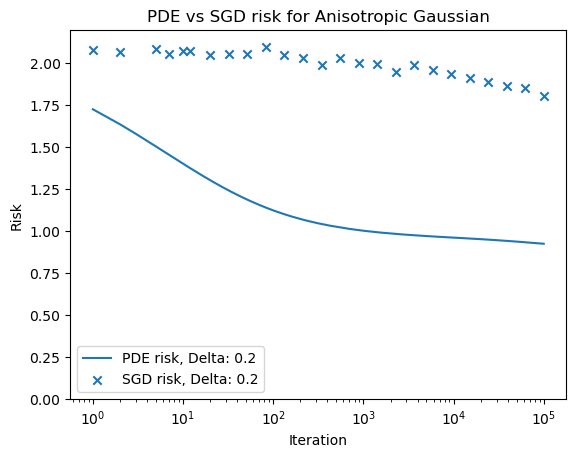

In [185]:
indices = [1,2,5,7,10]+[int(a) for a in 10**(np.linspace(1.1, 5, 20))]
plt.plot(iters, pde_loss(iters),  label = 'PDE risk, Delta: 0.2')
plt.scatter(np.array(indices), risk_SGD, marker = 'x', label = 'SGD risk, Delta: 0.2')
plt.xscale('log')
plt.xlabel('Iteration')
plt.ylabel('Risk')
plt.legend()
plt.title('PDE vs SGD risk for Anisotropic Gaussian')
plt.ylim([0,2.2])

Text(0.5, 1.0, 'PDE vs SGD Mean value of a for Anisotropic Gaussian')

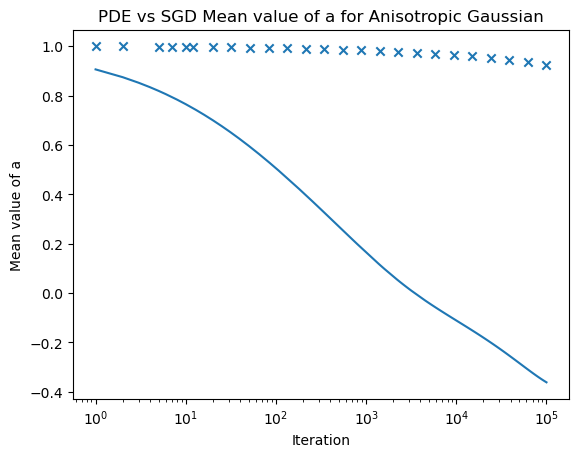

In [186]:
plt.plot(iters, avg_a_pde(iters), label = 'PDE mean value of a, Delta: 0.2')
plt.scatter(np.array(indices), a_SGD, marker = 'x', label = 'SGD mean value of a, Delta: 0.2')
plt.xscale('log')
plt.xlabel('Iteration')
plt.ylabel('Mean value of a')
plt.title('PDE vs SGD Mean value of a for Anisotropic Gaussian')